# Predicting perturbation responses for unseen cell-types (context transfer)

## Imports

In [12]:
import os
import cpa
import scanpy as sc
sc.settings.set_figure_params(dpi=100)
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from collections import defaultdict
from tqdm import tqdm

data_path = './plate9_preprocessed_for_CPA_pred_cell_final.h5ad'


## Dataset setup

In [ ]:
adata = sc.read(data_path)

adata.obs['condition_ID'].value_counts()
# List all obs (cell) metadata columns
print(adata.obs.columns.tolist())
print(adata.obs.head())

print("=== dose column ===")
print(adata.obs['dose'].unique().tolist())

print("\n=== cell_line value counts ===")
print(adata.obs['cell_line'].unique().tolist())

print("\n=== condition_ID value counts ===")
print(adata.obs['condition_ID'].unique().tolist())


['sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'condition', 'cov_cond']
                       sample  gene_count  tscp_count  mread_count  \
BARCODE_SUB_LIB_ID                                                   
01_182_084-lib_1661  smp_2263        2873        5211         6070   
01_018_172-lib_1658  smp_2263        1996        3180         3639   
01_156_051-lib_1622  smp_2263        1040        1519         1757   
01_102_003-lib_1656  smp_2263        1033        1589         1834   
01_147_038-lib_1601  smp_2263        1208        1736         2003   

                                                     drugname_drugconc  \
BARCODE_SUB_LIB_ID                                                       
01_182_084-lib_1661  [('Sivelestat (sodium tetrahydrate)', 5.0, 'uM')]   
01_018_172-lib_1658  [

In [16]:
# Choose which cell type to hold out
cell_line_holdout = 'CVCL_0546'

# 1) Initialize all as train
adata.obs['split_CVCL_0546'] = 'train'

# 2) Mark OOD on that cell type
adata.obs.loc[
    adata.obs['cell_line'] == cell_line_holdout,
    'split_CVCL_0546'
] = 'ood'

# 3) Carve ~5% of the TRAIN cells into a VALID set
train_idx = adata.obs.index[adata.obs['split_CVCL_0546'] == 'train']
n_val = max(1, int(0.05 * len(train_idx)))
val_idx = np.random.choice(train_idx, size=n_val, replace=False)
adata.obs.loc[val_idx, 'split_CVCL_0546'] = 'valid'

# 4) Inspect counts
print(adata.obs['split_CVCL_0546'].value_counts())


split_CVCL_0546
train    82521
ood       6136
valid     4343
Name: count, dtype: int64


In [18]:
group = 'CVCL_0546_stimulated'  # or any other from the list above
print("Keys inside that group:", adata.uns['rank_genes_groups'][group].keys())

Keys inside that group: dict_keys(['logfoldchanges', 'names', 'pvals', 'pvals_adj', 'scores'])


In [20]:
# Build a new dictionary with just gene names per cov_cond
rg_cov = {}
for key in adata.uns['rank_genes_groups'].keys():
    rg_cov[key] = adata.uns['rank_genes_groups'][key]['names']

# Save under correct key
adata.uns['rank_genes_groups_cov'] = rg_cov


In [21]:
cpa.CPA.setup_anndata(adata,
                      perturbation_key='condition',
                      control_group='ctrl',
                      dosage_key='log_dose',
                      categorical_covariate_keys=['cell_line'],
                      is_count_data=True,
                      deg_uns_key='rank_genes_groups_cov',
                      deg_uns_cat_key='cov_cond',
                      max_comb_len=1,
                     )

100%|██████████| 100/100 [00:00<00:00, 4875.40it/s]


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


In [22]:
model_params = {
    "n_latent": 256,
    "recon_loss": "nb",
    "doser_type": "linear",
    "n_hidden_encoder": 128,
    "n_layers_encoder": 2,
    "n_hidden_decoder": 512,
    "n_layers_decoder": 2,
    "use_batch_norm_encoder": True,
    "use_layer_norm_encoder": False,
    "use_batch_norm_decoder": False,
    "use_layer_norm_decoder": True,
    "dropout_rate_encoder": 0.05,
    "dropout_rate_decoder": 0.05,
    "variational": False,
    "seed": 6977,
}

trainer_params = {
    "n_epochs_kl_warmup": None,
    "n_epochs_pretrain_ae": 30,
    "n_epochs_adv_warmup": 50,
    "n_epochs_mixup_warmup": 0,
    "mixup_alpha": 0.0,
    "adv_steps": None,
    "n_hidden_adv": 64,
    "n_layers_adv": 3,
    "use_batch_norm_adv": True,
    "use_layer_norm_adv": False,
    "dropout_rate_adv": 0.3,
    "reg_adv": 20.0,
    "pen_adv": 5.0,
    "lr": 0.0003,
    "wd": 4e-07,
    "adv_lr": 0.0003,
    "adv_wd": 4e-07,
    "adv_loss": "cce",
    "doser_lr": 0.0003,
    "doser_wd": 4e-07,
    "do_clip_grad": True,
    "gradient_clip_value": 1.0,
    "step_size_lr": 10,
}

In [23]:
model = cpa.CPA(
    adata                = adata,
    split_key            = "split_CVCL_0546",   # <— use your new split
    train_split          = "train",
    valid_split          = "valid",
    test_split           = "ood",
    use_rdkit_embeddings = False,
    **model_params,
)

Global seed set to 6977


## Training CPA

In [25]:
model.train(max_epochs= 2000,
            use_gpu=False,
            train_size= 0.8,
            validation_size= 0.2,
            batch_size=512,
            plan_kwargs=trainer_params,
            early_stopping_patience=20,
            check_val_every_n_epoch=5,
            save_path='./pred_cell_Tahoe_CVCL_0546_plate_9_FINAL',
           )

100%|██████████| 2/2 [00:00<00:00, 34.48it/s]
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/2000:   0%|          | 4/2000 [02:47<23:17:51, 42.02s/it, v_num=1, recon=291, r2_mean=0.618, adv_loss=2.5, acc_pert=0.571, acc_cell_line=0.511] 


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/2000:   0%|          | 9/2000 [06:25<23:45:19, 42.95s/it, v_num=1, recon=279, r2_mean=0.645, adv_loss=2.07, acc_pert=0.601, acc_cell_line=0.611, val_recon=286, disnt_basal=0.671, disnt_after=1.17, val_r2_mean=0.62, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.6577462135895501
disnt_after = 1.1715974576484651
val_r2_mean = 0.6344038900903605
val_r2_var = 0.22736342024901784
Epoch 15/2000:   1%|          | 14/2000 [10:02<23:47:03, 43.11s/it, v_num=1, recon=273, r2_mean=0.659, adv_loss=2.02, acc_pert=0.607, acc_cell_line=0.625, val_recon=276, disnt_basal=0.658, disnt_after=1.17, val_r2_mean=0.634, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/2000:   1%|          | 19/2000 [13:39<23:45:55, 43.19s/it, v_num=1, recon=269, r2_mean=0.667, adv_loss=2.01, acc_pert=0.612, acc_cell_line=0.63, val_recon=272, disnt_basal=0.643, disnt_after=1.17, val_r2_mean=0.649, val_KL=nan] 


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.6389260312921752
disnt_after = 1.1709681208477036
val_r2_mean = 0.6608212628089725
val_r2_var = 0.259218801636112
Epoch 25/2000:   1%|          | 24/2000 [17:14<23:21:01, 42.54s/it, v_num=1, recon=265, r2_mean=0.673, adv_loss=2, acc_pert=0.613, acc_cell_line=0.633, val_recon=268, disnt_basal=0.639, disnt_after=1.17, val_r2_mean=0.661, val_KL=nan]   


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/2000:   1%|▏         | 29/2000 [21:14<26:13:59, 47.91s/it, v_num=1, recon=263, r2_mean=0.679, adv_loss=2.01, acc_pert=0.617, acc_cell_line=0.634, val_recon=265, disnt_basal=0.637, disnt_after=1.17, val_r2_mean=0.667, val_KL=nan]


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.6308970345671336
disnt_after = 1.1729066912234838
val_r2_mean = 0.6682308658550489
val_r2_var = 0.27486575999312407
Epoch 35/2000:   2%|▏         | 34/2000 [25:38<28:22:09, 51.95s/it, v_num=1, recon=261, r2_mean=0.683, adv_loss=2.62, acc_pert=0.613, acc_cell_line=0.475, val_recon=263, disnt_basal=0.631, disnt_after=1.17, val_r2_mean=0.668, val_KL=nan]


Epoch 00034: cpa_metric reached. Module best state updated.


Epoch 40/2000:   2%|▏         | 39/2000 [29:54<27:50:01, 51.10s/it, v_num=1, recon=261, r2_mean=0.681, adv_loss=4.03, acc_pert=0.587, acc_cell_line=0.145, val_recon=262, disnt_basal=0.582, disnt_after=1.17, val_r2_mean=0.672, val_KL=nan]


Epoch 00039: cpa_metric reached. Module best state updated.



disnt_basal = 0.5565068889022639
disnt_after = 1.1703770369515567
val_r2_mean = 0.6664797593972808
val_r2_var = 0.2742957284909368
Epoch 45/2000:   2%|▏         | 44/2000 [34:11<27:24:56, 50.46s/it, v_num=1, recon=260, r2_mean=0.682, adv_loss=4.16, acc_pert=0.569, acc_cell_line=0.109, val_recon=263, disnt_basal=0.557, disnt_after=1.17, val_r2_mean=0.666, val_KL=nan]


Epoch 00044: cpa_metric reached. Module best state updated.


Epoch 50/2000:   2%|▏         | 49/2000 [38:13<25:58:53, 47.94s/it, v_num=1, recon=259, r2_mean=0.685, adv_loss=4.22, acc_pert=0.554, acc_cell_line=0.0921, val_recon=262, disnt_basal=0.552, disnt_after=1.17, val_r2_mean=0.673, val_KL=nan]


Epoch 00049: cpa_metric reached. Module best state updated.



disnt_basal = 0.5482697834734119
disnt_after = 1.171139209775866
val_r2_mean = 0.6753966810382278
val_r2_var = 0.28246497180065827
Epoch 60/2000:   3%|▎         | 59/2000 [45:42<24:07:18, 44.74s/it, v_num=1, recon=257, r2_mean=0.691, adv_loss=4.27, acc_pert=0.531, acc_cell_line=0.077, val_recon=260, disnt_basal=0.549, disnt_after=1.17, val_r2_mean=0.677, val_KL=nan] 


Epoch 00059: cpa_metric reached. Module best state updated.



disnt_basal = 0.5392493375037657
disnt_after = 1.1690376535314877
val_r2_mean = 0.6768419559644668
val_r2_var = 0.2932835714532531
Epoch 65/2000:   3%|▎         | 64/2000 [49:23<23:42:19, 44.08s/it, v_num=1, recon=256, r2_mean=0.693, adv_loss=4.28, acc_pert=0.525, acc_cell_line=0.0752, val_recon=258, disnt_basal=0.539, disnt_after=1.17, val_r2_mean=0.677, val_KL=nan]


Epoch 00064: cpa_metric reached. Module best state updated.


Epoch 70/2000:   3%|▎         | 69/2000 [53:04<23:35:37, 43.99s/it, v_num=1, recon=255, r2_mean=0.694, adv_loss=4.3, acc_pert=0.52, acc_cell_line=0.0737, val_recon=258, disnt_basal=0.541, disnt_after=1.17, val_r2_mean=0.682, val_KL=nan]  


Epoch 00069: cpa_metric reached. Module best state updated.



disnt_basal = 0.538952034751898
disnt_after = 1.1702226977684584
val_r2_mean = 0.6876837101629719
val_r2_var = 0.30816024069727743
Epoch 80/2000:   4%|▍         | 79/2000 [1:00:28<23:33:17, 44.14s/it, v_num=1, recon=254, r2_mean=0.699, adv_loss=4.31, acc_pert=0.516, acc_cell_line=0.0707, val_recon=255, disnt_basal=0.538, disnt_after=1.17, val_r2_mean=0.687, val_KL=nan]


Epoch 00079: cpa_metric reached. Module best state updated.



disnt_basal = 0.5381155692738453
disnt_after = 1.170578393850013
val_r2_mean = 0.6889424961209516
val_r2_var = 0.3070764679517325
Epoch 85/2000:   4%|▍         | 84/2000 [1:04:10<23:28:17, 44.10s/it, v_num=1, recon=253, r2_mean=0.701, adv_loss=4.31, acc_pert=0.514, acc_cell_line=0.0713, val_recon=255, disnt_basal=0.538, disnt_after=1.17, val_r2_mean=0.689, val_KL=nan]


Epoch 00084: cpa_metric reached. Module best state updated.


Epoch 90/2000:   4%|▍         | 89/2000 [1:07:50<23:17:24, 43.87s/it, v_num=1, recon=252, r2_mean=0.703, adv_loss=4.31, acc_pert=0.512, acc_cell_line=0.0707, val_recon=254, disnt_basal=0.536, disnt_after=1.17, val_r2_mean=0.686, val_KL=nan]


Epoch 00089: cpa_metric reached. Module best state updated.



disnt_basal = 0.5374419049909167
disnt_after = 1.1693366626360968
val_r2_mean = 0.6942653201848539
val_r2_var = 0.3151022398856483
Epoch 95/2000:   5%|▍         | 94/2000 [1:11:31<23:13:58, 43.88s/it, v_num=1, recon=251, r2_mean=0.705, adv_loss=4.31, acc_pert=0.513, acc_cell_line=0.0728, val_recon=253, disnt_basal=0.537, disnt_after=1.17, val_r2_mean=0.694, val_KL=nan]


Epoch 00094: cpa_metric reached. Module best state updated.


Epoch 100/2000:   5%|▍         | 99/2000 [1:15:11<23:08:08, 43.81s/it, v_num=1, recon=250, r2_mean=0.707, adv_loss=4.3, acc_pert=0.513, acc_cell_line=0.0713, val_recon=253, disnt_basal=0.537, disnt_after=1.17, val_r2_mean=0.693, val_KL=nan]


Epoch 00099: cpa_metric reached. Module best state updated.



disnt_basal = 0.5368678934674698
disnt_after = 1.1703532429191563
val_r2_mean = 0.6966368696202025
val_r2_var = 0.32357816774871967
Epoch 105/2000:   5%|▌         | 104/2000 [1:18:52<23:06:58, 43.89s/it, v_num=1, recon=250, r2_mean=0.709, adv_loss=4.31, acc_pert=0.513, acc_cell_line=0.0715, val_recon=252, disnt_basal=0.537, disnt_after=1.17, val_r2_mean=0.697, val_KL=nan]


Epoch 00104: cpa_metric reached. Module best state updated.


Epoch 110/2000:   5%|▌         | 109/2000 [1:22:33<23:03:09, 43.89s/it, v_num=1, recon=249, r2_mean=0.712, adv_loss=4.3, acc_pert=0.512, acc_cell_line=0.0718, val_recon=250, disnt_basal=0.535, disnt_after=1.17, val_r2_mean=0.7, val_KL=nan]   
disnt_basal = 0.5351354969539032
disnt_after = 1.1708266267281309
val_r2_mean = 0.6980671180695865
val_r2_var = 0.3306789450765393
Epoch 120/2000:   6%|▌         | 119/2000 [1:29:55<22:57:44, 43.95s/it, v_num=1, recon=248, r2_mean=0.715, adv_loss=4.3, acc_pert=0.513, acc_cell_line=0.0714, val_recon=250, disnt_basal=0.536, disnt_after=1.17, val_r2_mean=0.701, val_KL=nan]
disnt_basal = 0.5364829292518067
disnt_after = 1.1703688066767621
val_r2_mean = 0.7014301476282394
val_r2_var = 0.34059861855354395
Epoch 125/2000:   6%|▌         | 124/2000 [1:33:36<22:52:33, 43.90s/it, v_num=1, recon=247, r2_mean=0.716, adv_loss=4.3, acc_pert=0.512, acc_cell_line=0.0714, val_recon=249, disnt_basal=0.536, disnt_after=1.17, val_r2_mean=0.701, val_KL=nan]


Epoch 00124: cpa_metric reached. Module best state updated.


Epoch 130/2000:   6%|▋         | 129/2000 [1:37:18<22:52:22, 44.01s/it, v_num=1, recon=247, r2_mean=0.717, adv_loss=4.3, acc_pert=0.511, acc_cell_line=0.0693, val_recon=249, disnt_basal=0.534, disnt_after=1.17, val_r2_mean=0.704, val_KL=nan]


Epoch 00129: cpa_metric reached. Module best state updated.



disnt_basal = 0.5369174285812118
disnt_after = 1.1694437006365033
val_r2_mean = 0.7067592564191738
val_r2_var = 0.3449528520928348
Epoch 135/2000:   7%|▋         | 134/2000 [1:41:00<22:54:10, 44.19s/it, v_num=1, recon=246, r2_mean=0.718, adv_loss=4.3, acc_pert=0.514, acc_cell_line=0.0711, val_recon=248, disnt_basal=0.537, disnt_after=1.17, val_r2_mean=0.707, val_KL=nan]


Epoch 00134: cpa_metric reached. Module best state updated.


Epoch 140/2000:   7%|▋         | 139/2000 [1:44:41<22:41:21, 43.89s/it, v_num=1, recon=246, r2_mean=0.719, adv_loss=4.3, acc_pert=0.513, acc_cell_line=0.0714, val_recon=246, disnt_basal=0.535, disnt_after=1.17, val_r2_mean=0.708, val_KL=nan]


Epoch 00139: cpa_metric reached. Module best state updated.



disnt_basal = 0.5350283224063827
disnt_after = 1.1696550132244337
val_r2_mean = 0.710471629788773
val_r2_var = 0.34903032783151944
Epoch 145/2000:   7%|▋         | 144/2000 [1:48:21<22:37:44, 43.89s/it, v_num=1, recon=245, r2_mean=0.72, adv_loss=4.3, acc_pert=0.512, acc_cell_line=0.0719, val_recon=246, disnt_basal=0.535, disnt_after=1.17, val_r2_mean=0.71, val_KL=nan]  


Epoch 00144: cpa_metric reached. Module best state updated.


Epoch 150/2000:   7%|▋         | 149/2000 [1:52:03<22:37:35, 44.01s/it, v_num=1, recon=245, r2_mean=0.721, adv_loss=4.3, acc_pert=0.512, acc_cell_line=0.0711, val_recon=246, disnt_basal=0.535, disnt_after=1.17, val_r2_mean=0.711, val_KL=nan]


Epoch 00149: cpa_metric reached. Module best state updated.



disnt_basal = 0.5331084684531603
disnt_after = 1.1708723808464816
val_r2_mean = 0.7136876182989398
val_r2_var = 0.35296639457987256
Epoch 160/2000:   8%|▊         | 159/2000 [1:59:27<22:33:16, 44.10s/it, v_num=1, recon=244, r2_mean=0.723, adv_loss=4.3, acc_pert=0.513, acc_cell_line=0.0715, val_recon=245, disnt_basal=0.535, disnt_after=1.17, val_r2_mean=0.709, val_KL=nan]
disnt_basal = 0.5384986080880021
disnt_after = 1.1706228998504307
val_r2_mean = 0.7136486903427613
val_r2_var = 0.3606188708732625
Epoch 170/2000:   8%|▊         | 169/2000 [2:06:48<22:18:08, 43.85s/it, v_num=1, recon=243, r2_mean=0.725, adv_loss=4.3, acc_pert=0.515, acc_cell_line=0.0705, val_recon=244, disnt_basal=0.536, disnt_after=1.17, val_r2_mean=0.714, val_KL=nan]


Epoch 00169: cpa_metric reached. Module best state updated.



disnt_basal = 0.5357777222295196
disnt_after = 1.171261441102569
val_r2_mean = 0.7117468303089312
val_r2_var = 0.3663653279515752
Epoch 175/2000:   9%|▊         | 174/2000 [2:10:29<22:16:16, 43.91s/it, v_num=1, recon=242, r2_mean=0.726, adv_loss=4.3, acc_pert=0.516, acc_cell_line=0.0728, val_recon=244, disnt_basal=0.536, disnt_after=1.17, val_r2_mean=0.712, val_KL=nan]


Epoch 00174: cpa_metric reached. Module best state updated.


Epoch 180/2000:   9%|▉         | 179/2000 [2:14:11<22:14:58, 43.99s/it, v_num=1, recon=242, r2_mean=0.727, adv_loss=4.3, acc_pert=0.515, acc_cell_line=0.0722, val_recon=243, disnt_basal=0.537, disnt_after=1.17, val_r2_mean=0.717, val_KL=nan]


Epoch 00179: cpa_metric reached. Module best state updated.



disnt_basal = 0.5321311888566069
disnt_after = 1.1701151844927768
val_r2_mean = 0.7192898486291861
val_r2_var = 0.3706594090017663
Epoch 190/2000:   9%|▉         | 189/2000 [2:21:33<22:05:53, 43.93s/it, v_num=1, recon=241, r2_mean=0.729, adv_loss=4.3, acc_pert=0.515, acc_cell_line=0.0735, val_recon=241, disnt_basal=0.536, disnt_after=1.17, val_r2_mean=0.72, val_KL=nan]  
disnt_basal = 0.5350335032113435
disnt_after = 1.1689688145053685
val_r2_mean = 0.71601586826282
val_r2_var = 0.36827714966261893
Epoch 200/2000:  10%|▉         | 199/2000 [2:28:54<21:55:55, 43.84s/it, v_num=1, recon=240, r2_mean=0.731, adv_loss=4.29, acc_pert=0.517, acc_cell_line=0.074, val_recon=240, disnt_basal=0.535, disnt_after=1.17, val_r2_mean=0.723, val_KL=nan] 


Epoch 00199: cpa_metric reached. Module best state updated.



disnt_basal = 0.5374413356227454
disnt_after = 1.1704047184978312
val_r2_mean = 0.7236763251751325
val_r2_var = 0.38144459719119506
Epoch 205/2000:  10%|█         | 204/2000 [2:32:35<21:53:22, 43.88s/it, v_num=1, recon=240, r2_mean=0.732, adv_loss=4.3, acc_pert=0.517, acc_cell_line=0.0715, val_recon=240, disnt_basal=0.537, disnt_after=1.17, val_r2_mean=0.724, val_KL=nan] 


Epoch 00204: cpa_metric reached. Module best state updated.


Epoch 210/2000:  10%|█         | 209/2000 [2:36:16<21:51:22, 43.93s/it, v_num=1, recon=239, r2_mean=0.733, adv_loss=4.29, acc_pert=0.519, acc_cell_line=0.0737, val_recon=240, disnt_basal=0.534, disnt_after=1.17, val_r2_mean=0.724, val_KL=nan]


Epoch 00209: cpa_metric reached. Module best state updated.



disnt_basal = 0.5323645908634672
disnt_after = 1.172050370582441
val_r2_mean = 0.7271384520425567
val_r2_var = 0.3873505065435412
Epoch 220/2000:  11%|█         | 219/2000 [2:43:38<21:39:20, 43.77s/it, v_num=1, recon=239, r2_mean=0.734, adv_loss=4.29, acc_pert=0.517, acc_cell_line=0.0741, val_recon=239, disnt_basal=0.536, disnt_after=1.17, val_r2_mean=0.724, val_KL=nan]
disnt_basal = 0.5321128535801768
disnt_after = 1.1687989740032754
val_r2_mean = 0.7258952390948721
val_r2_var = 0.388819063006081
Epoch 230/2000:  11%|█▏        | 229/2000 [2:50:59<21:35:11, 43.88s/it, v_num=1, recon=238, r2_mean=0.735, adv_loss=4.29, acc_pert=0.519, acc_cell_line=0.0754, val_recon=239, disnt_basal=0.535, disnt_after=1.17, val_r2_mean=0.727, val_KL=nan]
disnt_basal = 0.5325659119533657
disnt_after = 1.170772615941853
val_r2_mean = 0.7257123128726896
val_r2_var = 0.3895029278732076
Epoch 240/2000:  12%|█▏        | 239/2000 [2:58:21<21:27:58, 43.88s/it, v_num=1, recon=238, r2_mean=0.737, adv_loss=4.29, a


Epoch 00244: cpa_metric reached. Module best state updated.


Epoch 250/2000:  12%|█▏        | 249/2000 [3:05:42<21:20:26, 43.88s/it, v_num=1, recon=237, r2_mean=0.737, adv_loss=4.29, acc_pert=0.521, acc_cell_line=0.0723, val_recon=238, disnt_basal=0.534, disnt_after=1.17, val_r2_mean=0.733, val_KL=nan]
disnt_basal = 0.5365735714921389
disnt_after = 1.1724478024583063
val_r2_mean = 0.7281360461948488
val_r2_var = 0.3928748895758056
Epoch 260/2000:  13%|█▎        | 259/2000 [3:13:04<21:14:00, 43.91s/it, v_num=1, recon=237, r2_mean=0.738, adv_loss=4.29, acc_pert=0.522, acc_cell_line=0.0727, val_recon=237, disnt_basal=0.539, disnt_after=1.17, val_r2_mean=0.731, val_KL=nan]
disnt_basal = 0.5354708843027391
disnt_after = 1.1689094512846663
val_r2_mean = 0.7306900927345655
val_r2_var = 0.3964756566726863
Epoch 270/2000:  13%|█▎        | 269/2000 [3:20:25<21:07:25, 43.93s/it, v_num=1, recon=236, r2_mean=0.739, adv_loss=4.28, acc_pert=0.519, acc_cell_line=0.0763, val_recon=236, disnt_basal=0.536, disnt_after=1.17, val_r2_mean=0.73, val_KL=nan] 


Epoch 00269: cpa_metric reached. Module best state updated.



disnt_basal = 0.5335200511753926
disnt_after = 1.1691081104413672
val_r2_mean = 0.7355320822131899
val_r2_var = 0.4018593991165799
Epoch 280/2000:  14%|█▍        | 279/2000 [3:27:47<20:58:17, 43.87s/it, v_num=1, recon=236, r2_mean=0.74, adv_loss=4.28, acc_pert=0.522, acc_cell_line=0.0759, val_recon=236, disnt_basal=0.537, disnt_after=1.17, val_r2_mean=0.735, val_KL=nan] 


Epoch 00279: cpa_metric reached. Module best state updated.



disnt_basal = 0.5338833678523002
disnt_after = 1.1731925372915573
val_r2_mean = 0.7340474297857611
val_r2_var = 0.40239474857487223
Epoch 290/2000:  14%|█▍        | 289/2000 [3:35:08<20:51:29, 43.89s/it, v_num=1, recon=235, r2_mean=0.741, adv_loss=4.28, acc_pert=0.52, acc_cell_line=0.0753, val_recon=235, disnt_basal=0.54, disnt_after=1.17, val_r2_mean=0.734, val_KL=nan]  
disnt_basal = 0.5370579287693507
disnt_after = 1.1689045318175688
val_r2_mean = 0.7303798552403657
val_r2_var = 0.40136609888165004
Epoch 300/2000:  15%|█▍        | 299/2000 [3:42:29<20:42:12, 43.82s/it, v_num=1, recon=235, r2_mean=0.741, adv_loss=4.28, acc_pert=0.522, acc_cell_line=0.0772, val_recon=235, disnt_basal=0.538, disnt_after=1.17, val_r2_mean=0.733, val_KL=nan]
disnt_basal = 0.5349634323312077
disnt_after = 1.1689768015212736
val_r2_mean = 0.735717490722873
val_r2_var = 0.40331044734207855
Epoch 310/2000:  15%|█▌        | 309/2000 [3:49:48<20:32:13, 43.72s/it, v_num=1, recon=234, r2_mean=0.744, adv_loss=4.


Epoch 00349: cpa_metric reached. Module best state updated.



disnt_basal = 0.5334421025076518
disnt_after = 1.171353778037602
val_r2_mean = 0.7404260636559168
val_r2_var = 0.41097430647551714
Epoch 360/2000:  18%|█▊        | 359/2000 [4:26:36<19:57:47, 43.80s/it, v_num=1, recon=232, r2_mean=0.747, adv_loss=4.28, acc_pert=0.526, acc_cell_line=0.0758, val_recon=232, disnt_basal=0.534, disnt_after=1.17, val_r2_mean=0.74, val_KL=nan] 
disnt_basal = 0.5345205114185196
disnt_after = 1.1680074464494756
val_r2_mean = 0.7384549747924152
val_r2_var = 0.416715771796165
Epoch 370/2000:  18%|█▊        | 369/2000 [4:33:56<19:45:52, 43.63s/it, v_num=1, recon=232, r2_mean=0.748, adv_loss=4.29, acc_pert=0.527, acc_cell_line=0.0698, val_recon=232, disnt_basal=0.535, disnt_after=1.17, val_r2_mean=0.737, val_KL=nan]
disnt_basal = 0.5367430764568221
disnt_after = 1.1688269493845902
val_r2_mean = 0.7403524325460723
val_r2_var = 0.4217558435917154
Epoch 380/2000:  19%|█▉        | 379/2000 [4:41:17<19:42:58, 43.79s/it, v_num=1, recon=231, r2_mean=0.749, adv_loss=4.27,


Epoch 00404: cpa_metric reached. Module best state updated.


Epoch 410/2000:  20%|██        | 409/2000 [5:03:18<19:21:29, 43.80s/it, v_num=1, recon=230, r2_mean=0.751, adv_loss=4.27, acc_pert=0.53, acc_cell_line=0.0754, val_recon=230, disnt_basal=0.536, disnt_after=1.17, val_r2_mean=0.744, val_KL=nan] 
disnt_basal = 0.538376208562622
disnt_after = 1.169357552203385
val_r2_mean = 0.7435020628581686
val_r2_var = 0.4165143436413525
Epoch 420/2000:  21%|██        | 419/2000 [5:10:39<19:13:23, 43.77s/it, v_num=1, recon=229, r2_mean=0.754, adv_loss=4.27, acc_pert=0.531, acc_cell_line=0.077, val_recon=230, disnt_basal=0.536, disnt_after=1.17, val_r2_mean=0.743, val_KL=nan] 
disnt_basal = 0.5357506967855331
disnt_after = 1.1699341668603223
val_r2_mean = 0.7452626964541644
val_r2_var = 0.4213914220083274
Epoch 430/2000:  21%|██▏       | 429/2000 [5:18:00<19:07:27, 43.82s/it, v_num=1, recon=229, r2_mean=0.755, adv_loss=4.26, acc_pert=0.53, acc_cell_line=0.0814, val_recon=230, disnt_basal=0.538, disnt_after=1.17, val_r2_mean=0.743, val_KL=nan] 
disnt_basal


Epoch 00459: cpa_metric reached. Module best state updated.



disnt_basal = 0.5366545342020281
disnt_after = 1.170504968912471
val_r2_mean = 0.7489539656195628
val_r2_var = 0.43484065054970283
Epoch 470/2000:  23%|██▎       | 469/2000 [5:47:21<18:36:34, 43.76s/it, v_num=1, recon=228, r2_mean=0.758, adv_loss=4.26, acc_pert=0.535, acc_cell_line=0.0813, val_recon=229, disnt_basal=0.537, disnt_after=1.17, val_r2_mean=0.741, val_KL=nan]
disnt_basal = 0.5376675527619518
disnt_after = 1.1673295809448023
val_r2_mean = 0.7461554728850769
val_r2_var = 0.4291641872004607
Epoch 480/2000:  24%|██▍       | 479/2000 [5:54:41<18:30:18, 43.80s/it, v_num=1, recon=227, r2_mean=0.758, adv_loss=4.26, acc_pert=0.532, acc_cell_line=0.0775, val_recon=228, disnt_basal=0.541, disnt_after=1.17, val_r2_mean=0.749, val_KL=nan]
disnt_basal = 0.535690688006645
disnt_after = 1.1649938993056899
val_r2_mean = 0.7427061310649639
val_r2_var = 0.429894070522926
Epoch 490/2000:  24%|██▍       | 489/2000 [6:02:01<18:20:21, 43.69s/it, v_num=1, recon=227, r2_mean=0.759, adv_loss=4.26, 

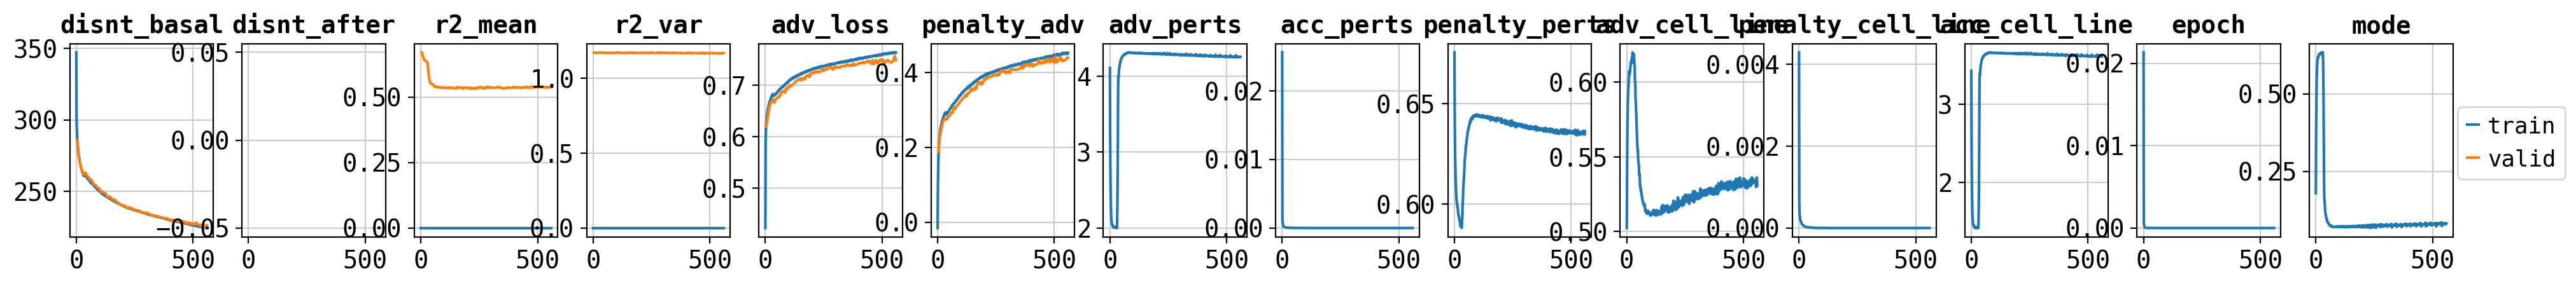

In [26]:
cpa.pl.plot_history(model)

# Load The saved Model

In [27]:
# #Restore model 
# model = cpa.CPA.load(dir_path='./pred_cell_Tahoe_CVCL_0546_plate_9_FINAL',
#                      adata=adata,
#                      use_gpu=False)

# cpa.pl.plot_history(model)

## Latent Space Visualization

100%|██████████| 46/46 [00:02<00:00, 15.57it/s]


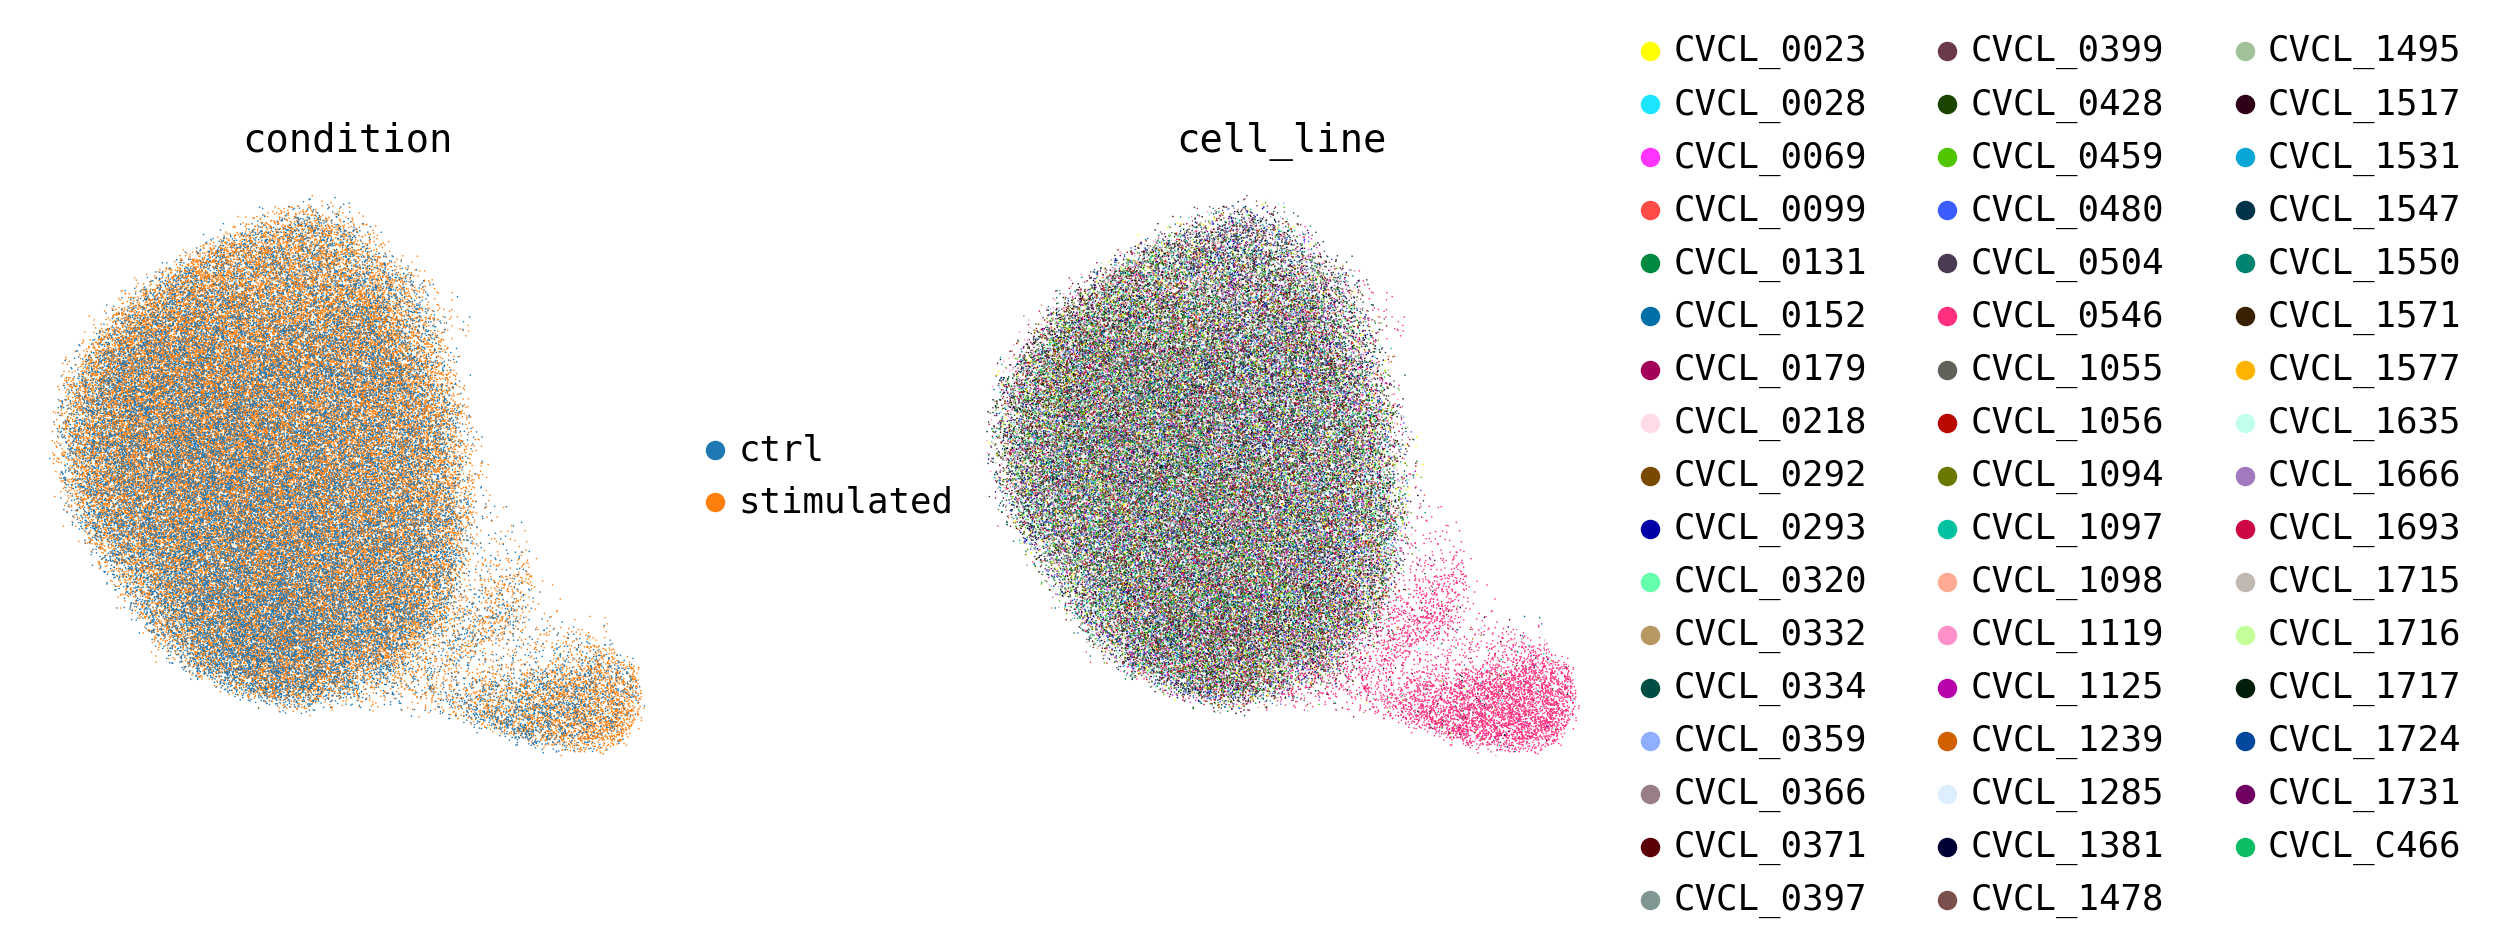

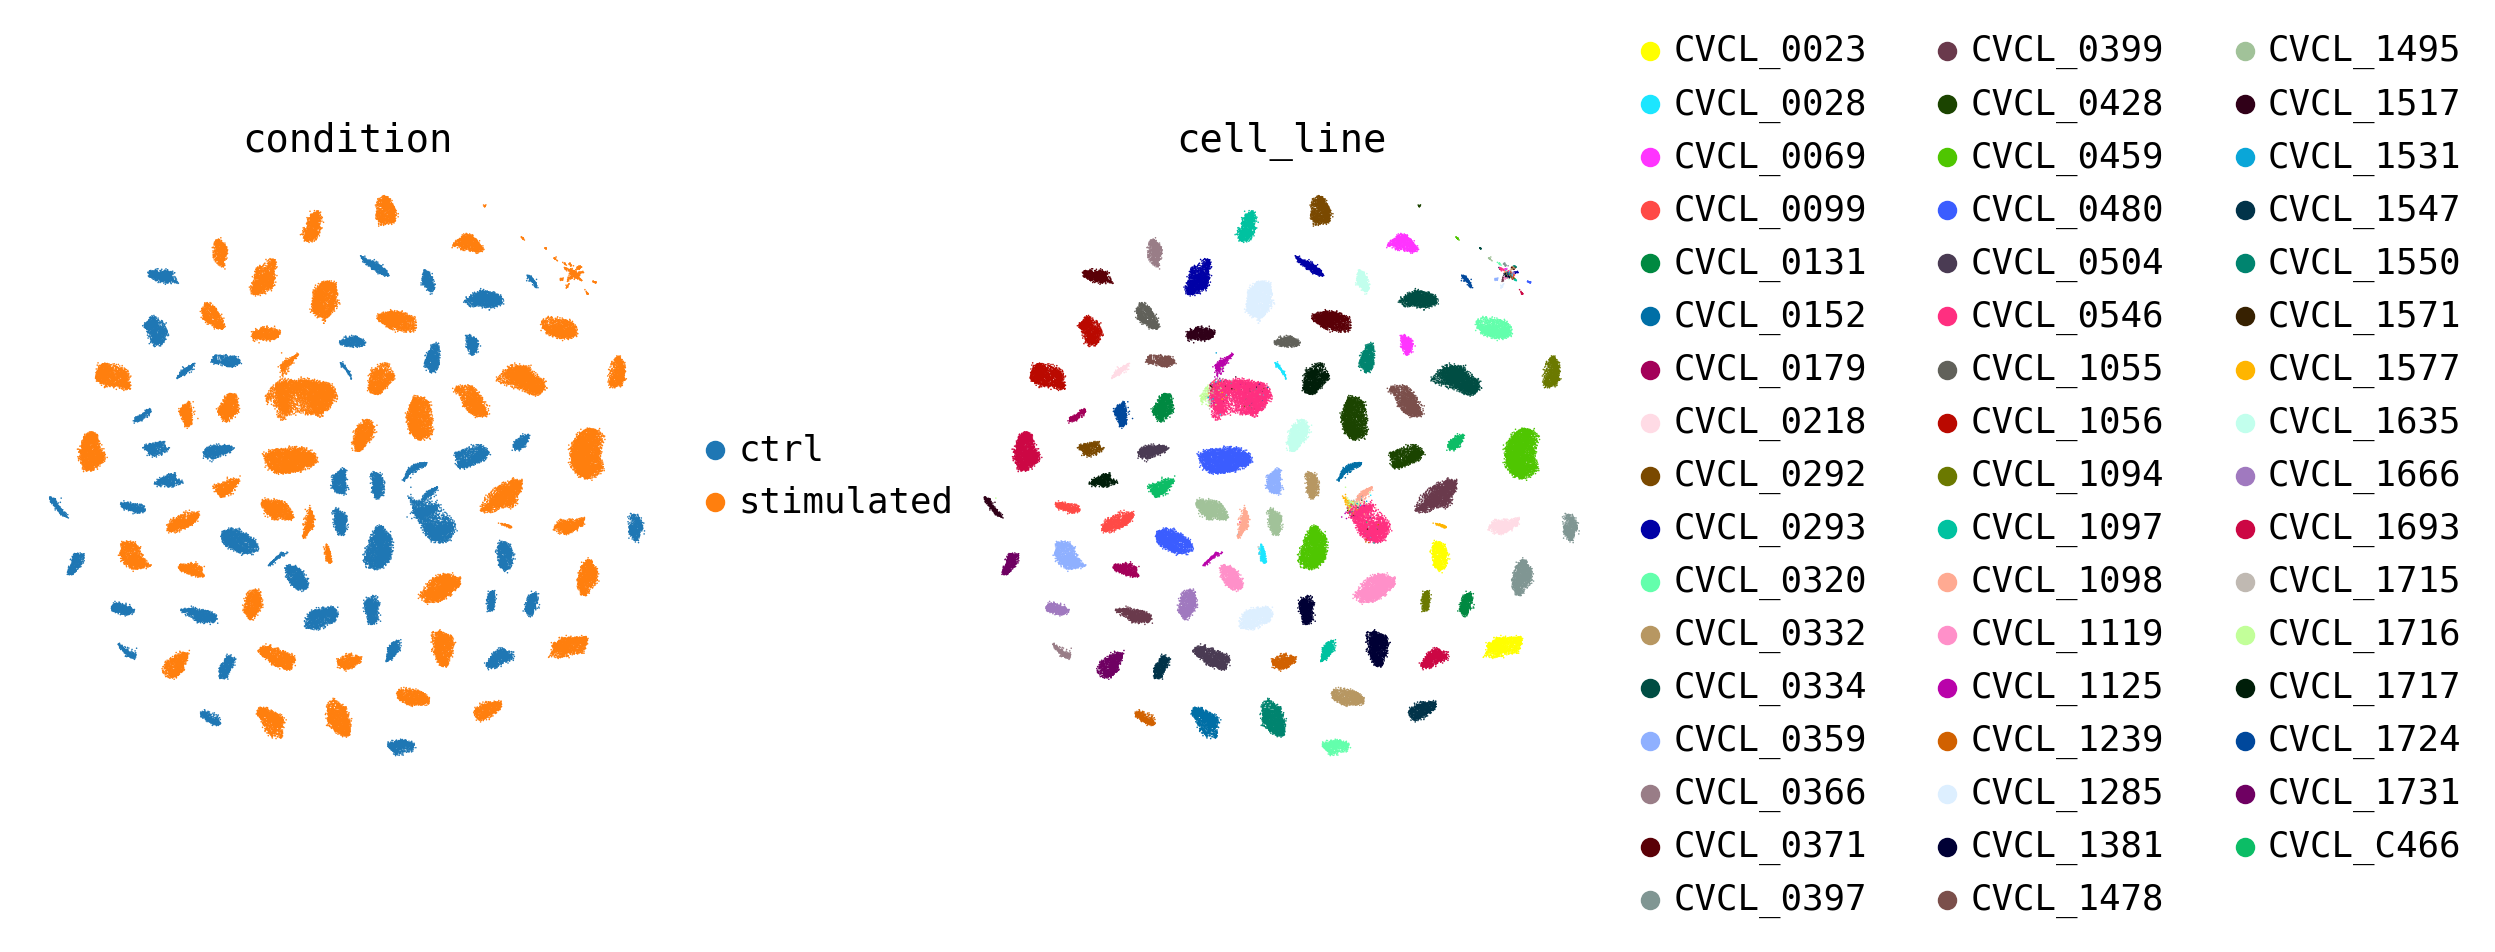

In [28]:
latent_outputs = model.get_latent_representation(adata, batch_size=2048)
latent_outputs.keys()
sc.pp.neighbors(latent_outputs['latent_basal'])
sc.tl.umap(latent_outputs['latent_basal'])
sc.pl.umap(latent_outputs['latent_basal'],
           color=['condition', 'cell_line'],
           frameon=False,
           wspace=0.3)

sc.pp.neighbors(latent_outputs['latent_after'])
sc.tl.umap(latent_outputs['latent_after'])

sc.pl.umap(latent_outputs['latent_after'],
           color=['condition', 'cell_line'],
           frameon=False,
           wspace=0.3)

## Evaluation

In [30]:
model.predict(adata, batch_size=2048)

100%|██████████| 46/46 [00:04<00:00, 10.89it/s]


In [31]:
print("Available DE keys:", adata.uns['rank_genes_groups'].keys())


Available DE keys: dict_keys(['CVCL_0023_stimulated', 'CVCL_0028_stimulated', 'CVCL_0069_stimulated', 'CVCL_0099_stimulated', 'CVCL_0131_stimulated', 'CVCL_0152_stimulated', 'CVCL_0179_stimulated', 'CVCL_0218_stimulated', 'CVCL_0292_stimulated', 'CVCL_0293_stimulated', 'CVCL_0320_stimulated', 'CVCL_0332_stimulated', 'CVCL_0334_stimulated', 'CVCL_0359_stimulated', 'CVCL_0366_stimulated', 'CVCL_0371_stimulated', 'CVCL_0397_stimulated', 'CVCL_0399_stimulated', 'CVCL_0428_stimulated', 'CVCL_0459_stimulated', 'CVCL_0480_stimulated', 'CVCL_0504_stimulated', 'CVCL_0546_stimulated', 'CVCL_1055_stimulated', 'CVCL_1056_stimulated', 'CVCL_1094_stimulated', 'CVCL_1097_stimulated', 'CVCL_1098_stimulated', 'CVCL_1119_stimulated', 'CVCL_1125_stimulated', 'CVCL_1239_stimulated', 'CVCL_1285_stimulated', 'CVCL_1381_stimulated', 'CVCL_1478_stimulated', 'CVCL_1495_stimulated', 'CVCL_1517_stimulated', 'CVCL_1531_stimulated', 'CVCL_1547_stimulated', 'CVCL_1550_stimulated', 'CVCL_1571_stimulated', 'CVCL_1577

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from collections import defaultdict
from tqdm import tqdm

n_top_degs = [10, 20, 50, None] # None means all genes

results = defaultdict(list)
for cat in tqdm(adata.obs['cov_cond'].unique()):
    if 'ctrl' not in cat:
        cov, condition = cat.rsplit('_',1)
        cat_adata = adata[adata.obs['cov_cond'] == cat].copy()
        print("cat-data:", cat_adata)
        ctrl_adata = adata[adata.obs['cov_cond'] == f'{cov}_ctrl'].copy()
        print("ctr-data:", ctrl_adata)

        #break

        deg_cat = f'{cat}'
        deg_list = adata.uns['rank_genes_groups'][deg_cat]['names']
        print("deg_list:", deg_list)

        print(f"Number of DEGs in {deg_cat}: {len(deg_list)}")
        
        x_true = cat_adata.layers['counts']
        x_pred = cat_adata.obsm['CPA_pred']
        x_ctrl = ctrl_adata.layers['counts']

        #break
        x_true = np.log1p(x_true)
        x_pred = np.log1p(x_pred)
        x_ctrl = np.log1p(x_ctrl)

        for n_top_deg in n_top_degs:
            if n_top_deg is not None:
                degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
            else:
                degs = np.arange(adata.n_vars)
                n_top_deg = 'all'

        
            x_true_deg = x_true[:, degs]
            x_pred_deg = x_pred[:, degs]
            x_ctrl_deg = x_ctrl[:, degs]

            if x_true_deg.shape[0] < 2 or x_pred_deg.shape[0] < 2:
                print(f"⚠️ Skipping R² computation for {cat}, n_top_deg={n_top_deg} due to insufficient samples.")
                continue
            if x_true_deg.shape[1] != x_pred_deg.shape[1]:
                print(f"⚠️ Skipping due to mismatch in DEG count: x_true_deg {x_true_deg.shape}, x_pred_deg {x_pred_deg.shape}")
                continue
            if len(degs) == 0:
                print(f"⚠️ Skipping R² for {cat} @top-{n_top_deg}: No DEGs found")
                continue



            print(f"\n✅ Shapes before R² computation for {cat}, top-{n_top_deg}:")
            print("x_true shape:", x_true.shape)
            print("x_pred shape:", x_pred.shape)
            print("x_ctrl shape:", x_ctrl.shape)
            print("x_true_deg shape:", x_true_deg.shape)
            print("x_pred_deg shape:", x_pred_deg.shape)
            print("x_ctrl_deg shape:", x_ctrl_deg.shape)
            print("degs shape:", degs.shape)
            print("degs indices:", degs)
            print("Number of DEGs used:", len(degs))

            # Convert to 1D numpy arrays (flattened) for compatibility
            # Means
            true_mean = np.asarray(x_true_deg.mean(0)).flatten()
            pred_mean = np.asarray(x_pred_deg.mean(0)).flatten()
            ctrl_mean = np.asarray(x_ctrl_deg.mean(0)).flatten()

            # Variances — convert to dense first
            true_var = np.var(x_true_deg.toarray(), axis=0)
            pred_var = np.var(x_pred_deg, axis=0)
            ctrl_var = np.var(x_ctrl_deg.toarray(), axis=0)


            # R² computations
            r2_mean_deg = r2_score(true_mean, pred_mean)
            r2_var_deg = r2_score(true_var, pred_var)

            r2_mean_lfc_deg = r2_score(true_mean - ctrl_mean, pred_mean - ctrl_mean)
            r2_var_lfc_deg = r2_score(true_var - ctrl_var, pred_var - ctrl_var)


            results['condition'].append(condition)
            results['cell_type'].append(cov)
            results['n_top_deg'].append(n_top_deg)
            results['r2_mean_deg'].append(r2_mean_deg)
            results['r2_var_deg'].append(r2_var_deg)
            results['r2_mean_lfc_deg'].append(r2_mean_lfc_deg)
            results['r2_var_lfc_deg'].append(r2_var_lfc_deg)

df = pd.DataFrame(results)

  1%|          | 1/100 [00:00<00:12,  7.96it/s]

cat-data: AnnData object with n_obs × n_vars = 515 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 271 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose

  2%|▏         | 2/100 [00:00<00:19,  5.10it/s]

ctr-data: AnnData object with n_obs × n_vars = 462 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['FAM20C' 'SDK1' 'ZNF608' ... 'HILPDA' 'ANKRD37' 'IER3']
Number of DEGs in CVCL_0366_stimulated: 2000

✅ Shapes before R² computation for CVCL_0366_stimulated, top-10:
x_true shape: (716, 2000)
x_pred shape: (716, 2000)
x_ctrl shape: (462, 2000)
x_true_deg shape: (716, 10)
x_pred_deg shape: (

  3%|▎         | 3/100 [00:01<00:39,  2.49it/s]

ctr-data: AnnData object with n_obs × n_vars = 1260 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['MSC-AS1' 'SOD2' 'TENM3' ... 'EGR1' 'STC1' 'MT2A']
Number of DEGs in CVCL_1285_stimulated: 2000

✅ Shapes before R² computation for CVCL_1285_stimulated, top-10:
x_true shape: (1849, 2000)
x_pred shape: (1849, 2000)
x_ctrl shape: (1260, 2000)
x_true_deg shape: (1849, 10)
x_pred_deg shape: (

  4%|▍         | 4/100 [00:01<00:36,  2.66it/s]

cat-data: AnnData object with n_obs × n_vars = 804 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 470 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose

  5%|▌         | 5/100 [00:01<00:30,  3.10it/s]

cat-data: AnnData object with n_obs × n_vars = 405 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 185 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose

  6%|▌         | 6/100 [00:02<00:37,  2.52it/s]

cat-data: AnnData object with n_obs × n_vars = 2065 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 1230 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_do

  7%|▋         | 7/100 [00:02<00:39,  2.36it/s]

cat-data: AnnData object with n_obs × n_vars = 4027 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 2109 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_do

  8%|▊         | 8/100 [00:03<00:48,  1.91it/s]


✅ Shapes before R² computation for CVCL_0546_stimulated, top-10:
x_true shape: (4027, 2000)
x_pred shape: (4027, 2000)
x_ctrl shape: (2109, 2000)
x_true_deg shape: (4027, 10)
x_pred_deg shape: (4027, 10)
x_ctrl_deg shape: (2109, 10)
degs shape: (10,)
degs indices: [  94  265  336  393  582  614  688  765 1904 1944]
Number of DEGs used: 10

✅ Shapes before R² computation for CVCL_0546_stimulated, top-20:
x_true shape: (4027, 2000)
x_pred shape: (4027, 2000)
x_ctrl shape: (2109, 2000)
x_true_deg shape: (4027, 20)
x_pred_deg shape: (4027, 20)
x_ctrl_deg shape: (2109, 20)
degs shape: (20,)
degs indices: [  71   94  194  265  336  374  393  582  602  614  688  765  785  864
 1045 1117 1724 1787 1904 1944]
Number of DEGs used: 20

✅ Shapes before R² computation for CVCL_0546_stimulated, top-50:
x_true shape: (4027, 2000)
x_pred shape: (4027, 2000)
x_ctrl shape: (2109, 2000)
x_true_deg shape: (4027, 50)
x_pred_deg shape: (4027, 50)
x_ctrl_deg shape: (2109, 50)
degs shape: (50,)
degs indices:

  9%|▉         | 9/100 [00:03<00:39,  2.30it/s]

cat-data: AnnData object with n_obs × n_vars = 912 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 518 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose

 10%|█         | 10/100 [00:03<00:33,  2.71it/s]

cat-data: AnnData object with n_obs × n_vars = 999 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 564 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose

 11%|█         | 11/100 [00:04<00:29,  3.06it/s]

cat-data: AnnData object with n_obs × n_vars = 957 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 625 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose

 12%|█▏        | 12/100 [00:04<00:29,  3.02it/s]

cat-data: AnnData object with n_obs × n_vars = 1570 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 1052 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_do

 13%|█▎        | 13/100 [00:04<00:26,  3.31it/s]

cat-data: AnnData object with n_obs × n_vars = 1384 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 724 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dos

 14%|█▍        | 14/100 [00:04<00:23,  3.61it/s]

ctr-data: AnnData object with n_obs × n_vars = 744 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['ABTB2' 'SOD2' 'ITPR1' ... 'MT2A' 'LINC03047' 'EGR1']
Number of DEGs in CVCL_1495_stimulated: 2000

✅ Shapes before R² computation for CVCL_1495_stimulated, top-10:
x_true shape: (1222, 2000)
x_pred shape: (1222, 2000)
x_ctrl shape: (744, 2000)
x_true_deg shape: (1222, 10)
x_pred_deg shape: 

 15%|█▌        | 15/100 [00:05<00:21,  4.03it/s]


✅ Shapes before R² computation for CVCL_0099_stimulated, top-10:
x_true shape: (962, 2000)
x_pred shape: (962, 2000)
x_ctrl shape: (480, 2000)
x_true_deg shape: (962, 10)
x_pred_deg shape: (962, 10)
x_ctrl_deg shape: (480, 10)
degs shape: (10,)
degs indices: [ 178  188  203  348  426  430  588  843 1373 1392]
Number of DEGs used: 10

✅ Shapes before R² computation for CVCL_0099_stimulated, top-20:
x_true shape: (962, 2000)
x_pred shape: (962, 2000)
x_ctrl shape: (480, 2000)
x_true_deg shape: (962, 20)
x_pred_deg shape: (962, 20)
x_ctrl_deg shape: (480, 20)
degs shape: (20,)
degs indices: [   8   31   94  112  169  178  188  203  348  426  430  471  588  763
  769  843 1062 1373 1392 1956]
Number of DEGs used: 20

✅ Shapes before R² computation for CVCL_0099_stimulated, top-50:
x_true shape: (962, 2000)
x_pred shape: (962, 2000)
x_ctrl shape: (480, 2000)
x_true_deg shape: (962, 50)
x_pred_deg shape: (962, 50)
x_ctrl_deg shape: (480, 50)
degs shape: (50,)
degs indices: [   8   31   35  

 16%|█▌        | 16/100 [00:05<00:20,  4.17it/s]


✅ Shapes before R² computation for CVCL_0152_stimulated, top-10:
x_true shape: (1162, 2000)
x_pred shape: (1162, 2000)
x_ctrl shape: (618, 2000)
x_true_deg shape: (1162, 10)
x_pred_deg shape: (1162, 10)
x_ctrl_deg shape: (618, 10)
degs shape: (10,)
degs indices: [  1 140 169 236 462 471 504 588 701 780]
Number of DEGs used: 10

✅ Shapes before R² computation for CVCL_0152_stimulated, top-20:
x_true shape: (1162, 2000)
x_pred shape: (1162, 2000)
x_ctrl shape: (618, 2000)
x_true_deg shape: (1162, 20)
x_pred_deg shape: (1162, 20)
x_ctrl_deg shape: (618, 20)
degs shape: (20,)
degs indices: [   1   21   35   73  140  169  171  233  236  348  462  471  504  588
  701  764  780  788  898 1824]
Number of DEGs used: 20

✅ Shapes before R² computation for CVCL_0152_stimulated, top-50:
x_true shape: (1162, 2000)
x_pred shape: (1162, 2000)
x_ctrl shape: (618, 2000)
x_true_deg shape: (1162, 50)
x_pred_deg shape: (1162, 50)
x_ctrl_deg shape: (618, 50)
degs shape: (50,)
degs indices: [   1   11   21

 17%|█▋        | 17/100 [00:05<00:19,  4.28it/s]


✅ Shapes before R² computation for CVCL_1635_stimulated, top-10:
x_true shape: (1193, 2000)
x_pred shape: (1193, 2000)
x_ctrl shape: (598, 2000)
x_true_deg shape: (1193, 10)
x_pred_deg shape: (1193, 10)
x_ctrl_deg shape: (598, 10)
degs shape: (10,)
degs indices: [  21  269  293  368  436  578  671  777  780 1373]
Number of DEGs used: 10

✅ Shapes before R² computation for CVCL_1635_stimulated, top-20:
x_true shape: (1193, 2000)
x_pred shape: (1193, 2000)
x_ctrl shape: (598, 2000)
x_true_deg shape: (1193, 20)
x_pred_deg shape: (1193, 20)
x_ctrl_deg shape: (598, 20)
degs shape: (20,)
degs indices: [   1   12   21   35  196  269  293  368  384  436  578  671  777  780
  795  807  814 1062 1315 1373]
Number of DEGs used: 20

✅ Shapes before R² computation for CVCL_1635_stimulated, top-50:
x_true shape: (1193, 2000)
x_pred shape: (1193, 2000)
x_ctrl shape: (598, 2000)
x_true_deg shape: (1193, 50)
x_pred_deg shape: (1193, 50)
x_ctrl_deg shape: (598, 50)
degs shape: (50,)
degs indices: [   1

 18%|█▊        | 18/100 [00:05<00:18,  4.46it/s]


✅ Shapes before R² computation for CVCL_0292_stimulated, top-all:
x_true shape: (1095, 2000)
x_pred shape: (1095, 2000)
x_ctrl shape: (575, 2000)
x_true_deg shape: (1095, 2000)
x_pred_deg shape: (1095, 2000)
x_ctrl_deg shape: (575, 2000)
degs shape: (2000,)
degs indices: [   0    1    2 ... 1997 1998 1999]
Number of DEGs used: 2000
cat-data: AnnData object with n_obs × n_vars = 1331 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2',

 19%|█▉        | 19/100 [00:05<00:18,  4.35it/s]


✅ Shapes before R² computation for CVCL_0320_stimulated, top-10:
x_true shape: (1331, 2000)
x_pred shape: (1331, 2000)
x_ctrl shape: (716, 2000)
x_true_deg shape: (1331, 10)
x_pred_deg shape: (1331, 10)
x_ctrl_deg shape: (716, 10)
degs shape: (10,)
degs indices: [   1  269  467  588  602  655  777  828  845 1123]
Number of DEGs used: 10

✅ Shapes before R² computation for CVCL_0320_stimulated, top-20:
x_true shape: (1331, 2000)
x_pred shape: (1331, 2000)
x_ctrl shape: (716, 2000)
x_true_deg shape: (1331, 20)
x_pred_deg shape: (1331, 20)
x_ctrl_deg shape: (716, 20)
degs shape: (20,)
degs indices: [   1   69   88  269  388  467  471  588  602  623  653  655  777  828
  845  849 1123 1305 1930 1971]
Number of DEGs used: 20

✅ Shapes before R² computation for CVCL_0320_stimulated, top-50:
x_true shape: (1331, 2000)
x_pred shape: (1331, 2000)
x_ctrl shape: (716, 2000)
x_true_deg shape: (1331, 50)
x_pred_deg shape: (1331, 50)
x_ctrl_deg shape: (716, 50)
degs shape: (50,)
degs indices: [   1

 20%|██        | 20/100 [00:06<00:17,  4.63it/s]


✅ Shapes before R² computation for CVCL_1717_stimulated, top-all:
x_true shape: (1183, 2000)
x_pred shape: (1183, 2000)
x_ctrl shape: (531, 2000)
x_true_deg shape: (1183, 2000)
x_pred_deg shape: (1183, 2000)
x_ctrl_deg shape: (531, 2000)
degs shape: (2000,)
degs indices: [   0    1    2 ... 1997 1998 1999]
Number of DEGs used: 2000
cat-data: AnnData object with n_obs × n_vars = 1873 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2',

 21%|██        | 21/100 [00:06<00:17,  4.51it/s]


✅ Shapes before R² computation for CVCL_1693_stimulated, top-20:
x_true shape: (1873, 2000)
x_pred shape: (1873, 2000)
x_ctrl shape: (874, 2000)
x_true_deg shape: (1873, 20)
x_pred_deg shape: (1873, 20)
x_ctrl_deg shape: (874, 20)
degs shape: (20,)
degs indices: [  72   77  148  196  286  348  385  426  448  504  521  630  657  754
  776  826  863 1093 1592 1624]
Number of DEGs used: 20

✅ Shapes before R² computation for CVCL_1693_stimulated, top-50:
x_true shape: (1873, 2000)
x_pred shape: (1873, 2000)
x_ctrl shape: (874, 2000)
x_true_deg shape: (1873, 50)
x_pred_deg shape: (1873, 50)
x_ctrl_deg shape: (874, 50)
degs shape: (50,)
degs indices: [  26   49   69   72   77  125  131  148  191  196  265  286  312  333
  348  385  413  426  433  448  453  474  477  480  504  521  616  622
  630  631  657  675  701  715  741  754  776  826  828  843  849  852
  863 1008 1093 1309 1536 1572 1592 1624]
Number of DEGs used: 50

✅ Shapes before R² computation for CVCL_1693_stimulated, top-all:

 22%|██▏       | 22/100 [00:06<00:15,  4.93it/s]

cat-data: AnnData object with n_obs × n_vars = 2182 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 1295 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_do

 24%|██▍       | 24/100 [00:06<00:17,  4.41it/s]

cat-data: AnnData object with n_obs × n_vars = 1041 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 760 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dos

 25%|██▌       | 25/100 [00:07<00:15,  4.77it/s]

ctr-data: AnnData object with n_obs × n_vars = 611 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['ITPR2' 'MDM2' 'ENSG00000286481' ... 'MT1X' 'RPS16' 'EGR1']
Number of DEGs in CVCL_1547_stimulated: 2000

✅ Shapes before R² computation for CVCL_1547_stimulated, top-10:
x_true shape: (807, 2000)
x_pred shape: (807, 2000)
x_ctrl shape: (611, 2000)
x_true_deg shape: (807, 10)
x_pred_deg shap

 26%|██▌       | 26/100 [00:07<00:15,  4.72it/s]


✅ Shapes before R² computation for CVCL_0218_stimulated, top-10:
x_true shape: (927, 2000)
x_pred shape: (927, 2000)
x_ctrl shape: (460, 2000)
x_true_deg shape: (927, 10)
x_pred_deg shape: (927, 10)
x_ctrl_deg shape: (460, 10)
degs shape: (10,)
degs indices: [  69  106  242  285  385  580  602  795  820 1062]
Number of DEGs used: 10

✅ Shapes before R² computation for CVCL_0218_stimulated, top-20:
x_true shape: (927, 2000)
x_pred shape: (927, 2000)
x_ctrl shape: (460, 2000)
x_true_deg shape: (927, 20)
x_pred_deg shape: (927, 20)
x_ctrl_deg shape: (460, 20)
degs shape: (20,)
degs indices: [  69  106  241  242  285  385  436  490  578  580  602  701  728  762
  795  820  958 1062 1158 1349]
Number of DEGs used: 20

✅ Shapes before R² computation for CVCL_0218_stimulated, top-50:
x_true shape: (927, 2000)
x_pred shape: (927, 2000)
x_ctrl shape: (460, 2000)
x_true_deg shape: (927, 50)
x_pred_deg shape: (927, 50)
x_ctrl_deg shape: (460, 50)
degs shape: (50,)
degs indices: [  35   48   69  

 27%|██▋       | 27/100 [00:07<00:16,  4.52it/s]


✅ Shapes before R² computation for CVCL_1119_stimulated, top-10:
x_true shape: (1899, 2000)
x_pred shape: (1899, 2000)
x_ctrl shape: (954, 2000)
x_true_deg shape: (1899, 10)
x_pred_deg shape: (1899, 10)
x_ctrl_deg shape: (954, 10)
degs shape: (10,)
degs indices: [  80  144  269  553  668  759  780  814 1062 1300]
Number of DEGs used: 10

✅ Shapes before R² computation for CVCL_1119_stimulated, top-20:
x_true shape: (1899, 2000)
x_pred shape: (1899, 2000)
x_ctrl shape: (954, 2000)
x_true_deg shape: (1899, 20)
x_pred_deg shape: (1899, 20)
x_ctrl_deg shape: (954, 20)
degs shape: (20,)
degs indices: [  21   31   39   69   80  144  222  269  367  375  553  668  701  759
  780  787  814  828 1062 1300]
Number of DEGs used: 20

✅ Shapes before R² computation for CVCL_1119_stimulated, top-50:
x_true shape: (1899, 2000)
x_pred shape: (1899, 2000)
x_ctrl shape: (954, 2000)
x_true_deg shape: (1899, 50)
x_pred_deg shape: (1899, 50)
x_ctrl_deg shape: (954, 50)
degs shape: (50,)
degs indices: [   8

 28%|██▊       | 28/100 [00:07<00:15,  4.59it/s]

ctr-data: AnnData object with n_obs × n_vars = 431 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['TENM3' 'ZNF608' 'MLIP' ... 'FOSB' '7SK' 'EGR1']
Number of DEGs in CVCL_1094_stimulated: 2000

✅ Shapes before R² computation for CVCL_1094_stimulated, top-10:
x_true shape: (974, 2000)
x_pred shape: (974, 2000)
x_ctrl shape: (431, 2000)
x_true_deg shape: (974, 10)
x_pred_deg shape: (974, 10

 30%|███       | 30/100 [00:08<00:17,  4.06it/s]

cat-data: AnnData object with n_obs × n_vars = 350 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 160 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose

 31%|███       | 31/100 [00:08<00:15,  4.32it/s]


✅ Shapes before R² computation for CVCL_0504_stimulated, top-10:
x_true shape: (1322, 2000)
x_pred shape: (1322, 2000)
x_ctrl shape: (802, 2000)
x_true_deg shape: (1322, 10)
x_pred_deg shape: (1322, 10)
x_ctrl_deg shape: (802, 10)
degs shape: (10,)
degs indices: [ 274  406  426  448  461  766  777  795 1123 1373]
Number of DEGs used: 10

✅ Shapes before R² computation for CVCL_0504_stimulated, top-20:
x_true shape: (1322, 2000)
x_pred shape: (1322, 2000)
x_ctrl shape: (802, 2000)
x_true_deg shape: (1322, 20)
x_pred_deg shape: (1322, 20)
x_ctrl_deg shape: (802, 20)
degs shape: (20,)
degs indices: [  43  259  274  398  402  406  426  448  461  517  701  728  753  766
  767  777  795  849 1123 1373]
Number of DEGs used: 20

✅ Shapes before R² computation for CVCL_0504_stimulated, top-50:
x_true shape: (1322, 2000)
x_pred shape: (1322, 2000)
x_ctrl shape: (802, 2000)
x_true_deg shape: (1322, 50)
x_pred_deg shape: (1322, 50)
x_ctrl_deg shape: (802, 50)
degs shape: (50,)
degs indices: [   3

 32%|███▏      | 32/100 [00:08<00:14,  4.56it/s]


✅ Shapes before R² computation for CVCL_1239_stimulated, top-10:
x_true shape: (683, 2000)
x_pred shape: (683, 2000)
x_ctrl shape: (507, 2000)
x_true_deg shape: (683, 10)
x_pred_deg shape: (683, 10)
x_ctrl_deg shape: (507, 10)
degs shape: (10,)
degs indices: [  28   31  111  306  507  828  971 1008 1358 1400]
Number of DEGs used: 10

✅ Shapes before R² computation for CVCL_1239_stimulated, top-20:
x_true shape: (683, 2000)
x_pred shape: (683, 2000)
x_ctrl shape: (507, 2000)
x_true_deg shape: (683, 20)
x_pred_deg shape: (683, 20)
x_ctrl_deg shape: (507, 20)
degs shape: (20,)
degs indices: [  28   31  111  198  306  415  434  507  508  625  740  754  762  828
  971 1008 1063 1358 1400 1997]
Number of DEGs used: 20

✅ Shapes before R² computation for CVCL_1239_stimulated, top-50:
x_true shape: (683, 2000)
x_pred shape: (683, 2000)
x_ctrl shape: (507, 2000)
x_true_deg shape: (683, 50)
x_pred_deg shape: (683, 50)
x_ctrl_deg shape: (507, 50)
degs shape: (50,)
degs indices: [  28   31  111  

 33%|███▎      | 33/100 [00:09<00:16,  4.06it/s]

ctr-data: AnnData object with n_obs × n_vars = 1665 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['SOD2' 'NCOA3' 'LINC00511' ... 'HES1' 'MT2A' 'RPS16']
Number of DEGs in CVCL_0480_stimulated: 2000

✅ Shapes before R² computation for CVCL_0480_stimulated, top-10:
x_true shape: (2707, 2000)
x_pred shape: (2707, 2000)
x_ctrl shape: (1665, 2000)
x_true_deg shape: (2707, 10)
x_pred_deg shape

 34%|███▍      | 34/100 [00:09<00:15,  4.22it/s]

cat-data: AnnData object with n_obs × n_vars = 1492 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 771 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dos

 35%|███▌      | 35/100 [00:09<00:14,  4.54it/s]

ctr-data: AnnData object with n_obs × n_vars = 613 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['PVT1' 'DLEU1' 'MDM2' ... 'HES1' 'TNS4' 'MT1X']
Number of DEGs in CVCL_0397_stimulated: 2000

✅ Shapes before R² computation for CVCL_0397_stimulated, top-10:
x_true shape: (1229, 2000)
x_pred shape: (1229, 2000)
x_ctrl shape: (613, 2000)
x_true_deg shape: (1229, 10)
x_pred_deg shape: (1229,

 36%|███▌      | 36/100 [00:09<00:13,  4.58it/s]


✅ Shapes before R² computation for CVCL_1478_stimulated, top-10:
x_true shape: (1326, 2000)
x_pred shape: (1326, 2000)
x_ctrl shape: (597, 2000)
x_true_deg shape: (1326, 10)
x_pred_deg shape: (1326, 10)
x_ctrl_deg shape: (597, 10)
degs shape: (10,)
degs indices: [   1   18   67   69  203  362  464  733  766 1034]
Number of DEGs used: 10

✅ Shapes before R² computation for CVCL_1478_stimulated, top-20:
x_true shape: (1326, 2000)
x_pred shape: (1326, 2000)
x_ctrl shape: (597, 2000)
x_true_deg shape: (1326, 20)
x_pred_deg shape: (1326, 20)
x_ctrl_deg shape: (597, 20)
degs shape: (20,)
degs indices: [   1   18   30   67   69   92  142  190  203  362  415  464  602  615
  630  733  766 1034 1062 1373]
Number of DEGs used: 20

✅ Shapes before R² computation for CVCL_1478_stimulated, top-50:
x_true shape: (1326, 2000)
x_pred shape: (1326, 2000)
x_ctrl shape: (597, 2000)
x_true_deg shape: (1326, 50)
x_pred_deg shape: (1326, 50)
x_ctrl_deg shape: (597, 50)
degs shape: (50,)
degs indices: [   1

 37%|███▋      | 37/100 [00:09<00:13,  4.55it/s]


✅ Shapes before R² computation for CVCL_0293_stimulated, top-10:
x_true shape: (1417, 2000)
x_pred shape: (1417, 2000)
x_ctrl shape: (654, 2000)
x_true_deg shape: (1417, 10)
x_pred_deg shape: (1417, 10)
x_ctrl_deg shape: (654, 10)
degs shape: (10,)
degs indices: [ 157  171  178  422  602  688  780  795 1062 1544]
Number of DEGs used: 10

✅ Shapes before R² computation for CVCL_0293_stimulated, top-20:
x_true shape: (1417, 2000)
x_pred shape: (1417, 2000)
x_ctrl shape: (654, 2000)
x_true_deg shape: (1417, 20)
x_pred_deg shape: (1417, 20)
x_ctrl_deg shape: (654, 20)
degs shape: (20,)
degs indices: [   2    8   27  112  157  171  178  199  310  375  422  542  602  688
  780  795  814 1062 1095 1544]
Number of DEGs used: 20

✅ Shapes before R² computation for CVCL_0293_stimulated, top-50:
x_true shape: (1417, 2000)
x_pred shape: (1417, 2000)
x_ctrl shape: (654, 2000)
x_true_deg shape: (1417, 50)
x_pred_deg shape: (1417, 50)
x_ctrl_deg shape: (654, 50)
degs shape: (50,)
degs indices: [   2

 38%|███▊      | 38/100 [00:10<00:13,  4.67it/s]


✅ Shapes before R² computation for CVCL_1724_stimulated, top-10:
x_true shape: (630, 2000)
x_pred shape: (630, 2000)
x_ctrl shape: (256, 2000)
x_true_deg shape: (630, 10)
x_pred_deg shape: (630, 10)
x_ctrl_deg shape: (256, 10)
degs shape: (10,)
degs indices: [  94  196  385  614  704 1045 1062 1373 1904 1997]
Number of DEGs used: 10

✅ Shapes before R² computation for CVCL_1724_stimulated, top-20:
x_true shape: (630, 2000)
x_pred shape: (630, 2000)
x_ctrl shape: (256, 2000)
x_true_deg shape: (630, 20)
x_pred_deg shape: (630, 20)
x_ctrl_deg shape: (256, 20)
degs shape: (20,)
degs indices: [  69   94  196  242  298  385  536  588  614  630  704  741  759 1045
 1062 1117 1373 1845 1904 1997]
Number of DEGs used: 20

✅ Shapes before R² computation for CVCL_1724_stimulated, top-50:
x_true shape: (630, 2000)
x_pred shape: (630, 2000)
x_ctrl shape: (256, 2000)
x_true_deg shape: (630, 50)
x_pred_deg shape: (630, 50)
x_ctrl_deg shape: (256, 50)
degs shape: (50,)
degs indices: [   3    8   34  

 39%|███▉      | 39/100 [00:10<00:13,  4.56it/s]


✅ Shapes before R² computation for CVCL_0131_stimulated, top-10:
x_true shape: (1040, 2000)
x_pred shape: (1040, 2000)
x_ctrl shape: (628, 2000)
x_true_deg shape: (1040, 10)
x_pred_deg shape: (1040, 10)
x_ctrl_deg shape: (628, 10)
degs shape: (10,)
degs indices: [ 306  420  426  433  434  435  755  780 1024 1400]
Number of DEGs used: 10

✅ Shapes before R² computation for CVCL_0131_stimulated, top-20:
x_true shape: (1040, 2000)
x_pred shape: (1040, 2000)
x_ctrl shape: (628, 2000)
x_true_deg shape: (1040, 20)
x_pred_deg shape: (1040, 20)
x_ctrl_deg shape: (628, 20)
degs shape: (20,)
degs indices: [  31  205  306  368  374  420  426  433  434  435  508  755  762  780
 1008 1024 1063 1358 1400 1997]
Number of DEGs used: 20

✅ Shapes before R² computation for CVCL_0131_stimulated, top-50:
x_true shape: (1040, 2000)
x_pred shape: (1040, 2000)
x_ctrl shape: (628, 2000)
x_true_deg shape: (1040, 50)
x_pred_deg shape: (1040, 50)
x_ctrl_deg shape: (628, 50)
degs shape: (50,)
degs indices: [  31

 40%|████      | 40/100 [00:10<00:12,  4.71it/s]


✅ Shapes before R² computation for CVCL_0023_stimulated, top-50:
x_true shape: (1319, 2000)
x_pred shape: (1319, 2000)
x_ctrl shape: (934, 2000)
x_true_deg shape: (1319, 50)
x_pred_deg shape: (1319, 50)
x_ctrl_deg shape: (934, 50)
degs shape: (50,)
degs indices: [  13   21   30   69   74   99  101  104  106  109  118  145  203  217
  222  263  264  269  298  342  388  390  435  455  490  504  517  521
  563  588  599  630  653  668  728  760  780  785  787  790  795  828
  871 1062 1293 1315 1373 1383 1401 1532]
Number of DEGs used: 50

✅ Shapes before R² computation for CVCL_0023_stimulated, top-all:
x_true shape: (1319, 2000)
x_pred shape: (1319, 2000)
x_ctrl shape: (934, 2000)
x_true_deg shape: (1319, 2000)
x_pred_deg shape: (1319, 2000)
x_ctrl_deg shape: (934, 2000)
degs shape: (2000,)
degs indices: [   0    1    2 ... 1997 1998 1999]
Number of DEGs used: 2000
cat-data: AnnData object with n_obs × n_vars = 1440 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', '

 42%|████▏     | 42/100 [00:10<00:10,  5.32it/s]

cat-data: AnnData object with n_obs × n_vars = 777 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 532 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose

 43%|████▎     | 43/100 [00:11<00:10,  5.41it/s]


✅ Shapes before R² computation for CVCL_0359_stimulated, top-10:
x_true shape: (1253, 2000)
x_pred shape: (1253, 2000)
x_ctrl shape: (758, 2000)
x_true_deg shape: (1253, 10)
x_pred_deg shape: (1253, 10)
x_ctrl_deg shape: (758, 10)
degs shape: (10,)
degs indices: [  26   31  269  448  754  777  895  926 1315 1997]
Number of DEGs used: 10

✅ Shapes before R² computation for CVCL_0359_stimulated, top-20:
x_true shape: (1253, 2000)
x_pred shape: (1253, 2000)
x_ctrl shape: (758, 2000)
x_true_deg shape: (1253, 20)
x_pred_deg shape: (1253, 20)
x_ctrl_deg shape: (758, 20)
degs shape: (20,)
degs indices: [   8   26   31   43  269  300  420  433  448  563  588  636  693  754
  777  895  926  971 1315 1997]
Number of DEGs used: 20

✅ Shapes before R² computation for CVCL_0359_stimulated, top-50:
x_true shape: (1253, 2000)
x_pred shape: (1253, 2000)
x_ctrl shape: (758, 2000)
x_true_deg shape: (1253, 50)
x_pred_deg shape: (1253, 50)
x_ctrl_deg shape: (758, 50)
degs shape: (50,)
degs indices: [   8

 45%|████▌     | 45/100 [00:11<00:08,  6.58it/s]

ctr-data: AnnData object with n_obs × n_vars = 359 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['ERBB4' 'MACROD2' 'PRLR' ... 'AREG' 'MT2A' '7SK']
Number of DEGs in CVCL_0179_stimulated: 2000

✅ Shapes before R² computation for CVCL_0179_stimulated, top-10:
x_true shape: (679, 2000)
x_pred shape: (679, 2000)
x_ctrl shape: (359, 2000)
x_true_deg shape: (679, 10)
x_pred_deg shape: (679, 1

 47%|████▋     | 47/100 [00:11<00:07,  6.83it/s]

cat-data: AnnData object with n_obs × n_vars = 103 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 63 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose'

100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


✅ Shapes before R² computation for CVCL_1571_stimulated, top-50:
x_true shape: (18, 2000)
x_pred shape: (18, 2000)
x_ctrl shape: (12, 2000)
x_true_deg shape: (18, 50)
x_pred_deg shape: (18, 50)
x_ctrl_deg shape: (12, 50)
degs shape: (50,)
degs indices: [  20   24   92  106  121  128  169  174  180  214  233  264  274  288
  300  302  309  313  326  349  351  375  376  395  403  426  430  447
  448  464  477  483  751  754  759  769  778  785  812  828 1062 1158
 1291 1305 1572 1814 1829 1872 1904 1971]
Number of DEGs used: 50

✅ Shapes before R² computation for CVCL_1571_stimulated, top-all:
x_true shape: (18, 2000)
x_pred shape: (18, 2000)
x_ctrl shape: (12, 2000)
x_true_deg shape: (18, 2000)
x_pred_deg shape: (18, 2000)
x_ctrl_deg shape: (12, 2000)
degs shape: (2000,)
degs indices: [   0    1    2 ... 1997 1998 1999]
Number of DEGs used: 2000
cat-data: AnnData object with n_obs × n_vars = 25 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'd

In [ ]:
df


condition  cell_type n_top_deg  r2_mean_deg  r2_var_deg  \
0    stimulated  CVCL_1098        10     0.846400   -0.810780   
1    stimulated  CVCL_1098        20     0.897363   -0.345300   
2    stimulated  CVCL_1098        50     0.890810   -0.180221   
3    stimulated  CVCL_1098       all     0.913413    0.450233   
4    stimulated  CVCL_0366        10     0.760360   -1.793498   
..          ...        ...       ...          ...         ...   
195  stimulated  CVCL_1571       all    -0.903565   -0.059948   
196  stimulated  CVCL_1531        10    -1.846563   -1.066303   
197  stimulated  CVCL_1531        20    -0.809060    0.365291   
198  stimulated  CVCL_1531        50    -0.699121    0.154913   
199  stimulated  CVCL_1531       all    -0.425017    0.505436   

     r2_mean_lfc_deg  r2_var_lfc_deg  
0          -1.811145      -66.958092  
1          -1.363066      -48.257389  
2          -1.312056      -25.726868  
3          -1.289413      -10.283151  
4          -2.101183      -58.201199  
..               ...             ...  
195        -0.692206        0.168843  
196        -3.855065       -1.549876  
197        -2.160296        0.153421  
198        -1.842401       -0.057637  
199        -0.968949        0.405534  

[200 rows x 7 columns]

## Evaluation metrics
RMSE & Cosine Similarity on logFC

RMSE is calculated by taking the square root of the average of the squared differences between predicted and actual values. A smaller RMSE indicates better model performance. 

In [ ]:
#RMSE for the mean gene expression
from sklearn.metrics import mean_squared_error
import numpy as np

rmse_mean_deg = np.sqrt(mean_squared_error(true_mean, pred_mean))
print("RMSE (means):", rmse_mean_deg)


In [ ]:
# RMSE (LFC) log fold-change means
rmse_mean_lfc_deg = np.sqrt(mean_squared_error(true_mean - ctrl_mean, pred_mean - ctrl_mean))
print("RMSE (LFC):", rmse_mean_lfc_deg)

In [ ]:
plt.scatter(true_mean - ctrl_mean, pred_mean - ctrl_mean, alpha=0.7)
plt.xlabel('Observed LFC (log1p)')
plt.ylabel('Predicted LFC (log1p)')
plt.title('Observed vs Predicted Log Fold-Change')
plt.plot([min(true_mean - ctrl_mean), max(true_mean - ctrl_mean)],
         [min(true_mean - ctrl_mean), max(true_mean - ctrl_mean)],
         'r--')  # Diagonal
plt.show()

In [ ]:
obs = true_mean - ctrl_mean
pred = pred_mean - ctrl_mean

r2 = r2_score(obs, pred)
rmse = np.sqrt(mean_squared_error(obs, pred))

plt.scatter(obs, pred, alpha=0.7)
plt.xlabel('Observed LFC (log1p)')
plt.ylabel('Predicted LFC (log1p)')
plt.title('Observed vs Predicted Log Fold-Change')

plt.plot([obs.min(), obs.max()], [obs.min(), obs.max()], 'r--')

plt.text(obs.min(), obs.max(), f'R² = {r2:.3f}\nRMSE = {rmse:.3f}', fontsize=12, color='red')

plt.show()

In [ ]:
logFC_true = true_mean - ctrl_mean   # already computed in your loop
logFC_pred = pred_mean - ctrl_mean

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Reshape to (1, -1) for sklearn
cos_sim = cosine_similarity(logFC_true.reshape(1, -1), logFC_pred.reshape(1, -1))[0][0]
print("Cosine similarity:", cos_sim)

In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(true_mean, pred_mean)
print("R² (means):", r2)


In [ ]:
#Rank metrics

import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

def rank_array(arr):
    # Returns the ranks (1=lowest, N=highest)
    return np.argsort(np.argsort(arr))

# Compute ranks
rank_true = rank_array(logFC_true)
rank_pred = rank_array(logFC_pred)
rank_rmse = np.sqrt(mean_squared_error(rank_true, rank_pred))
print("Rank-RMSE:", rank_rmse)
rank_cosine = cosine_similarity(rank_true.reshape(1, -1), rank_pred.reshape(1, -1))[0][0]
print("Rank-cosine similarity:", rank_cosine)

## visialization of results

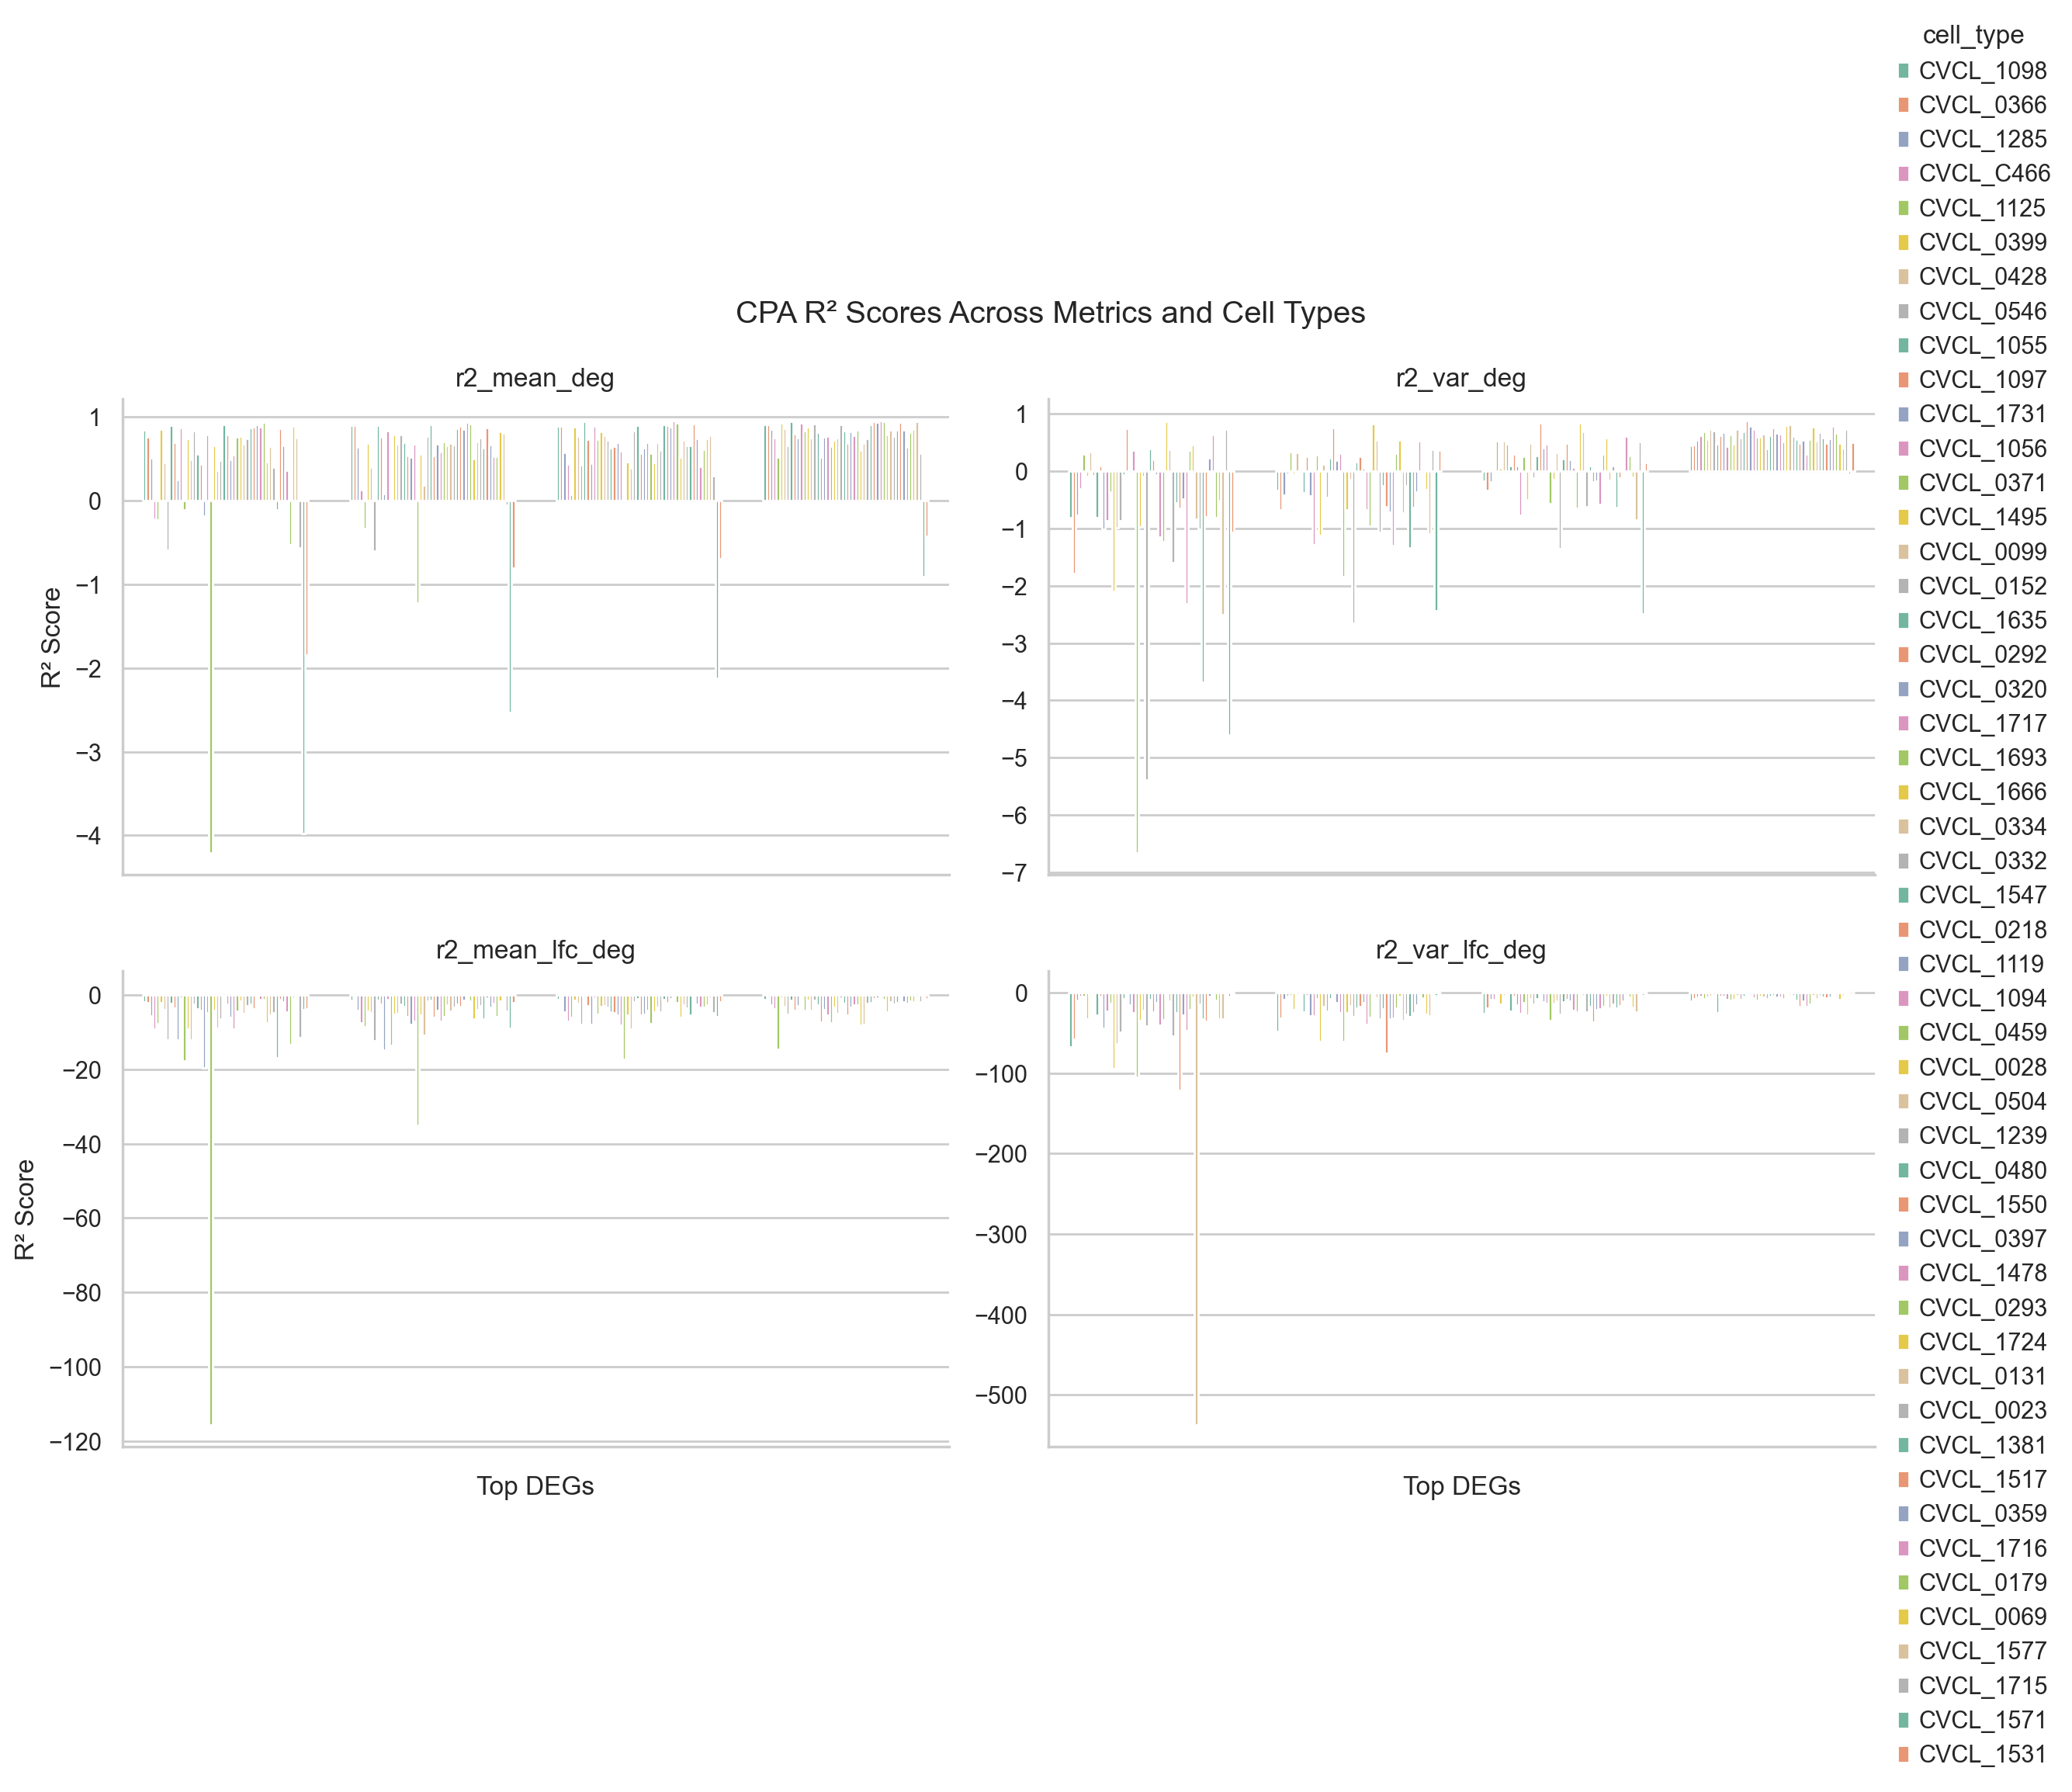

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named `df`

# Convert to long format
df_melted = df.melt(
    id_vars=["condition", "cell_type", "n_top_deg"],
    value_vars=[
        "r2_mean_deg", "r2_var_deg",
        "r2_mean_lfc_deg", "r2_var_lfc_deg"
    ],
    var_name="metric",
    value_name="R2_score"
)

# Plot
sns.set(style="whitegrid", context="notebook")
g = sns.catplot(
    data=df_melted,
    x="n_top_deg", y="R2_score",
    hue="cell_type",
    col="metric",
    kind="bar",
    col_wrap=2,
    height=4, aspect=1.5,
    palette="Set2",
    sharey=False
)

g.set_titles("{col_name}")
g.set_axis_labels("Top DEGs", "R² Score")
g.set_xticklabels(rotation=45)
plt.subplots_adjust(top=0.9)
g.fig.suptitle("CPA R² Scores Across Metrics and Cell Types")
plt.show()


## Plotting: Compare OOD vs ID performance

In [ ]:
ood_cell_type = 'CVCL_0546'
df['is_OOD'] = df['cell_type'] == ood_cell_type


In [ ]:
summary = df.groupby(['n_top_deg', 'is_OOD'])[
    ['r2_mean_deg', 'r2_mean_lfc_deg']
].mean().reset_index()
print(summary)



  n_top_deg  is_OOD  r2_mean_deg  r2_mean_lfc_deg
0        10   False     0.300439        -7.729683
1        10    True    -0.589321       -12.176534
2        20   False     0.493810        -5.077020
3        20    True    -0.604927       -12.355541
4        50   False     0.587975        -3.919206
5        50    True     0.422931        -7.970372
6       all   False     0.747976        -2.959868
7       all    True     0.659273        -5.302560


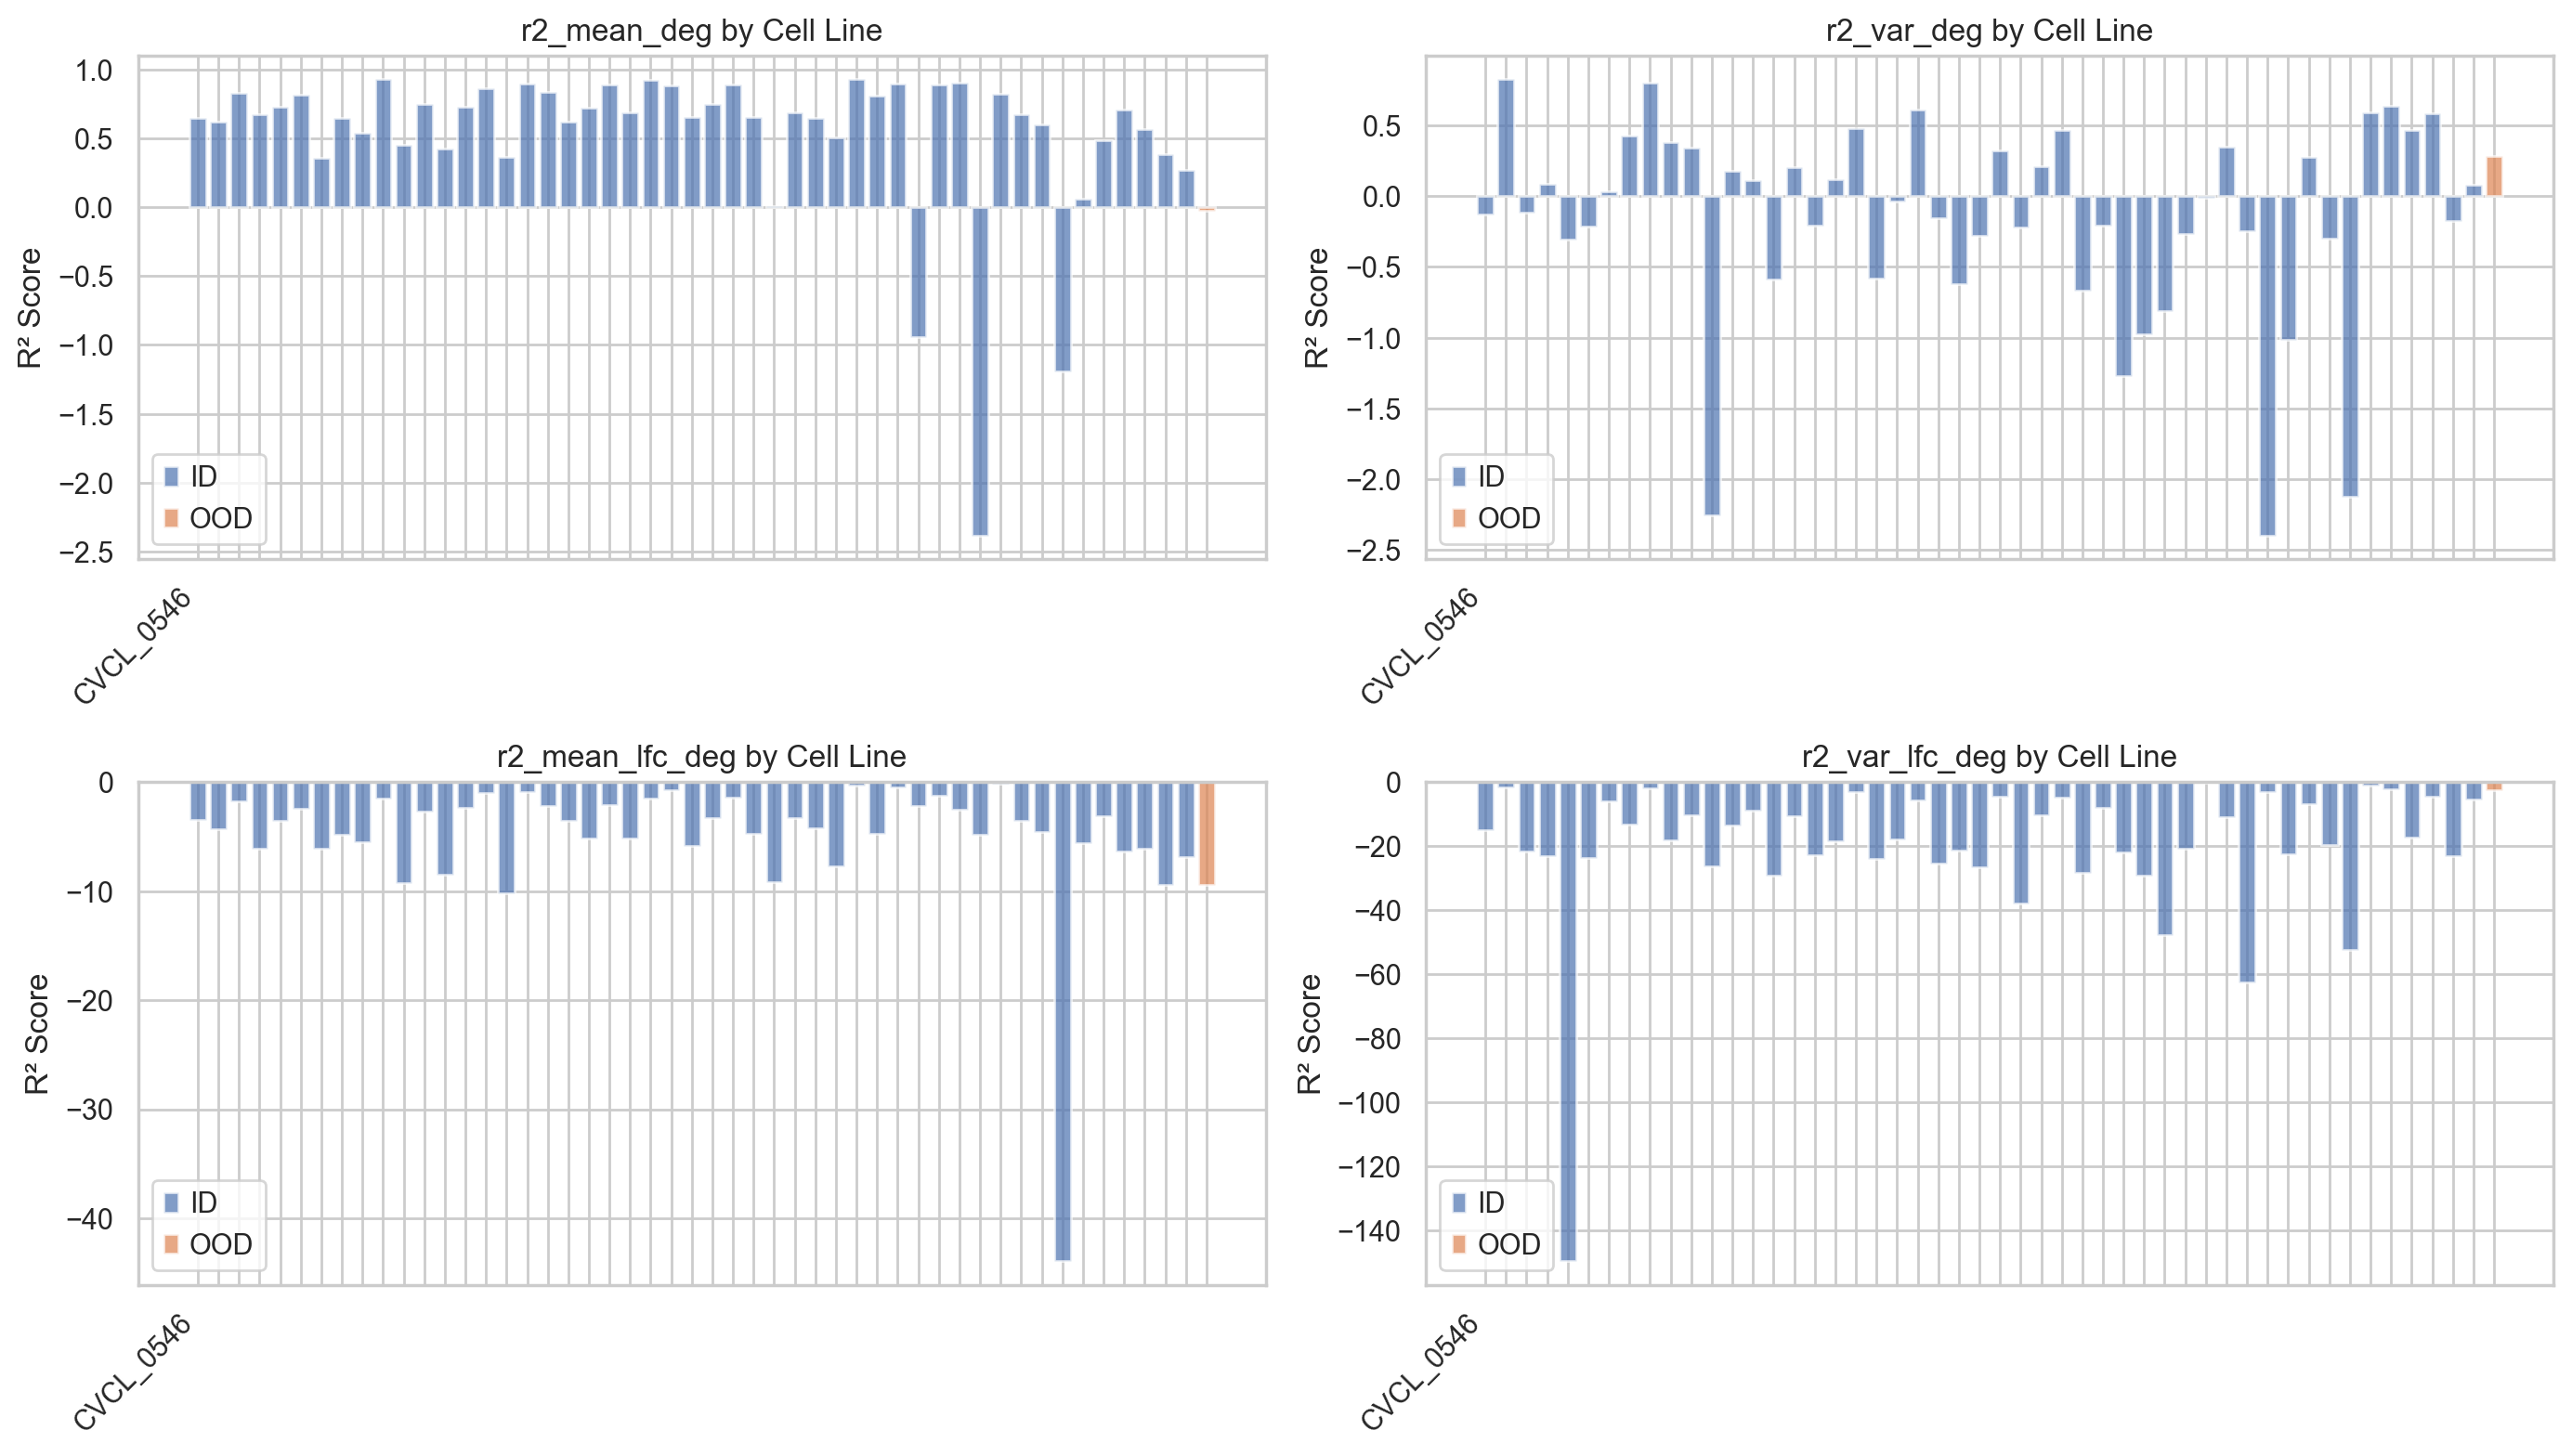

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume df already exists and contains R² results
# Define OOD cell line
ood_cell_line = "CVCL_0546"

# Mark whether each row is OOD or not
df['is_ood'] = df['cell_type'] == ood_cell_line

# Define metrics to visualize
metrics = ['r2_mean_deg', 'r2_var_deg', 'r2_mean_lfc_deg', 'r2_var_lfc_deg']
ncols = 2
nrows = (len(metrics) + 1) // ncols

# Create subplots
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 4 * nrows))
axs = axs.flatten()

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axs[i]
    summary = df.groupby(['is_ood', 'cell_type'])[metric].mean().reset_index()
    summary['OOD status'] = summary['is_ood'].map({True: 'OOD', False: 'ID'})
    
    for ood_status, group in summary.groupby('OOD status'):
        ax.bar(group['cell_type'], group[metric], label=ood_status, alpha=0.7)

    ax.set_title(f"{metric} by Cell Line")
    ax.set_ylabel("R² Score")
    ax.set_xticklabels(group['cell_type'], rotation=45, ha='right')
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


### CPA Prediction vs True for Stimulated per Cell Line
Diagonal alignment → Good agreement between CPA predictions and true data.

Points above the line → CPA overestimates gene expression.

Points below the line → CPA underestimates gene expression.

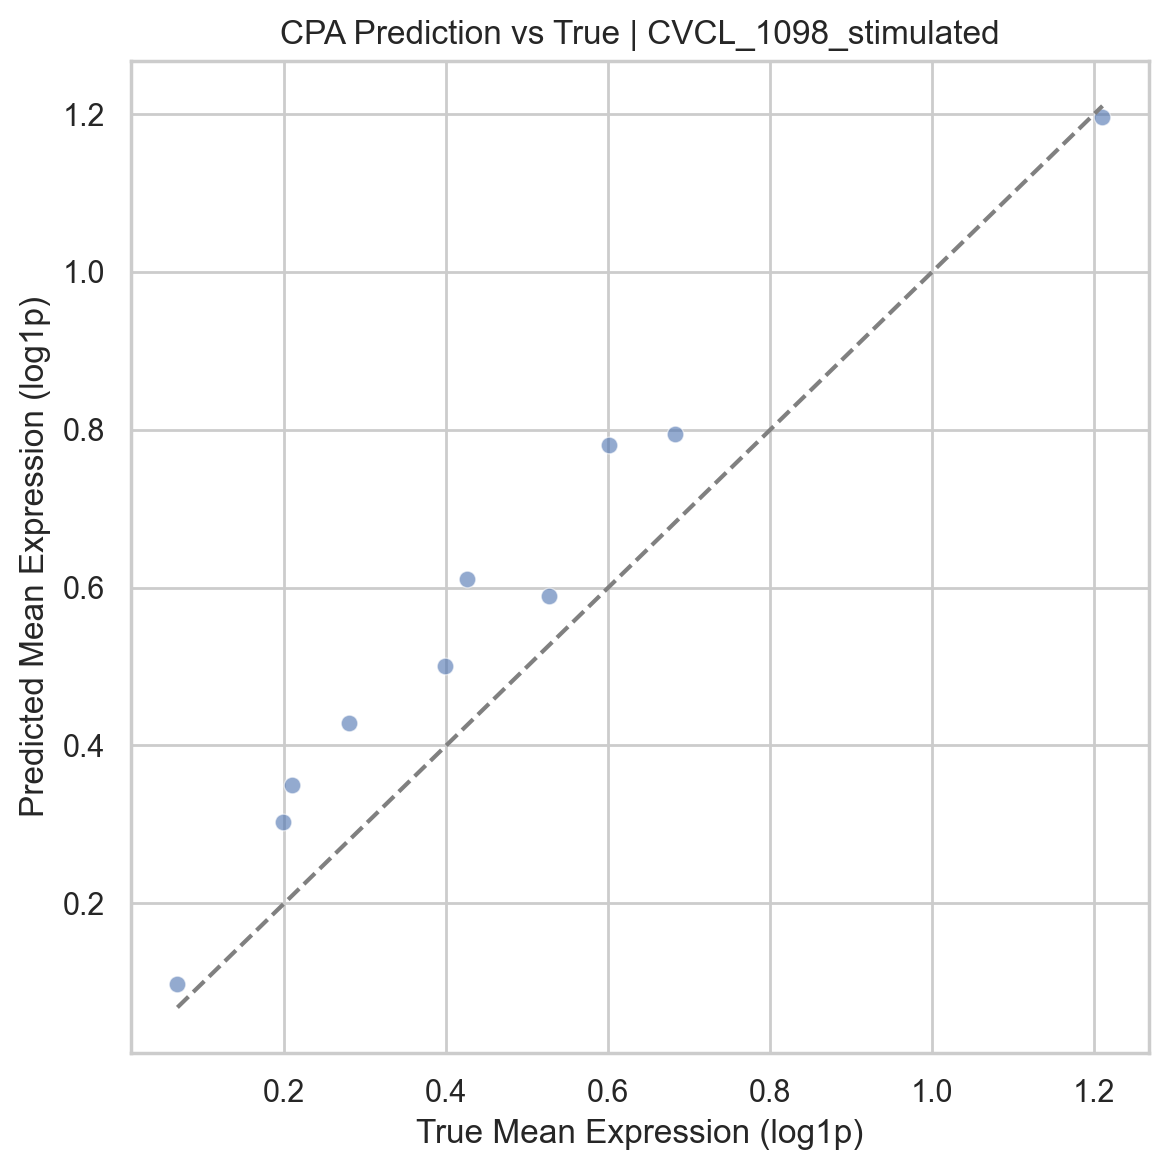

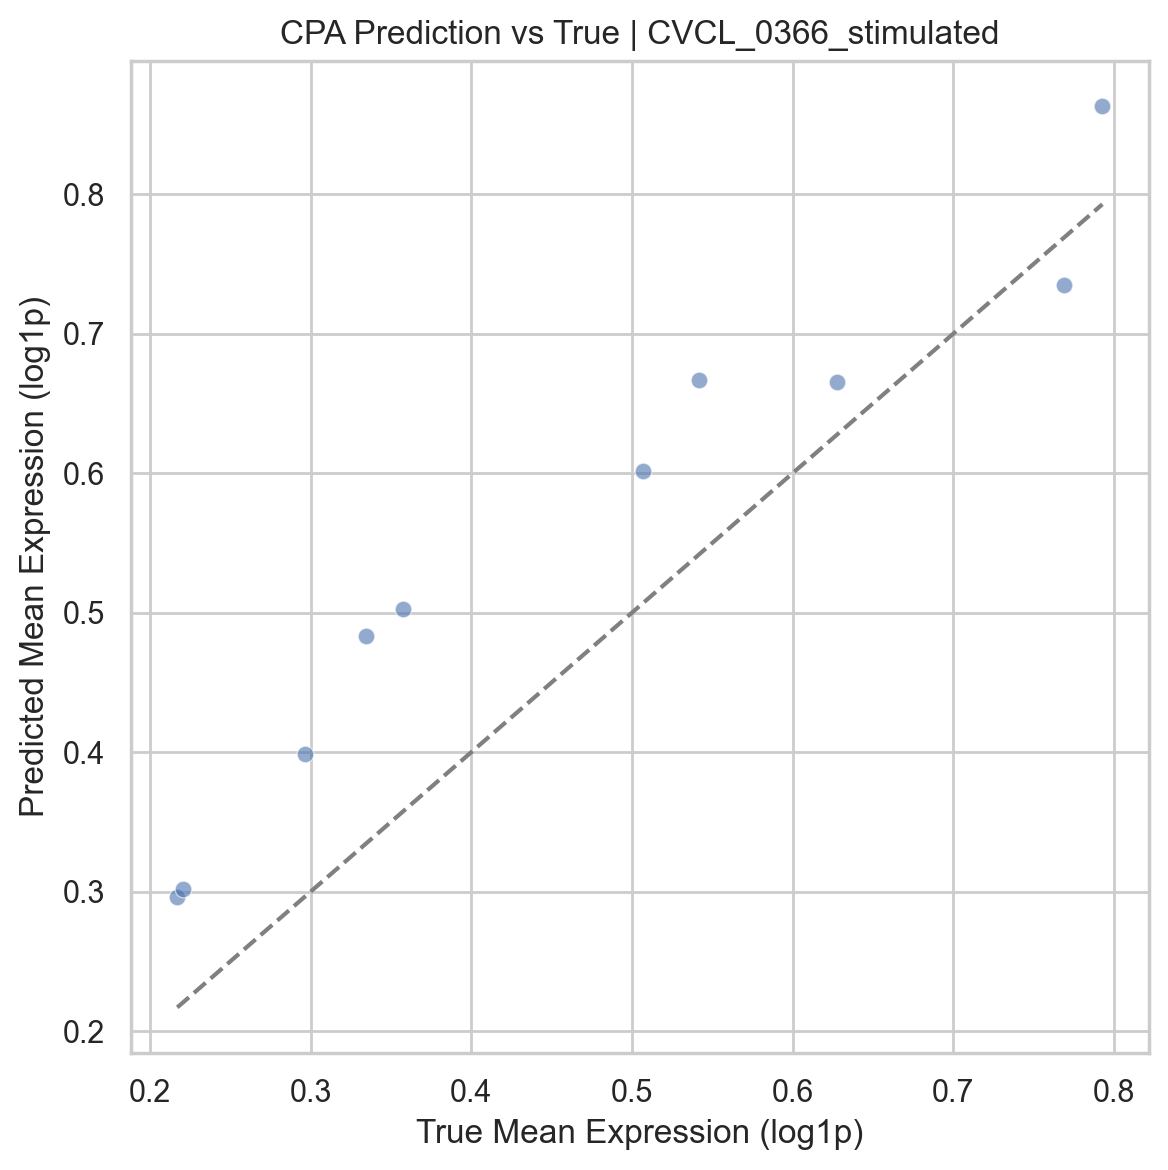

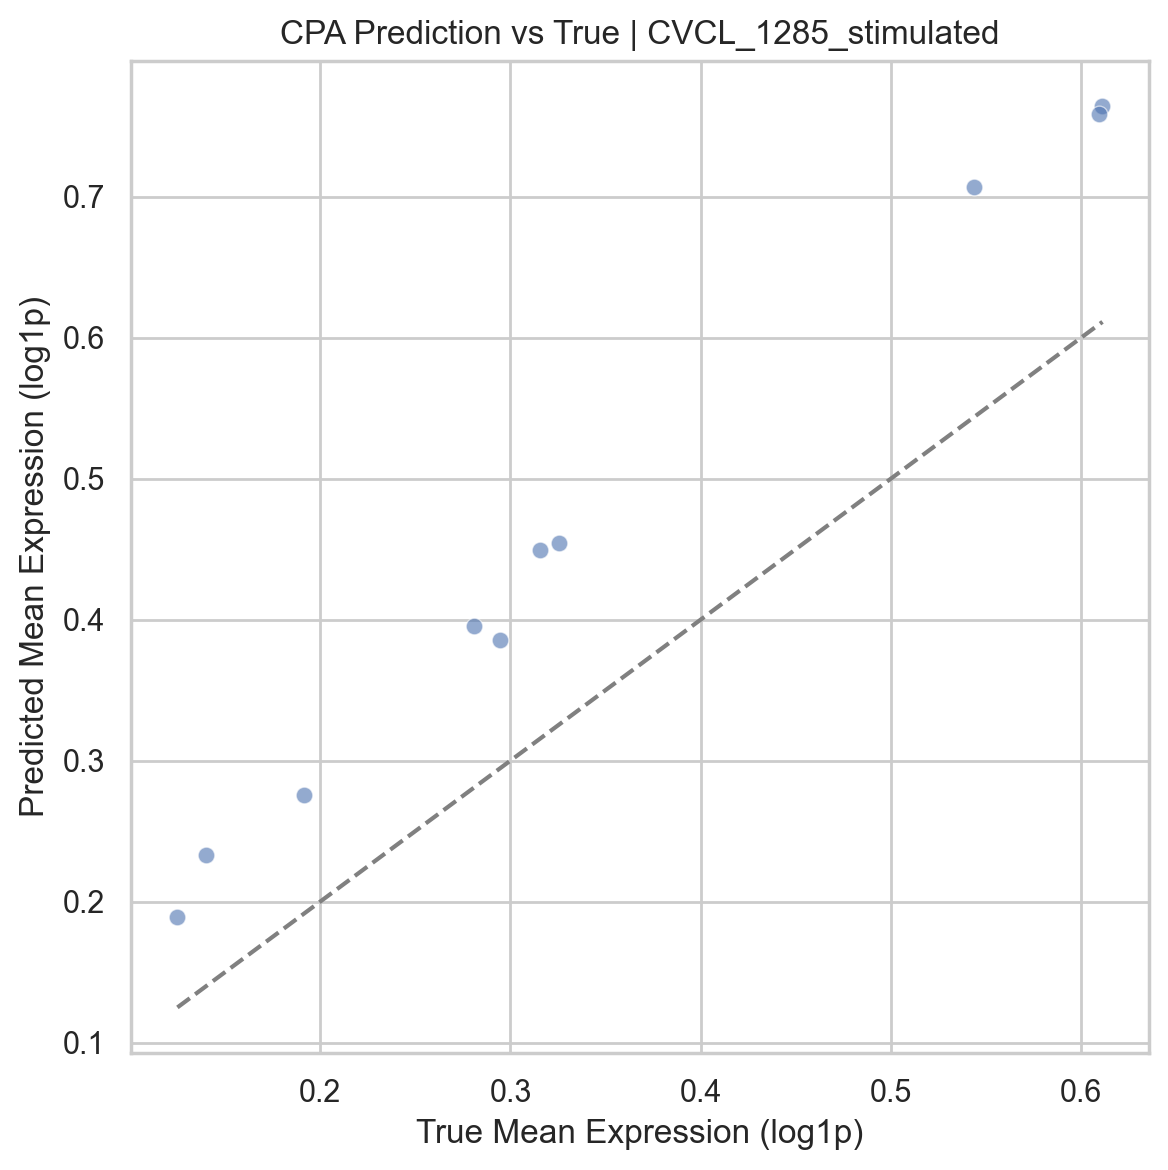

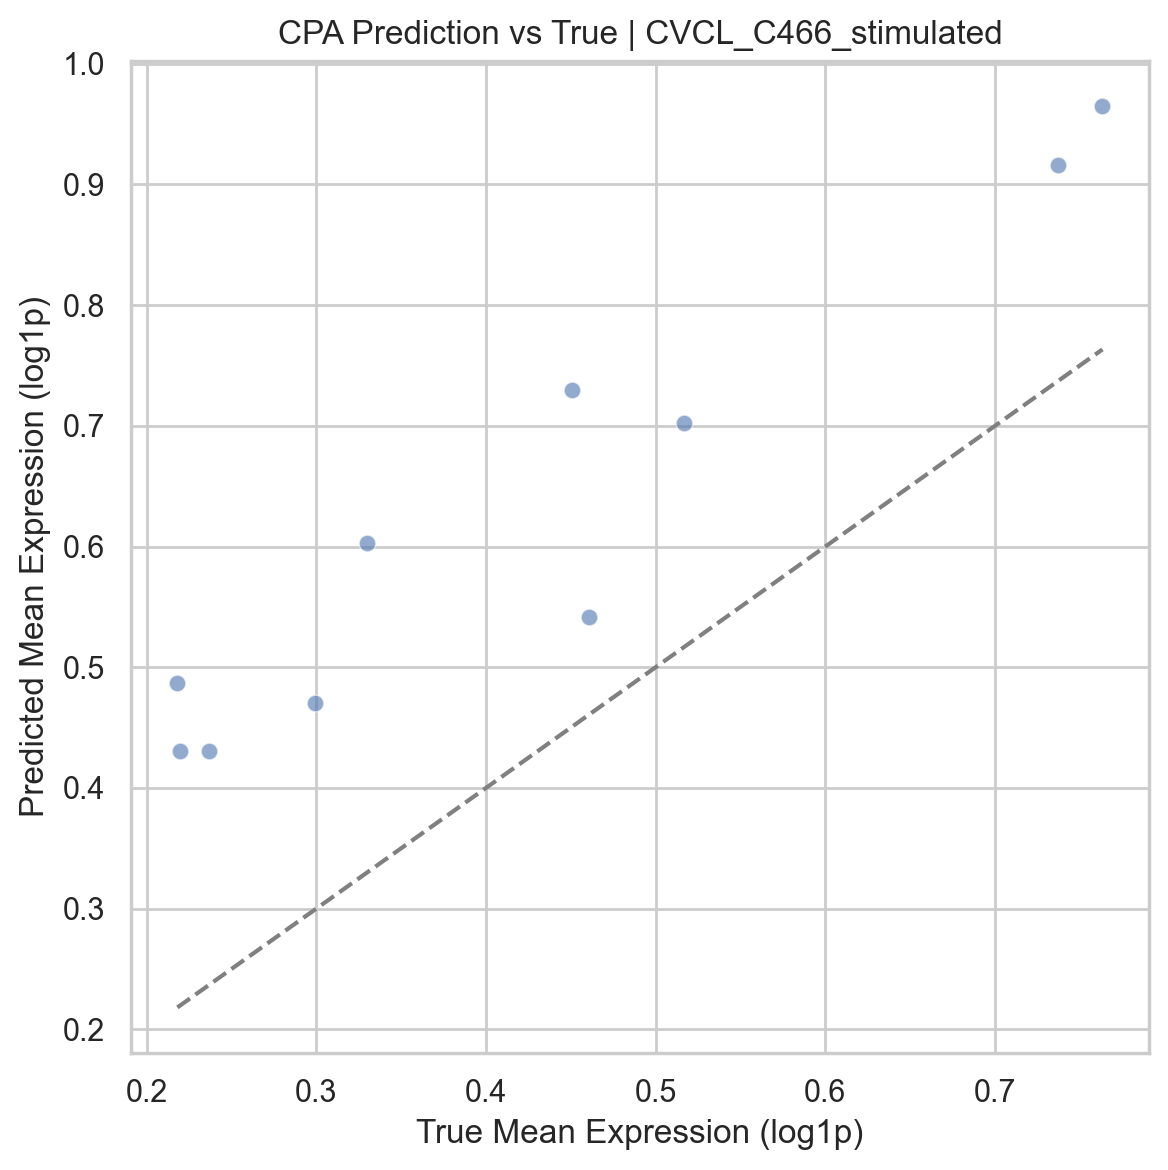

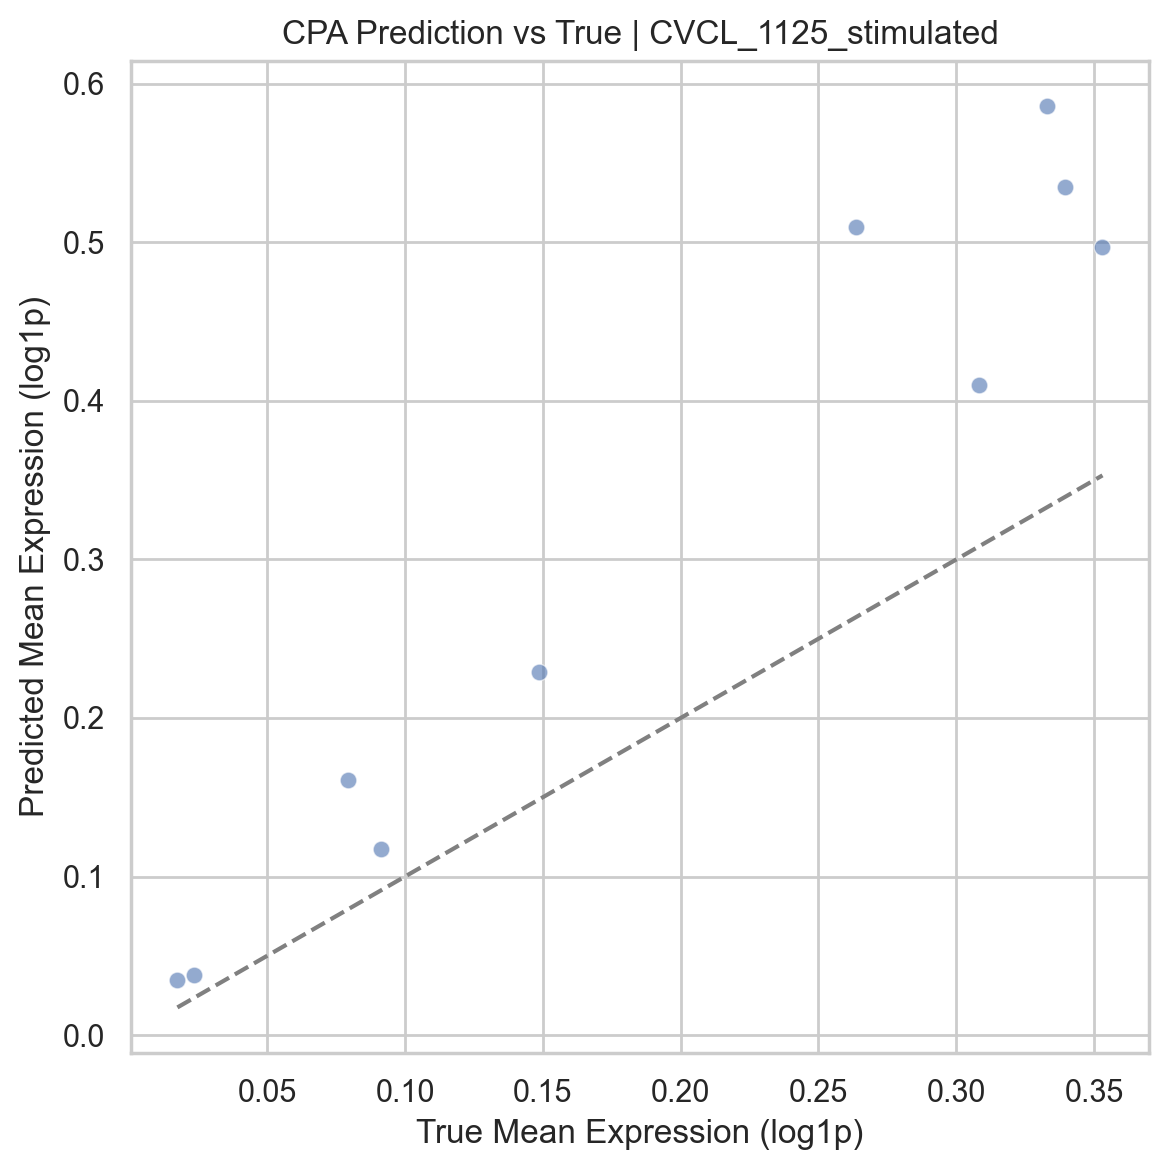

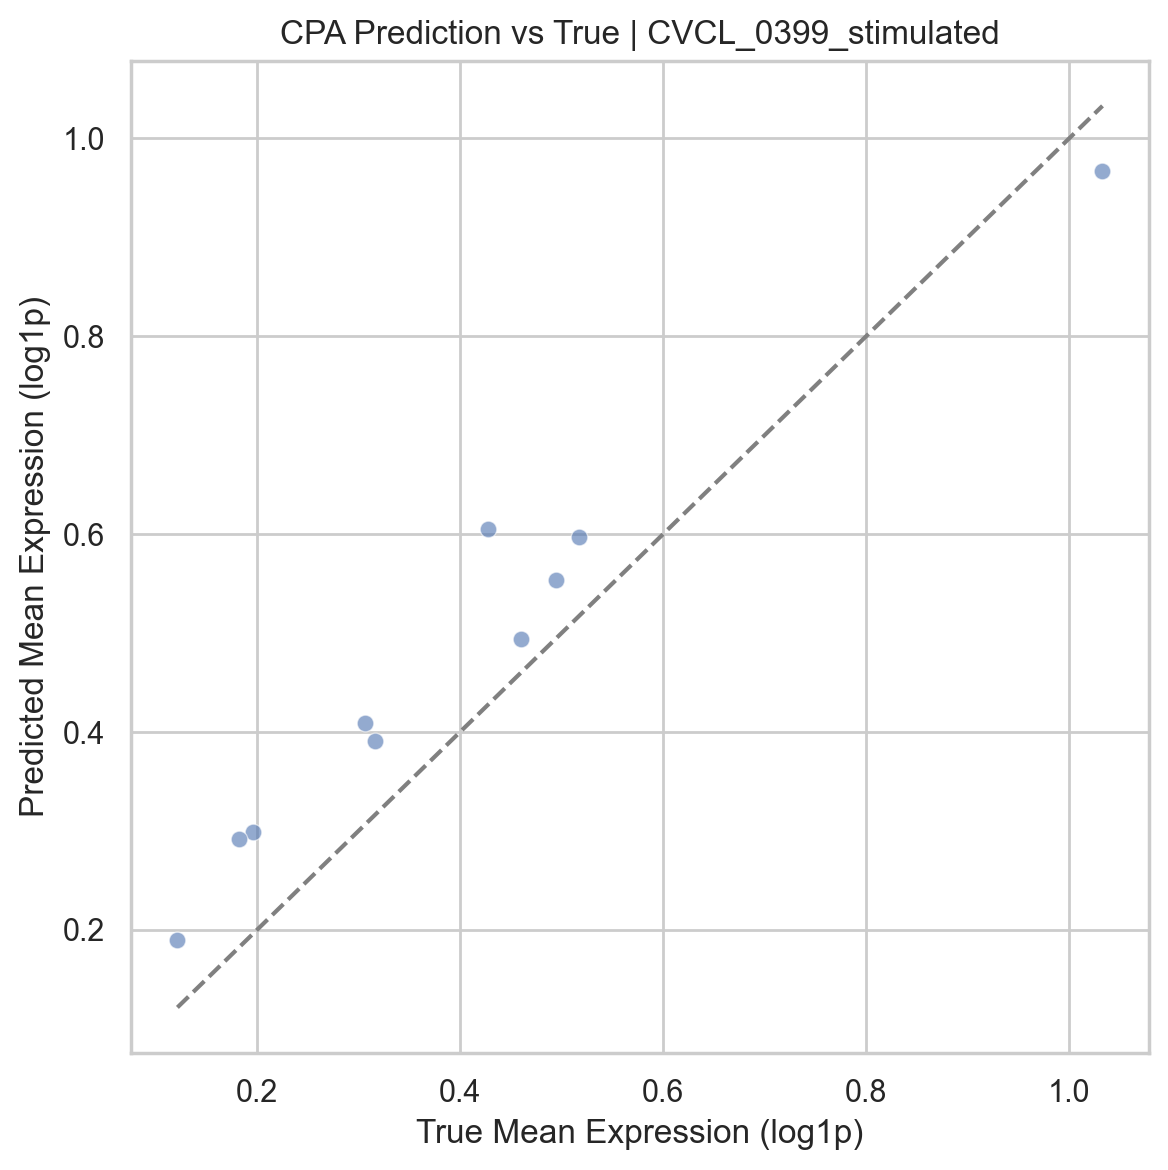

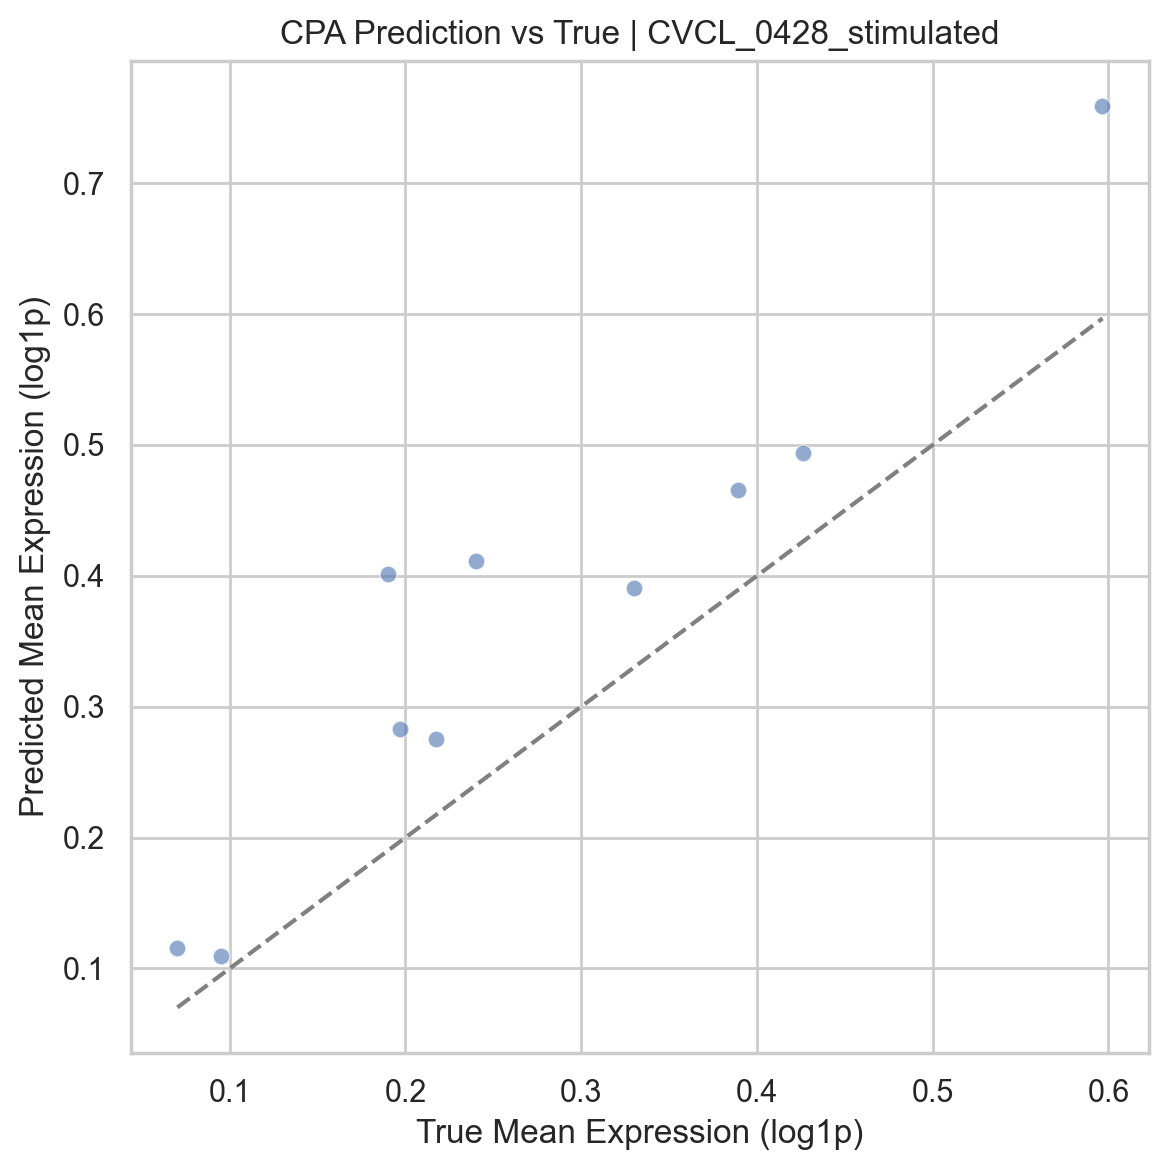

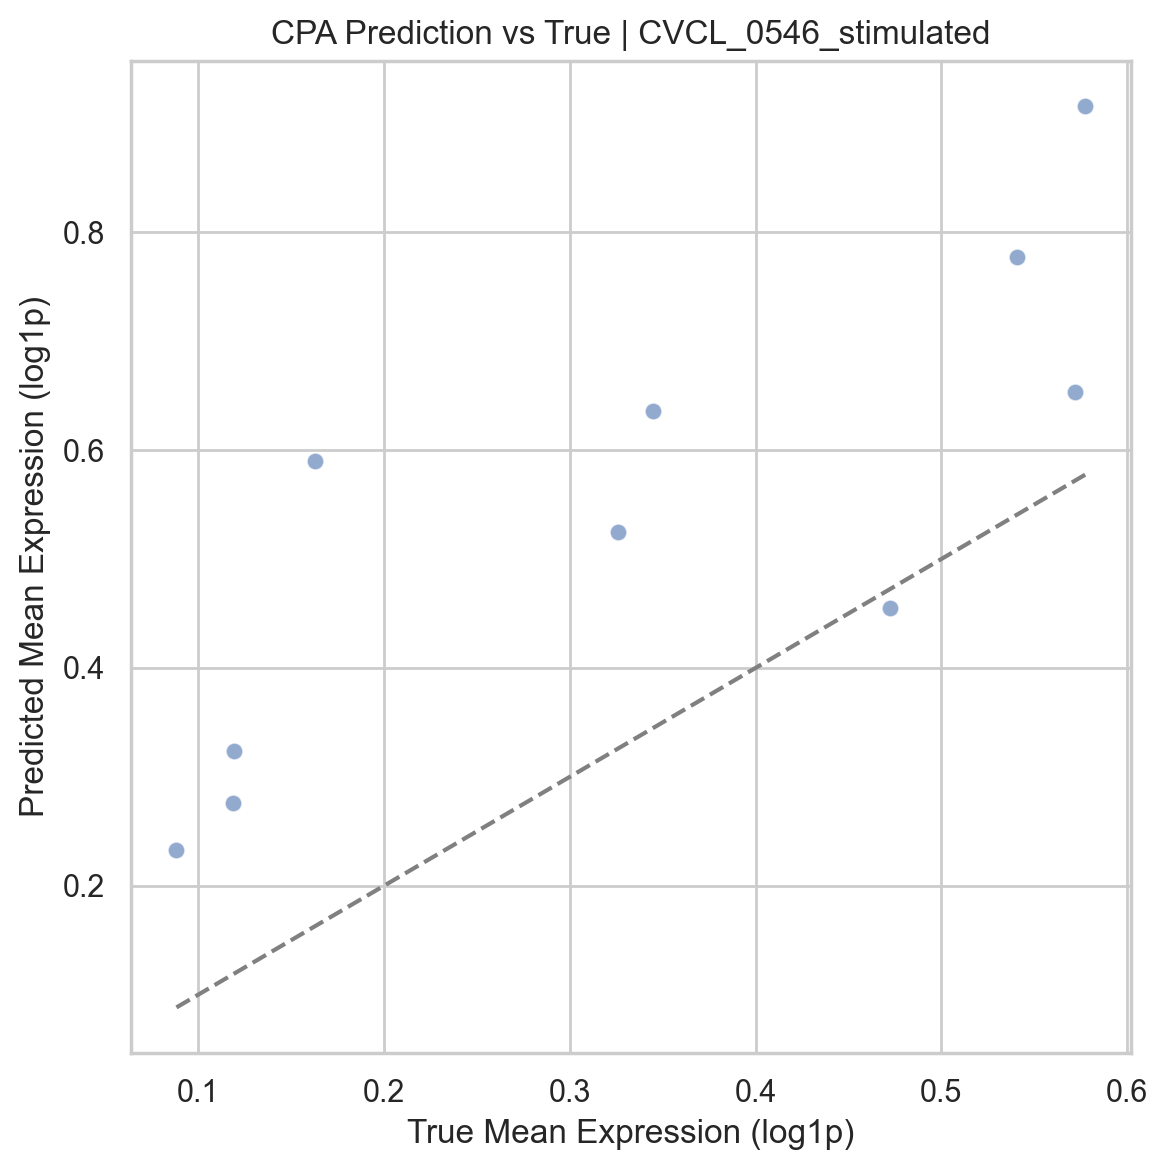

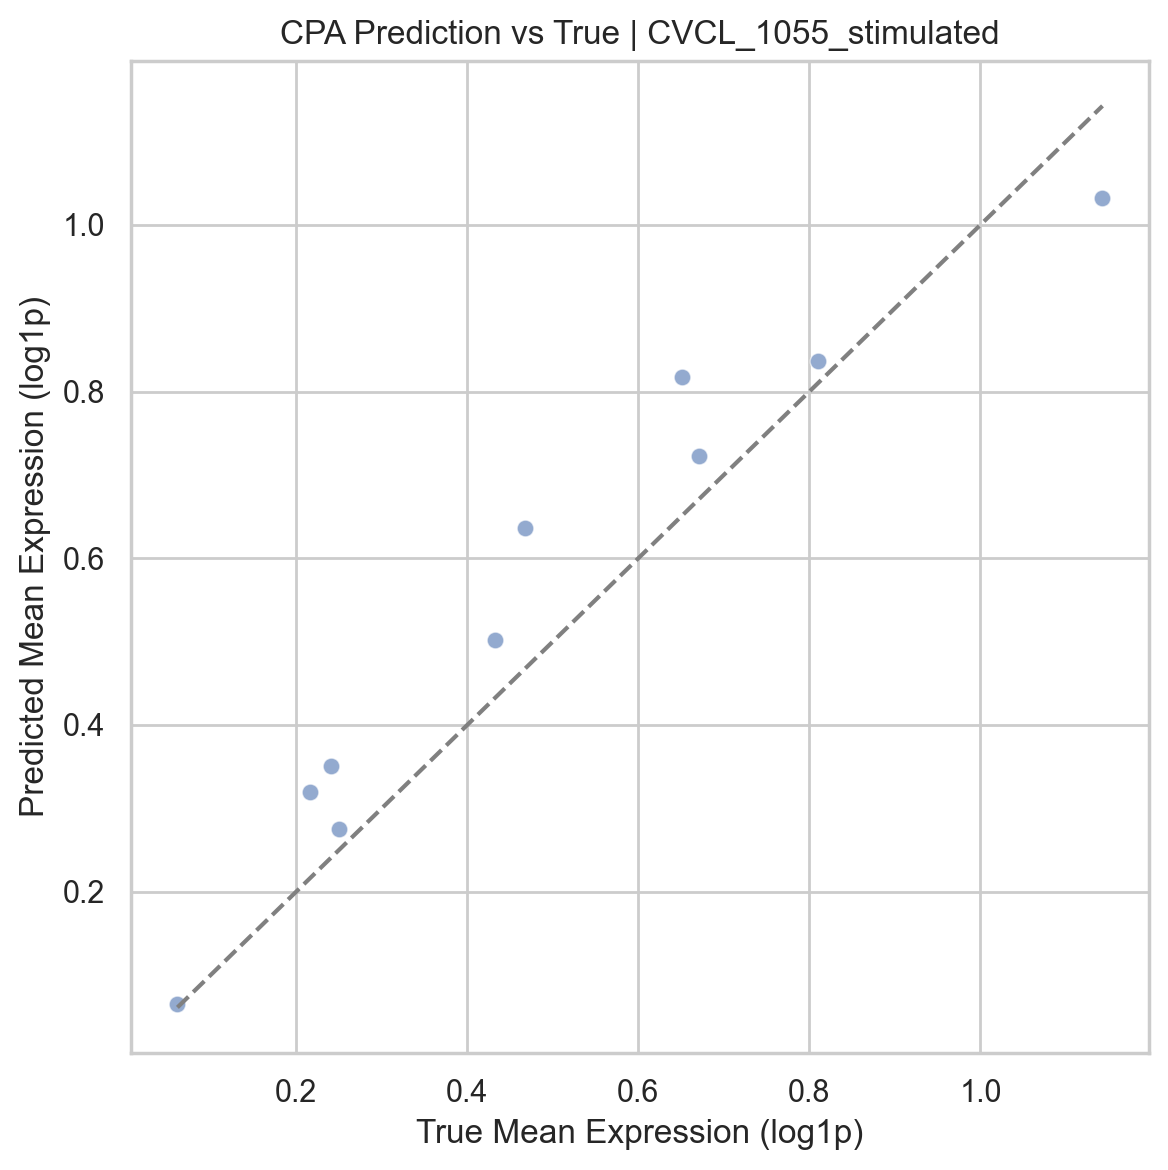

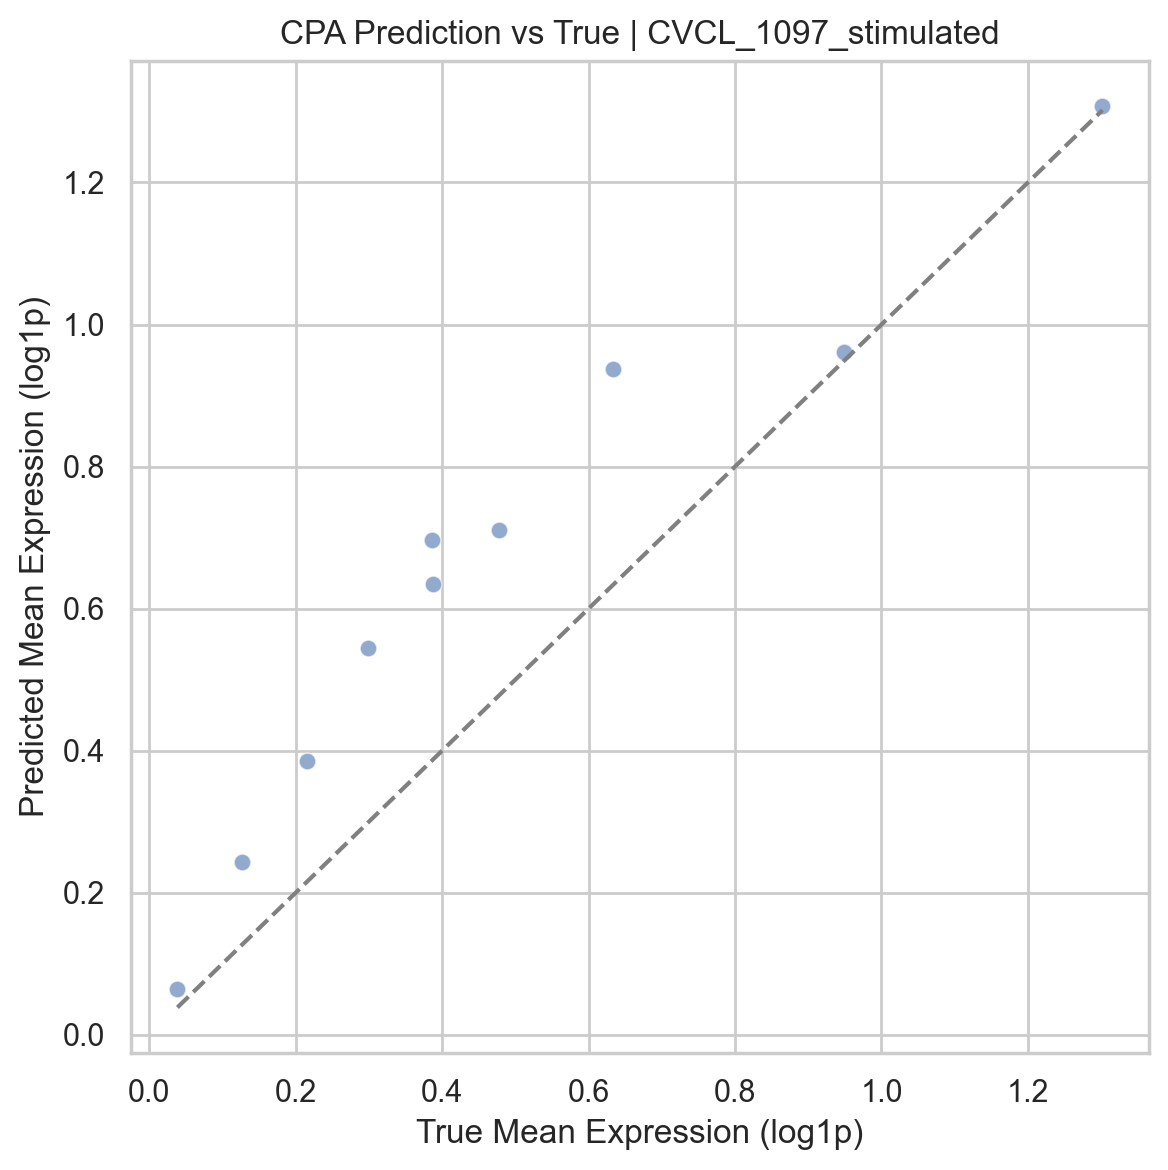

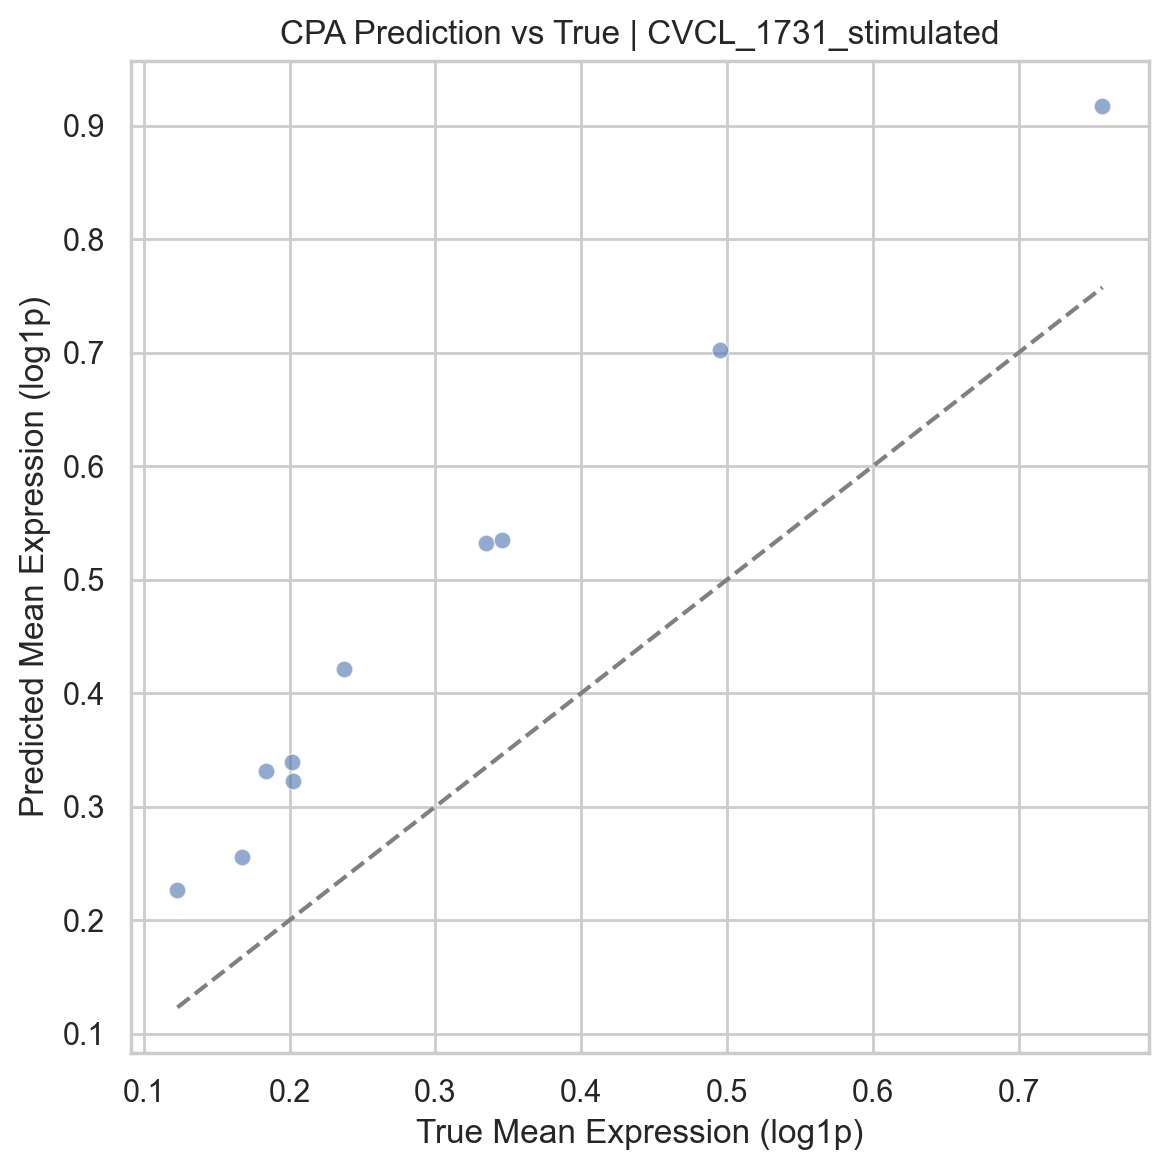

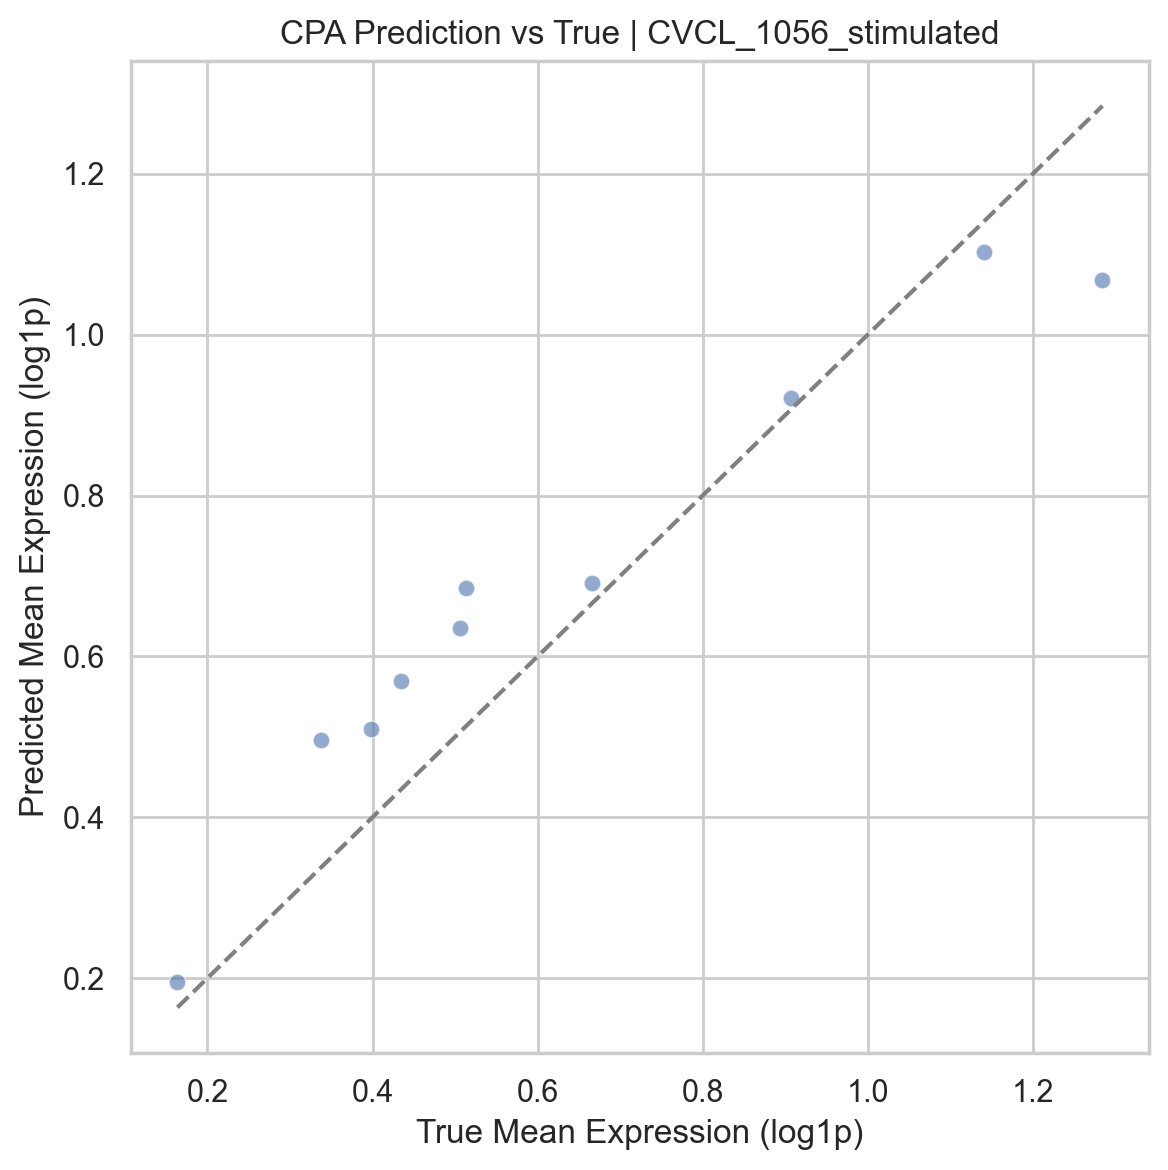

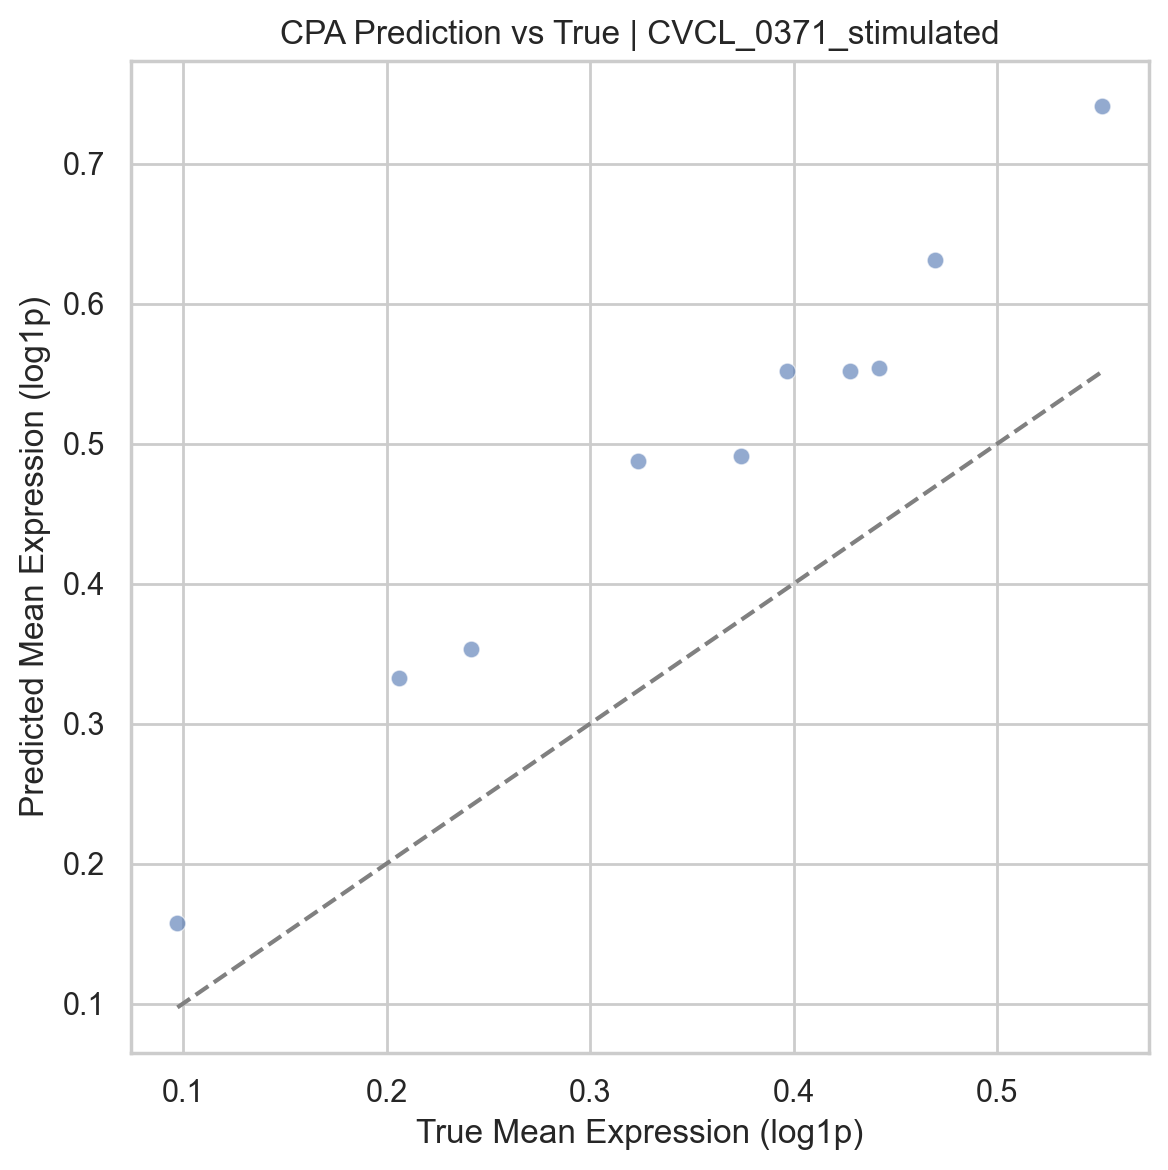

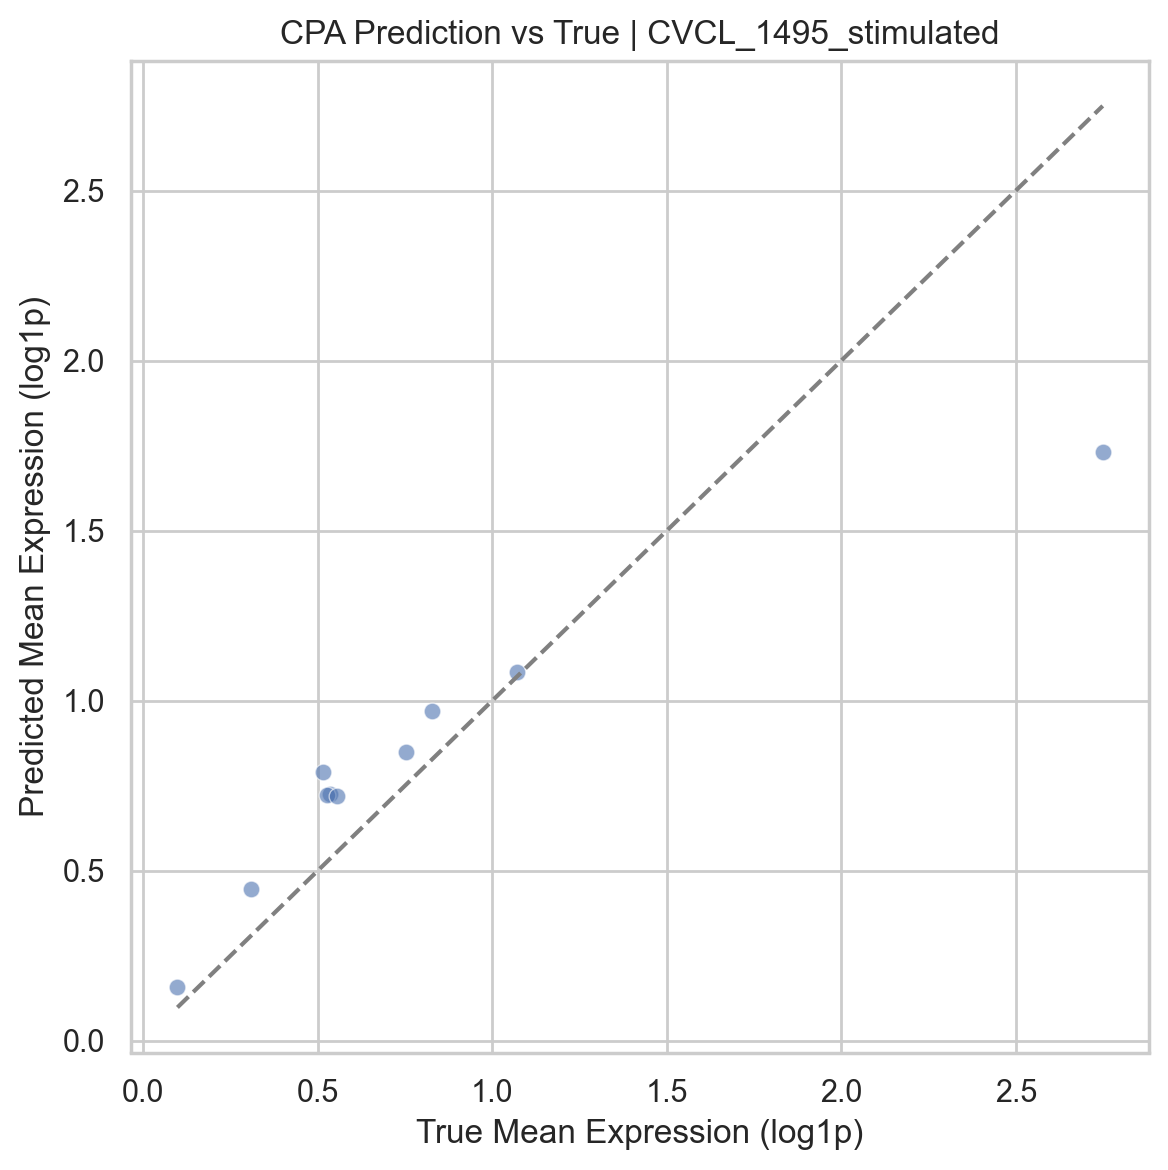

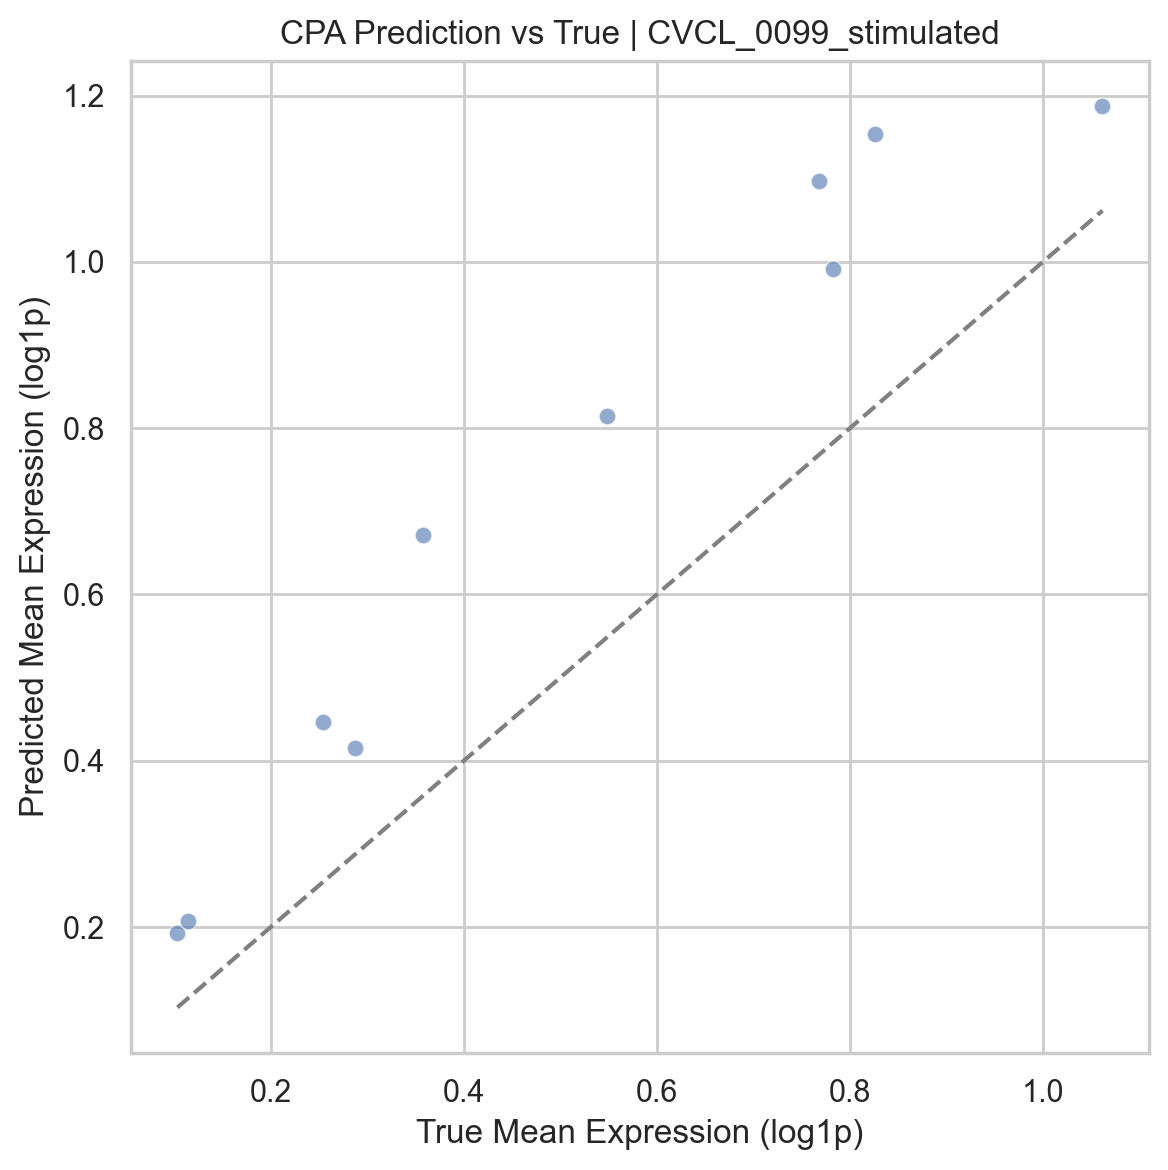

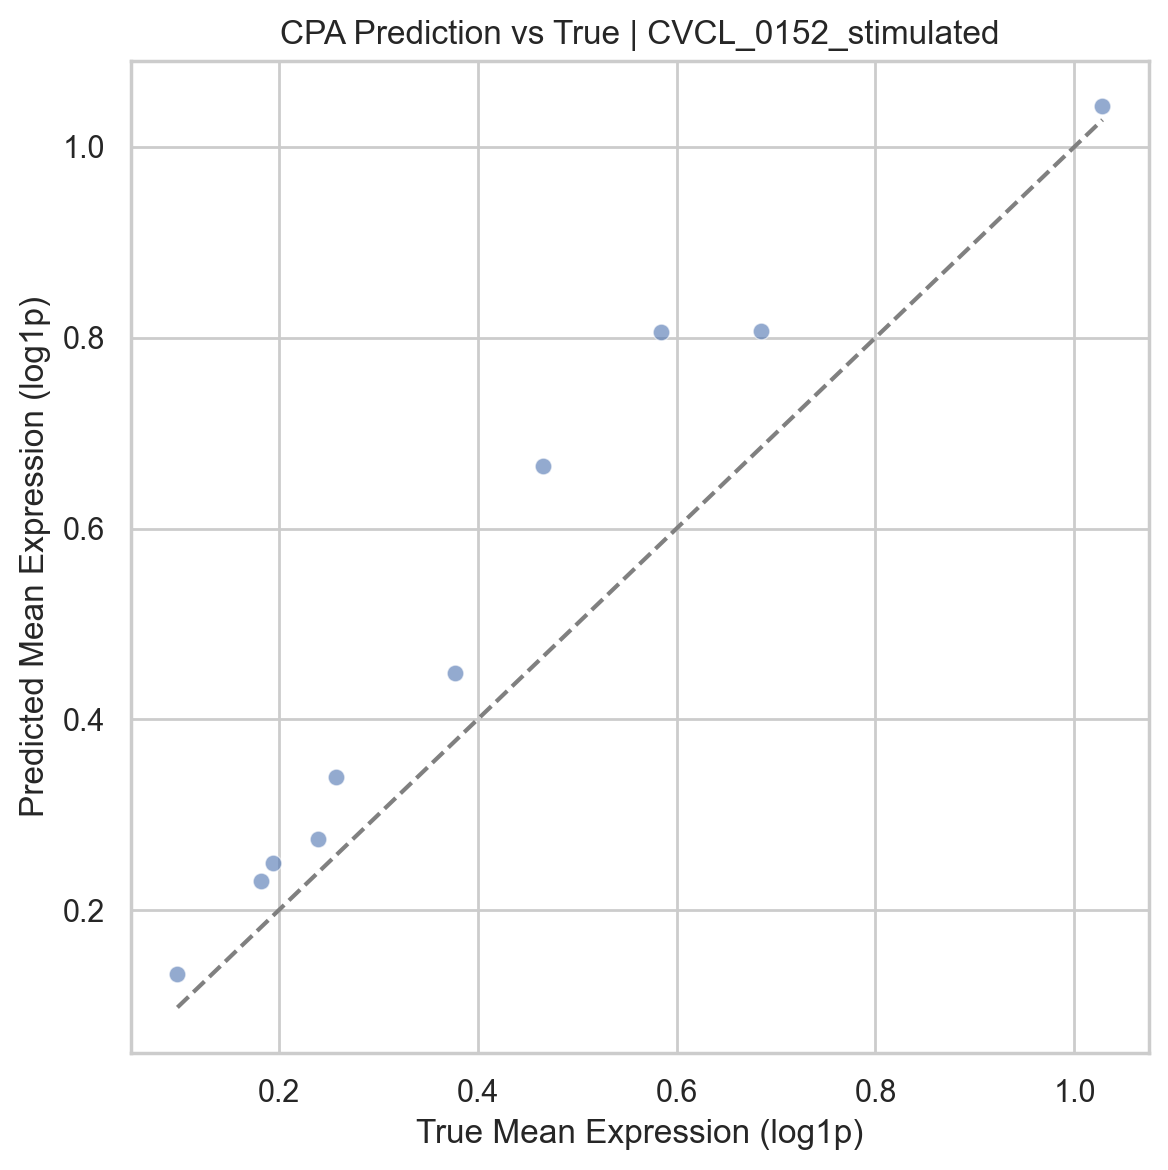

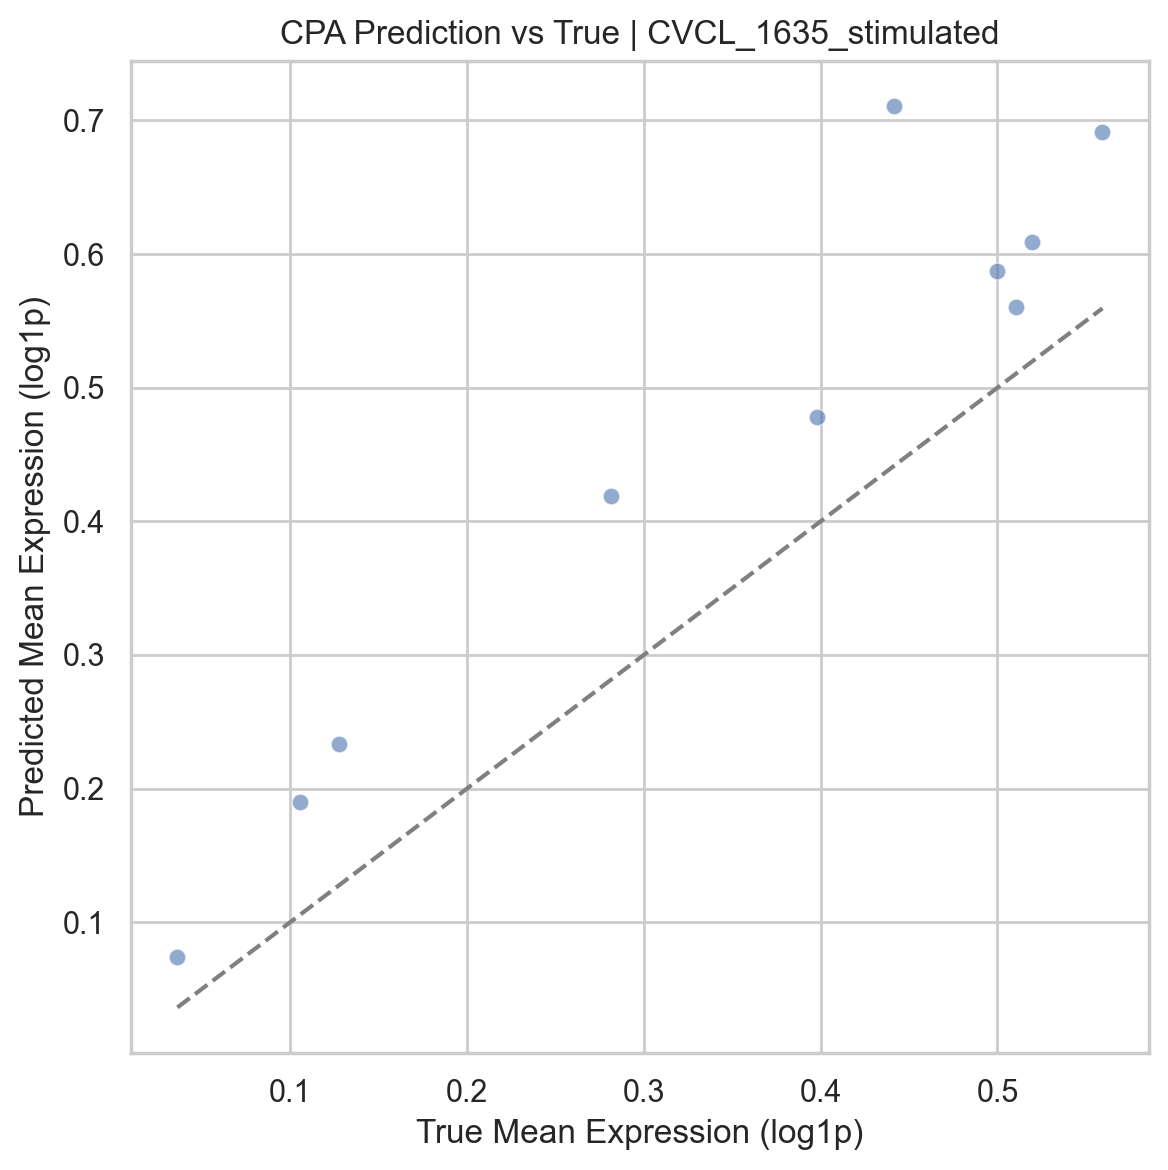

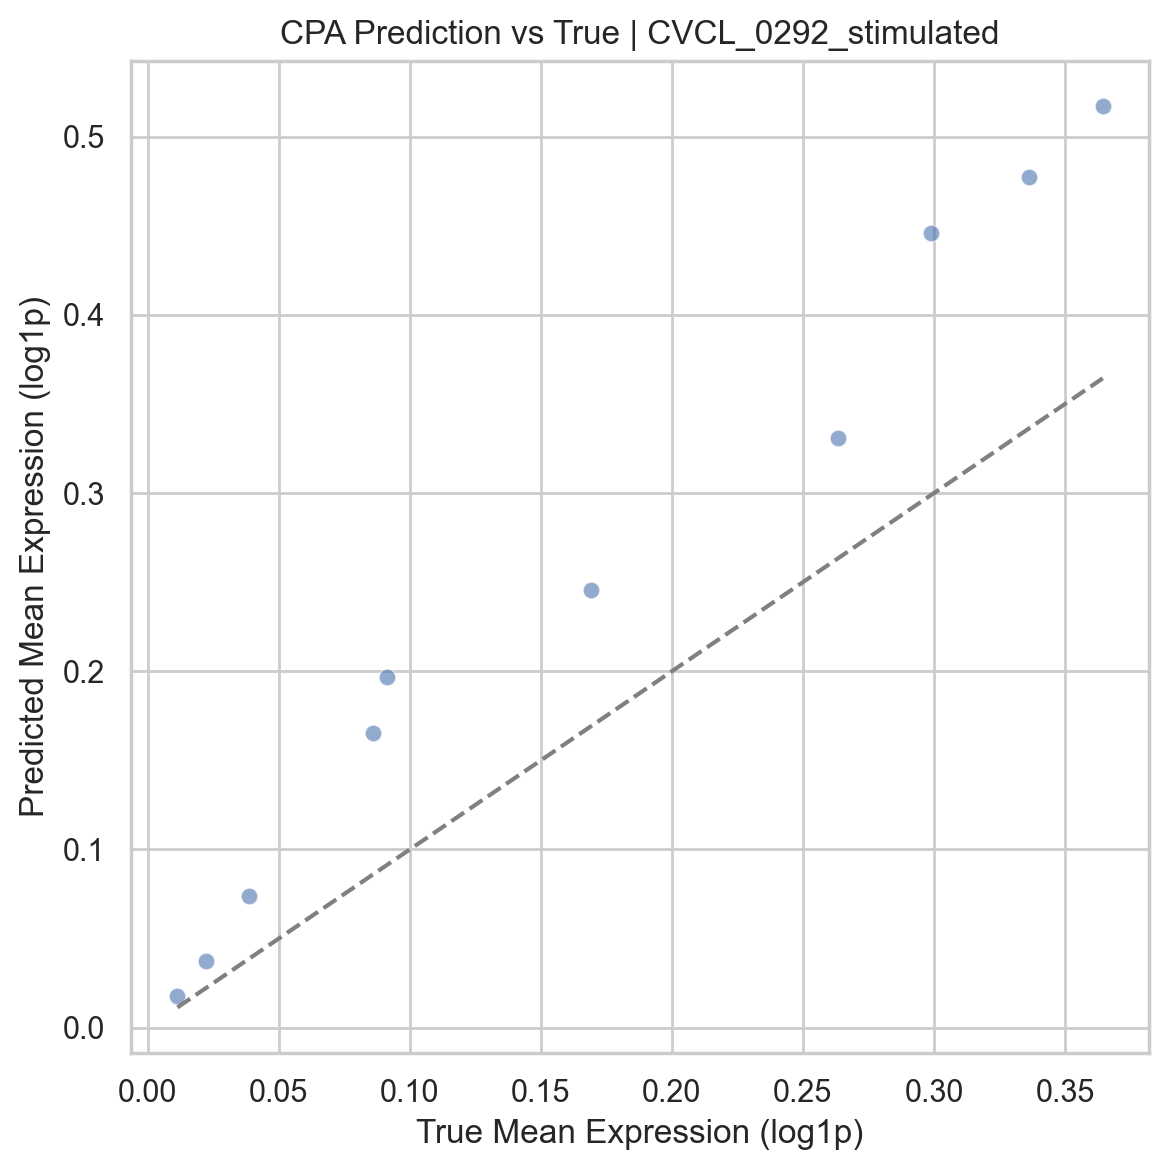

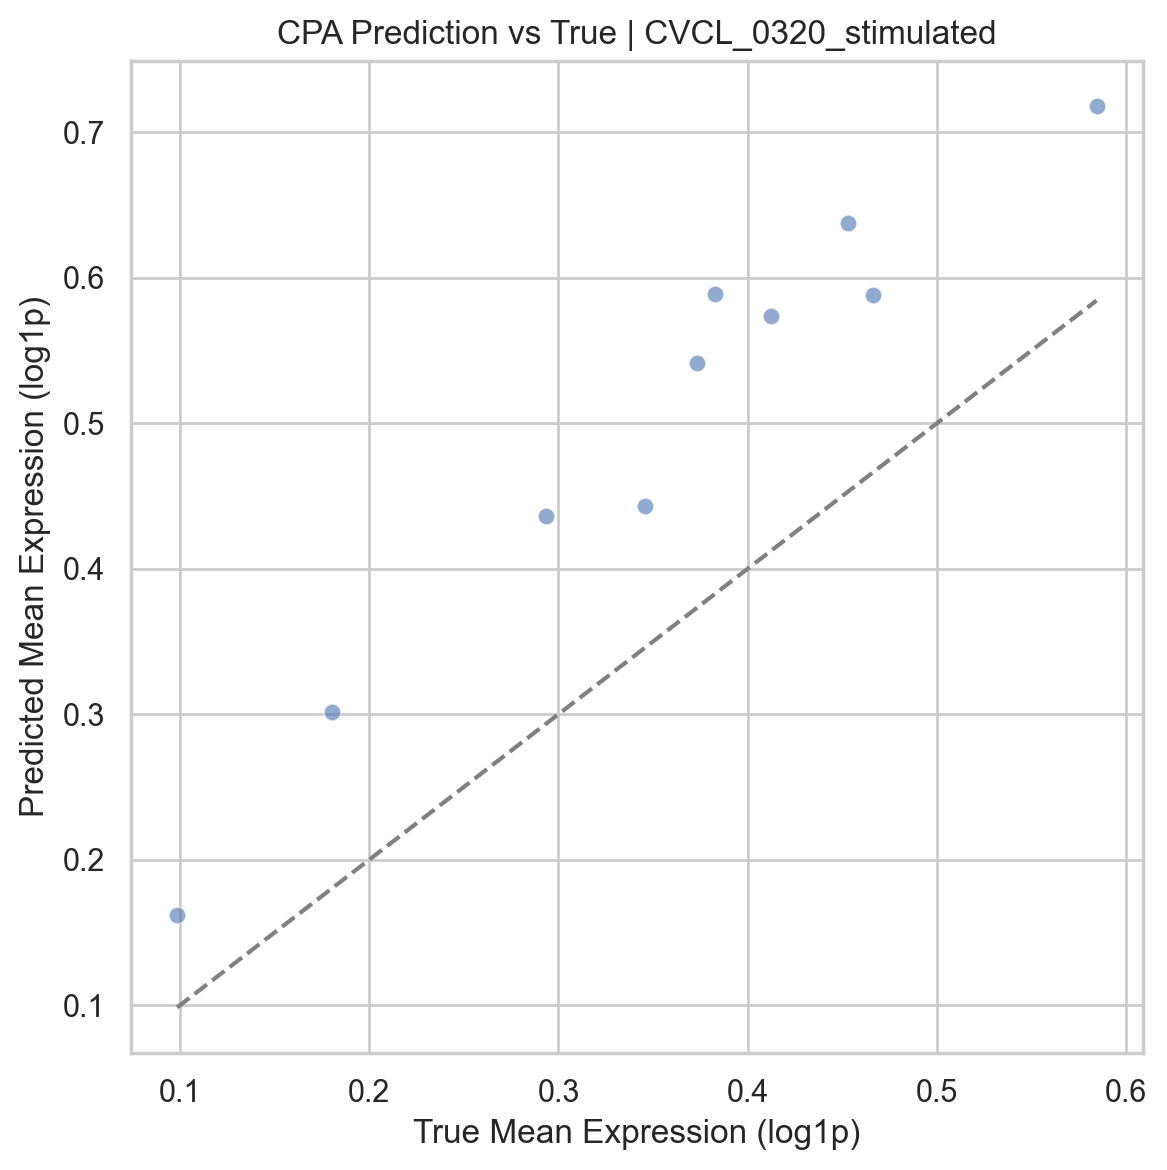

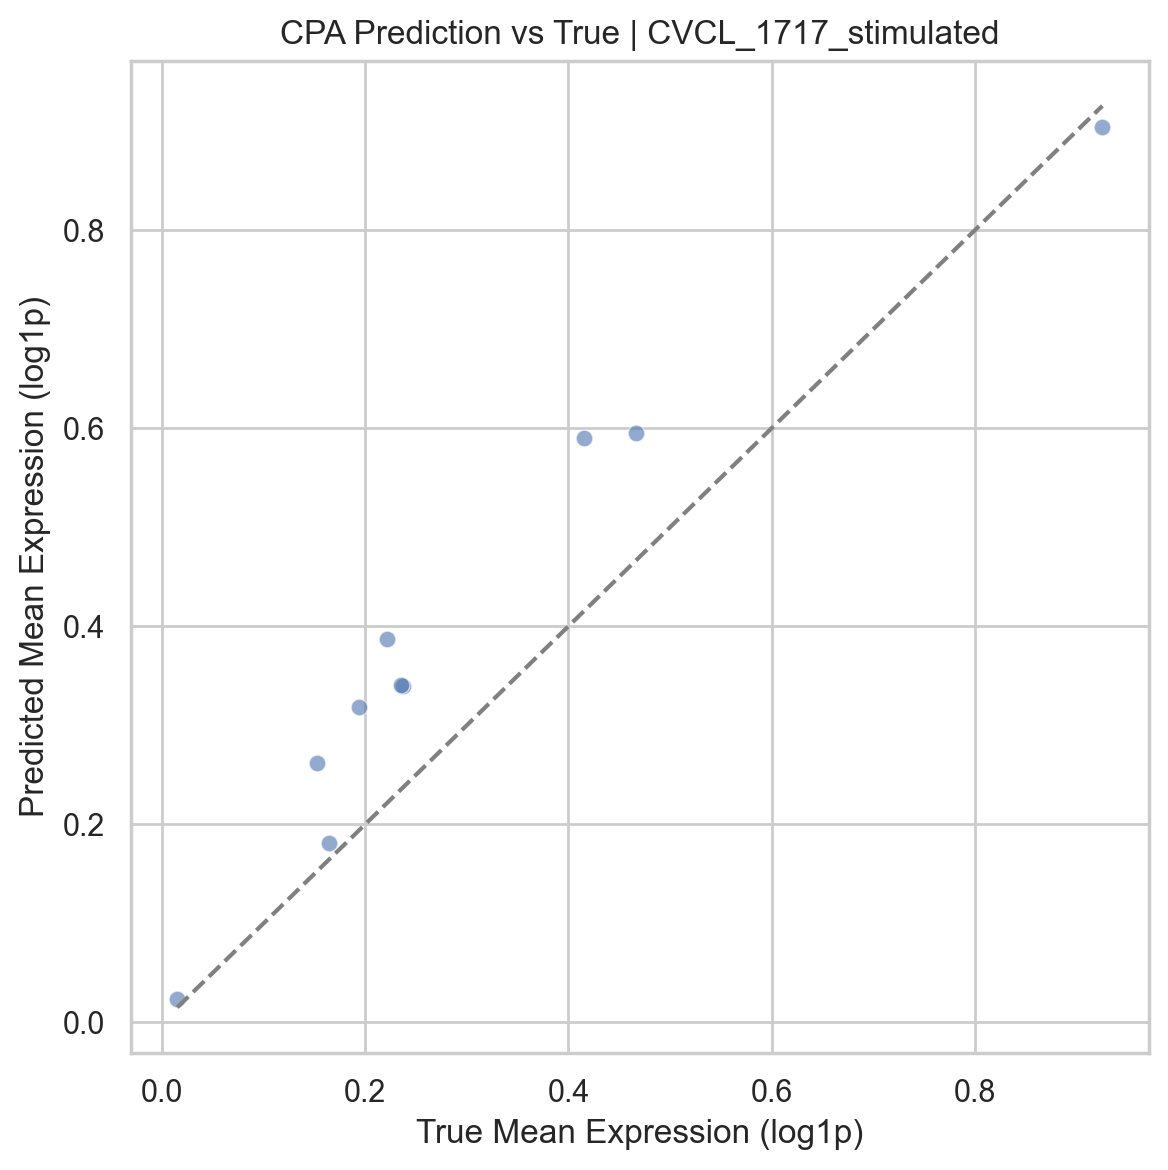

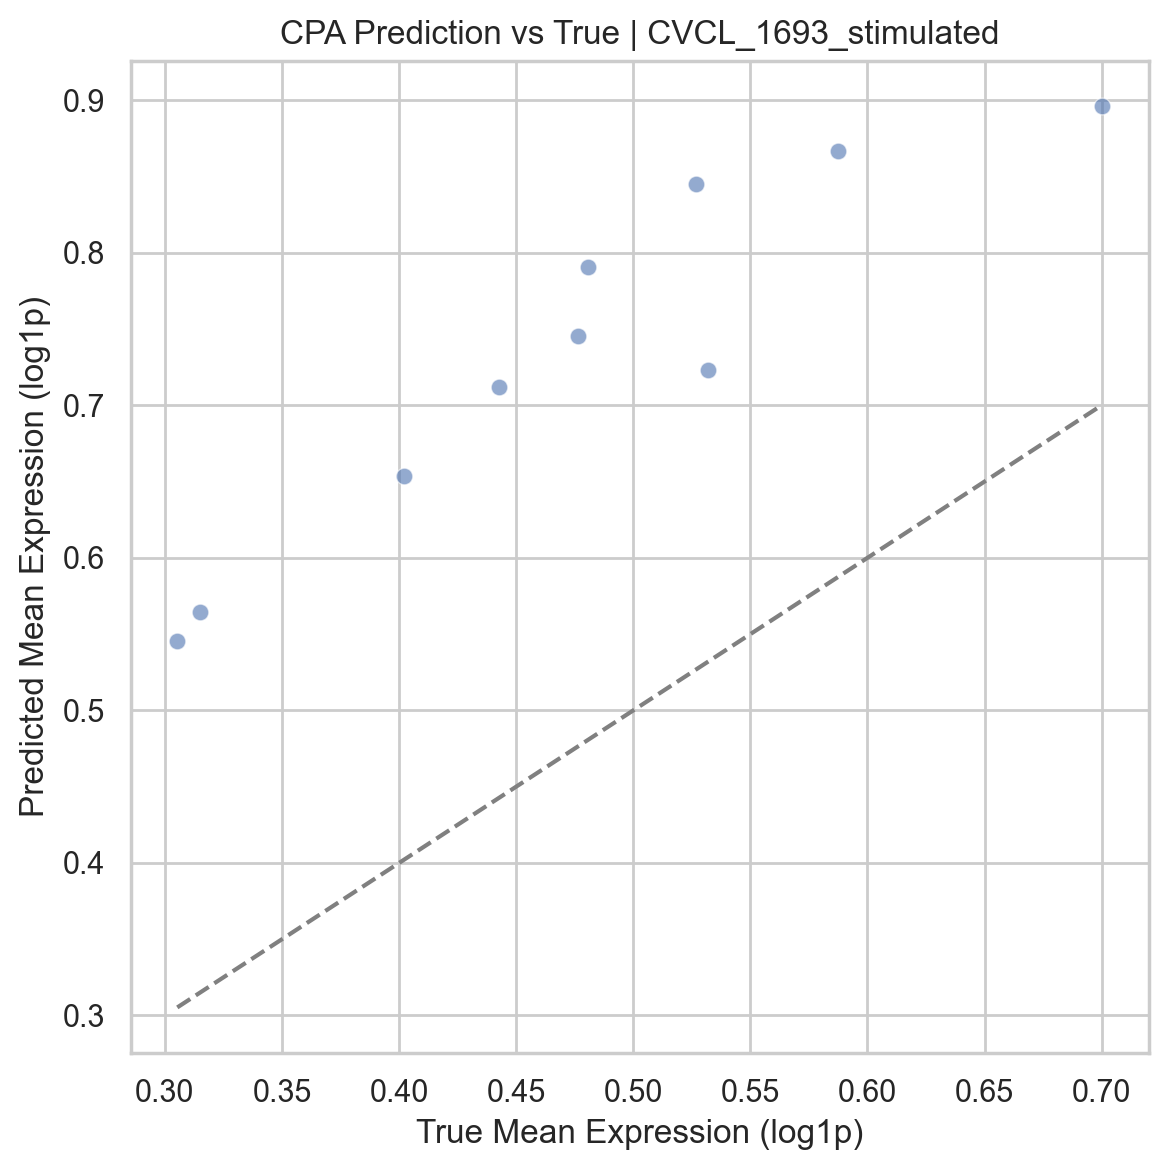

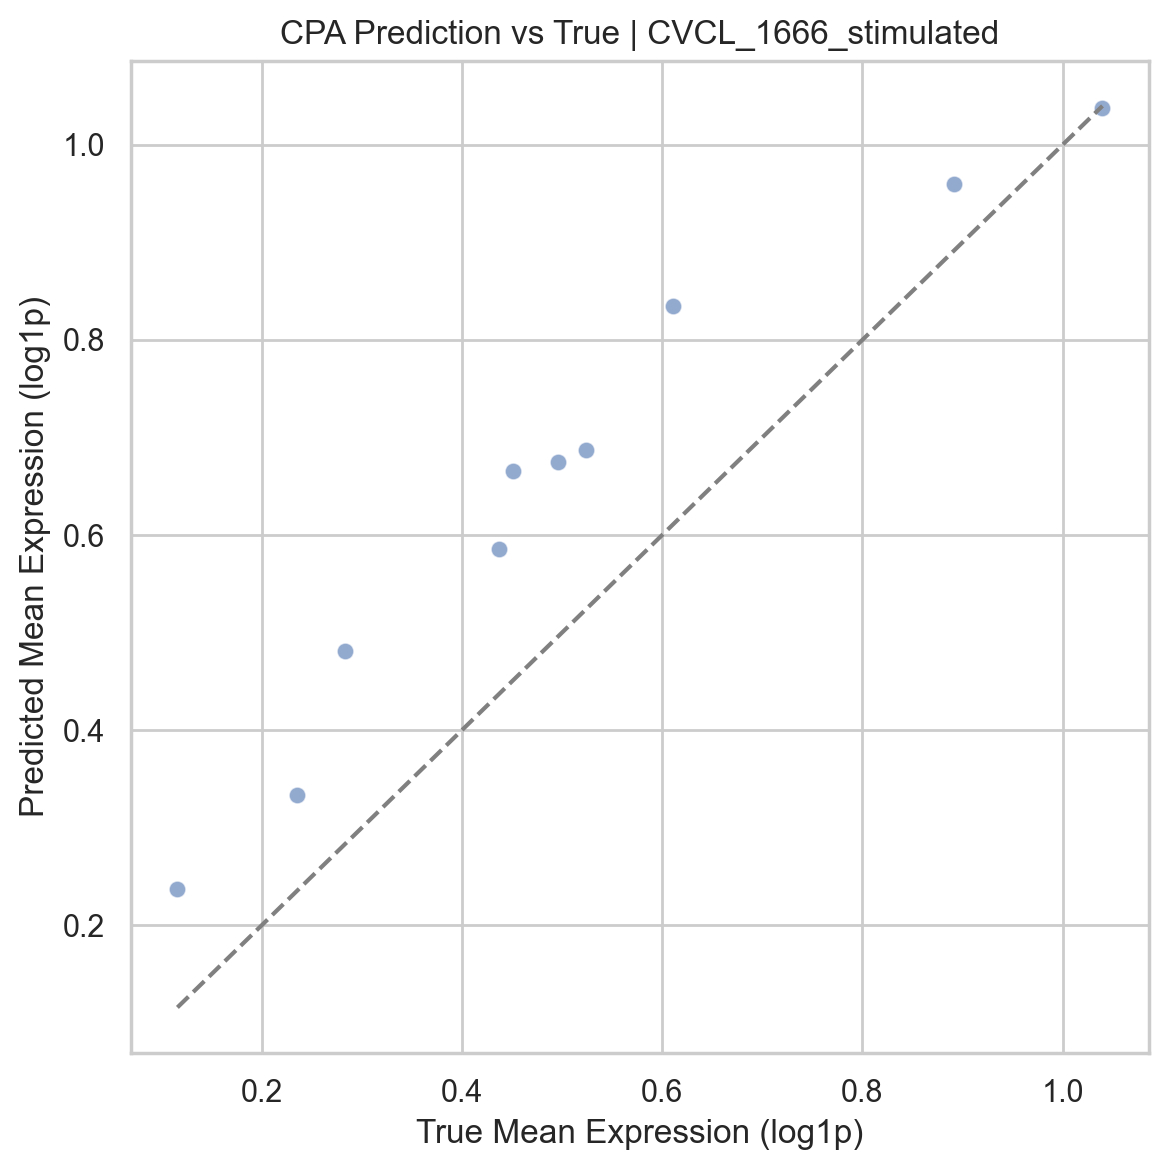

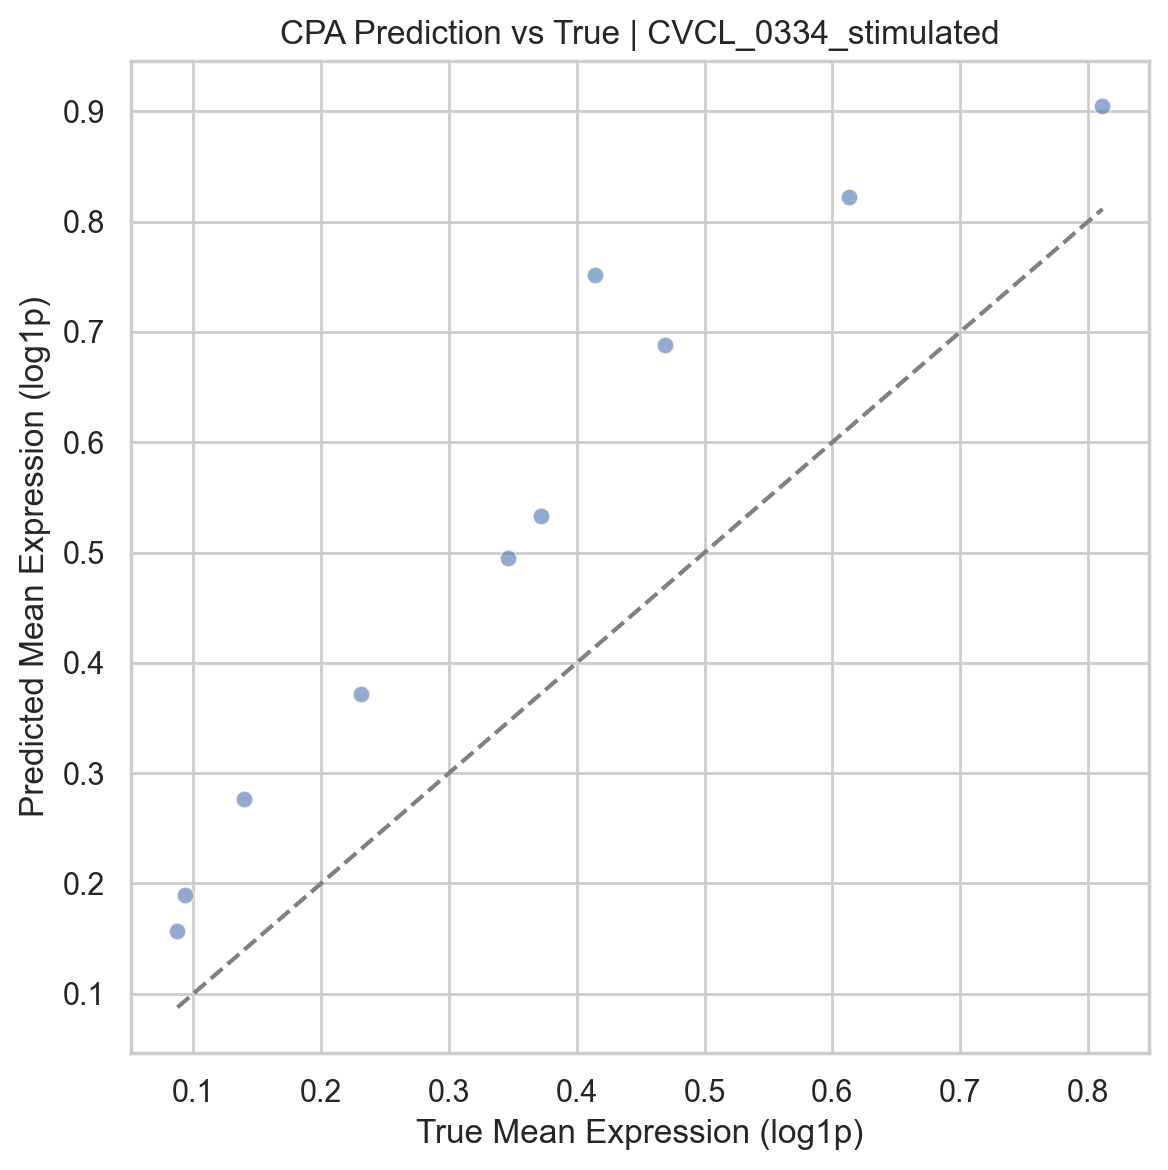

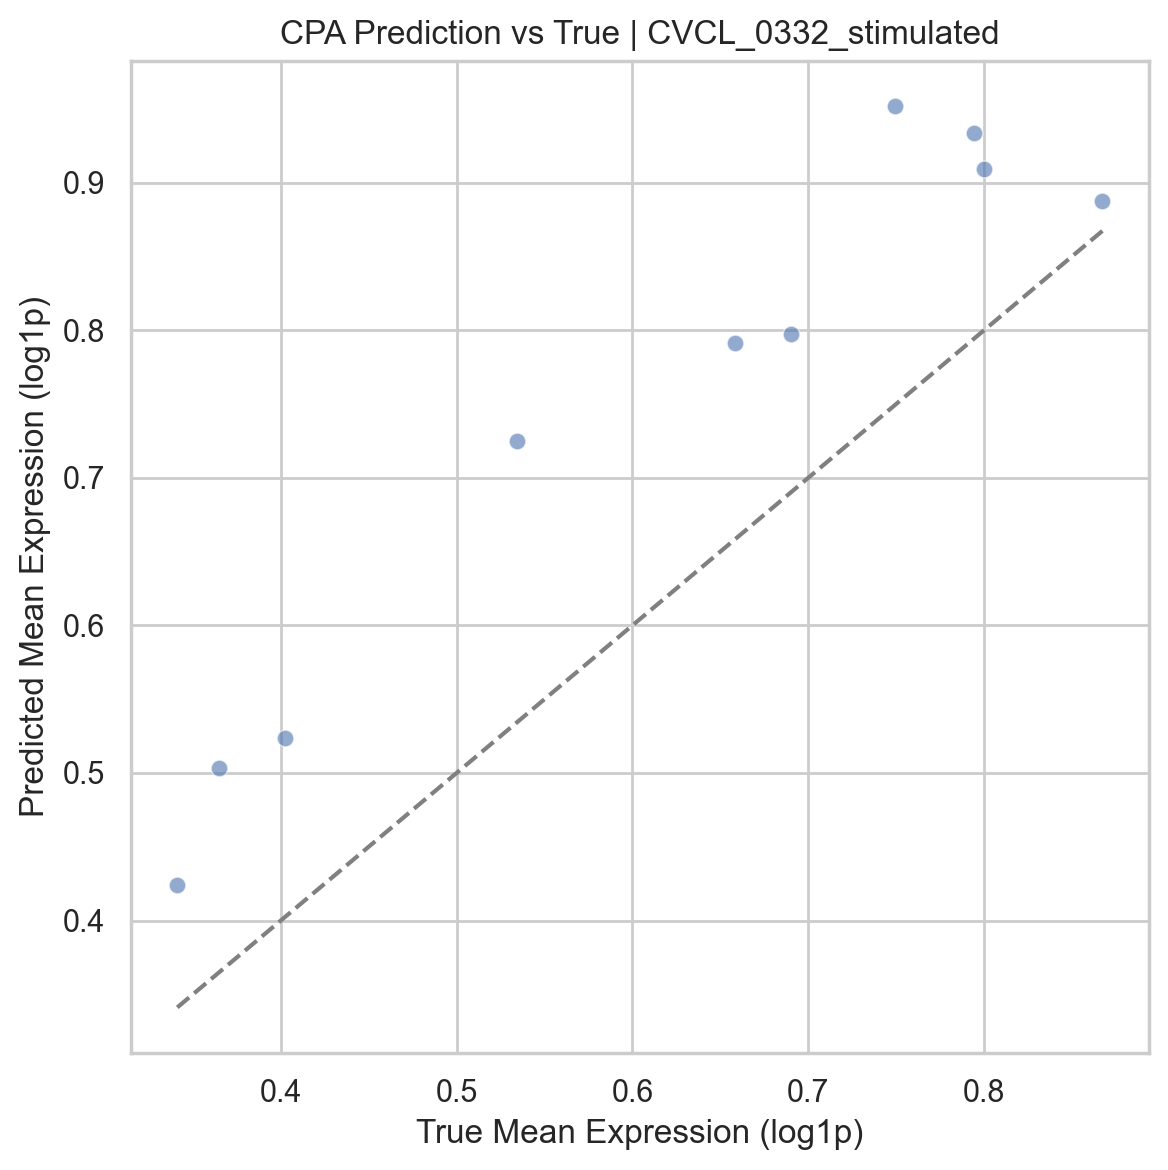

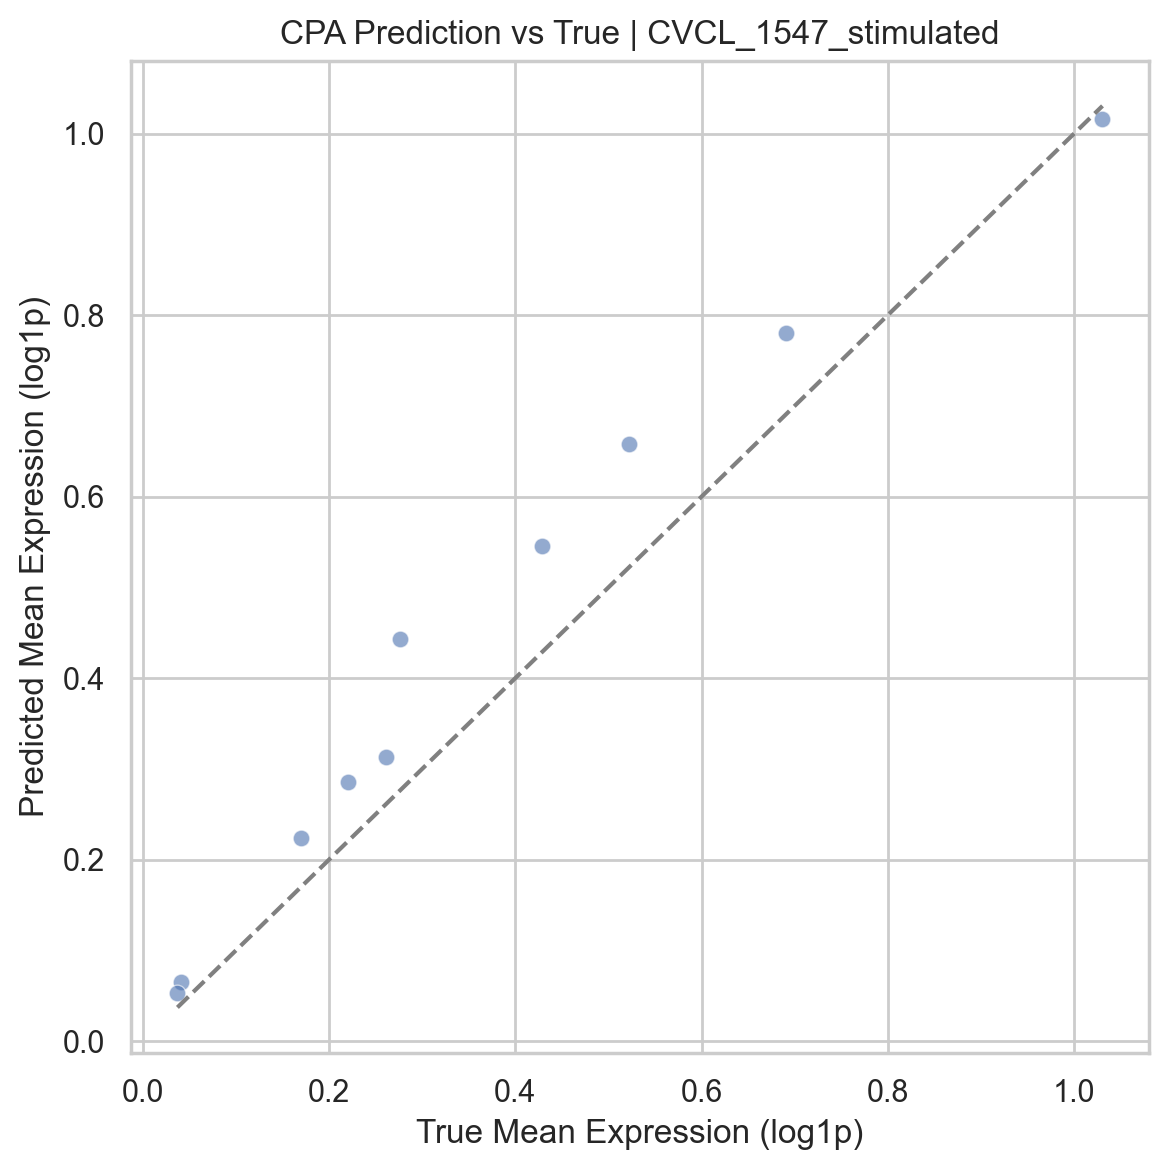

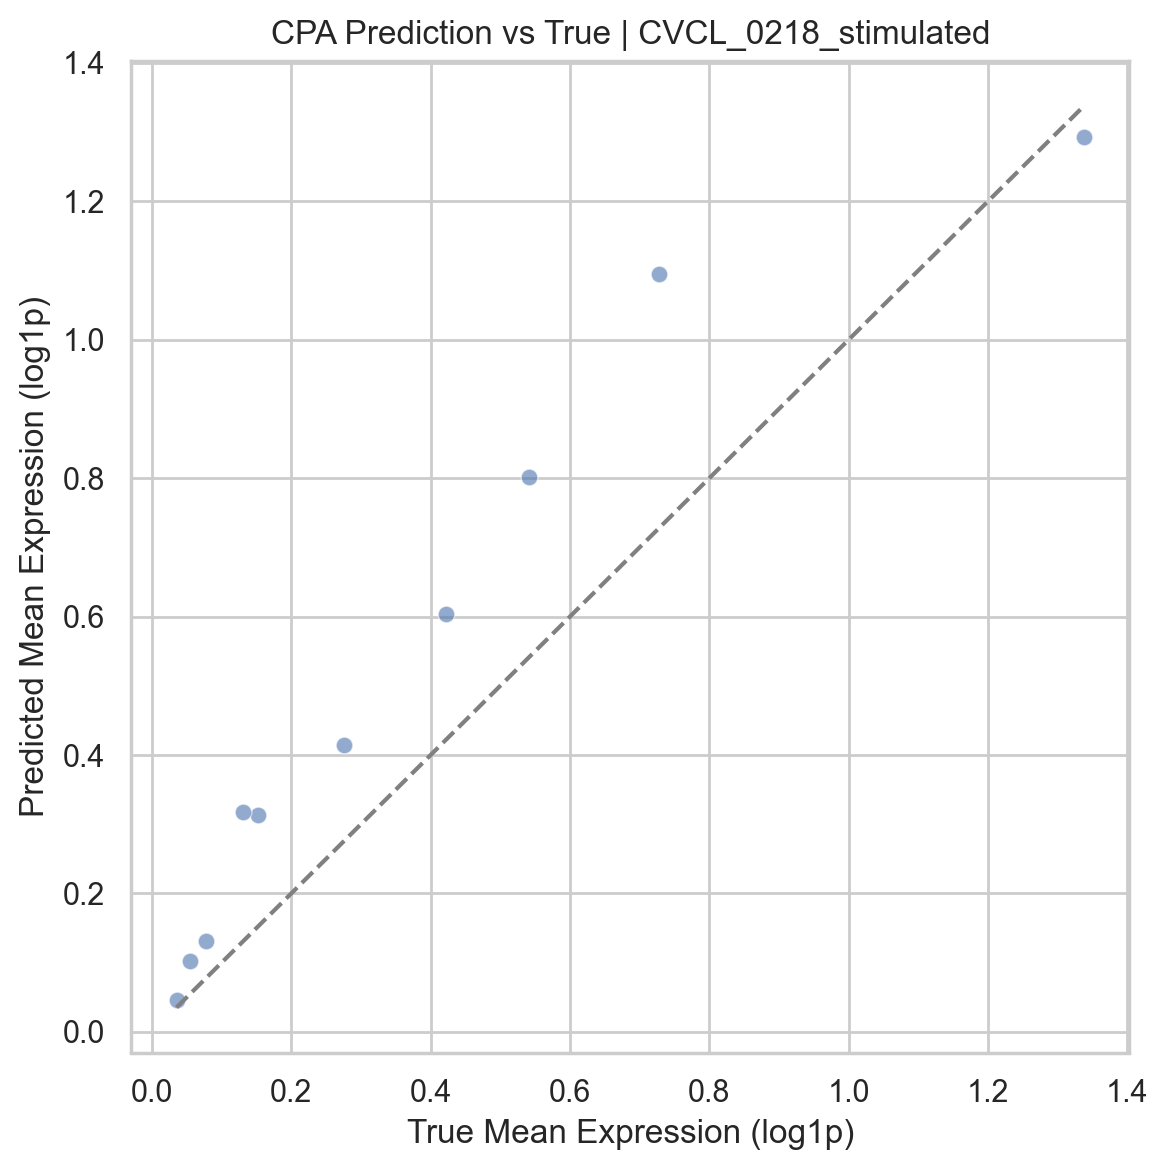

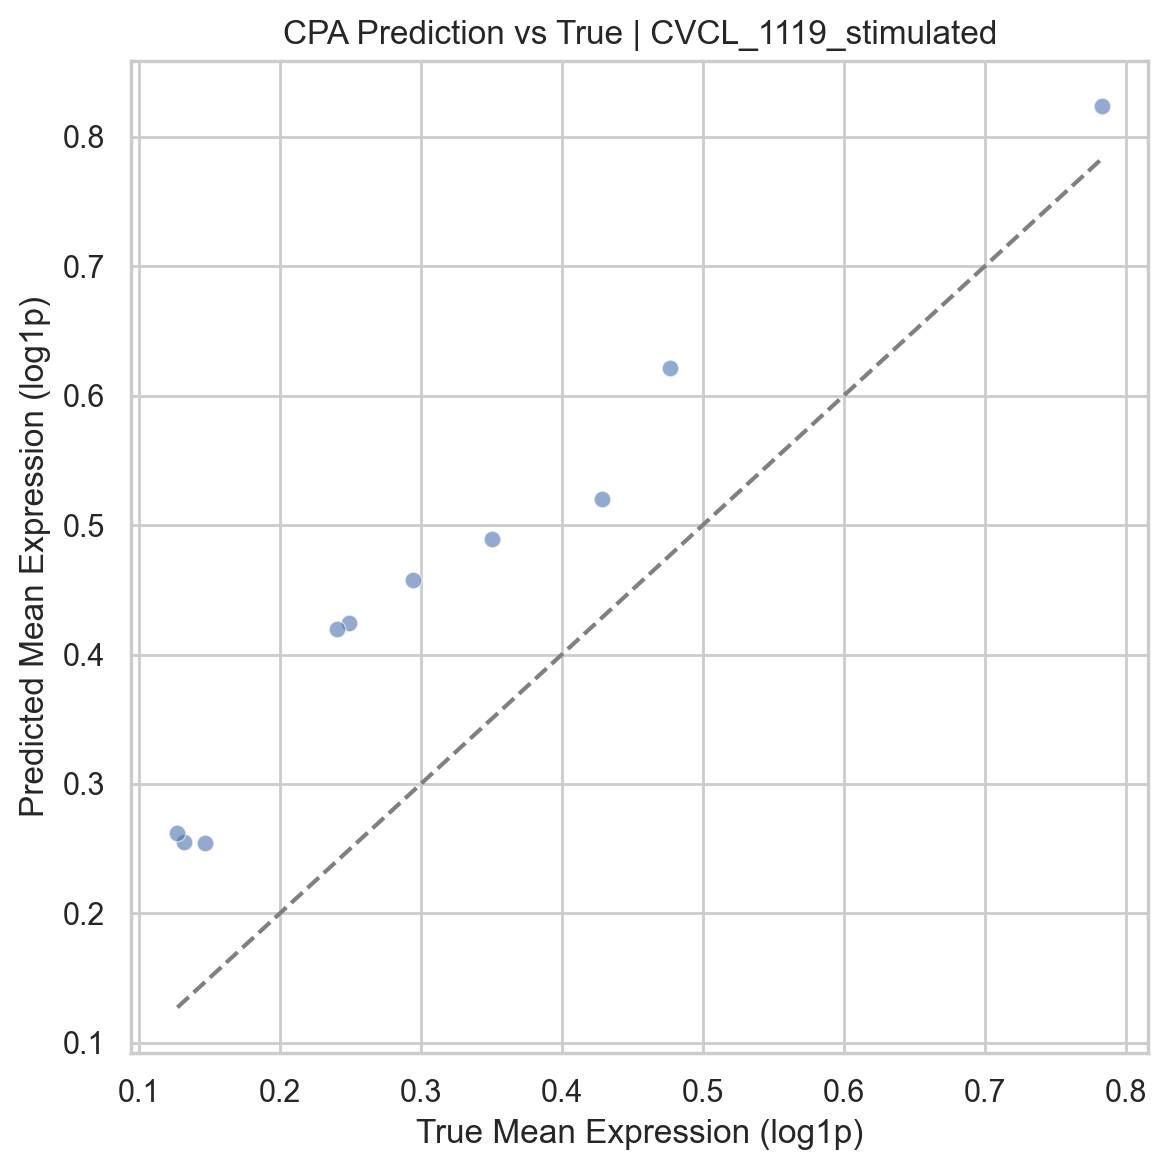

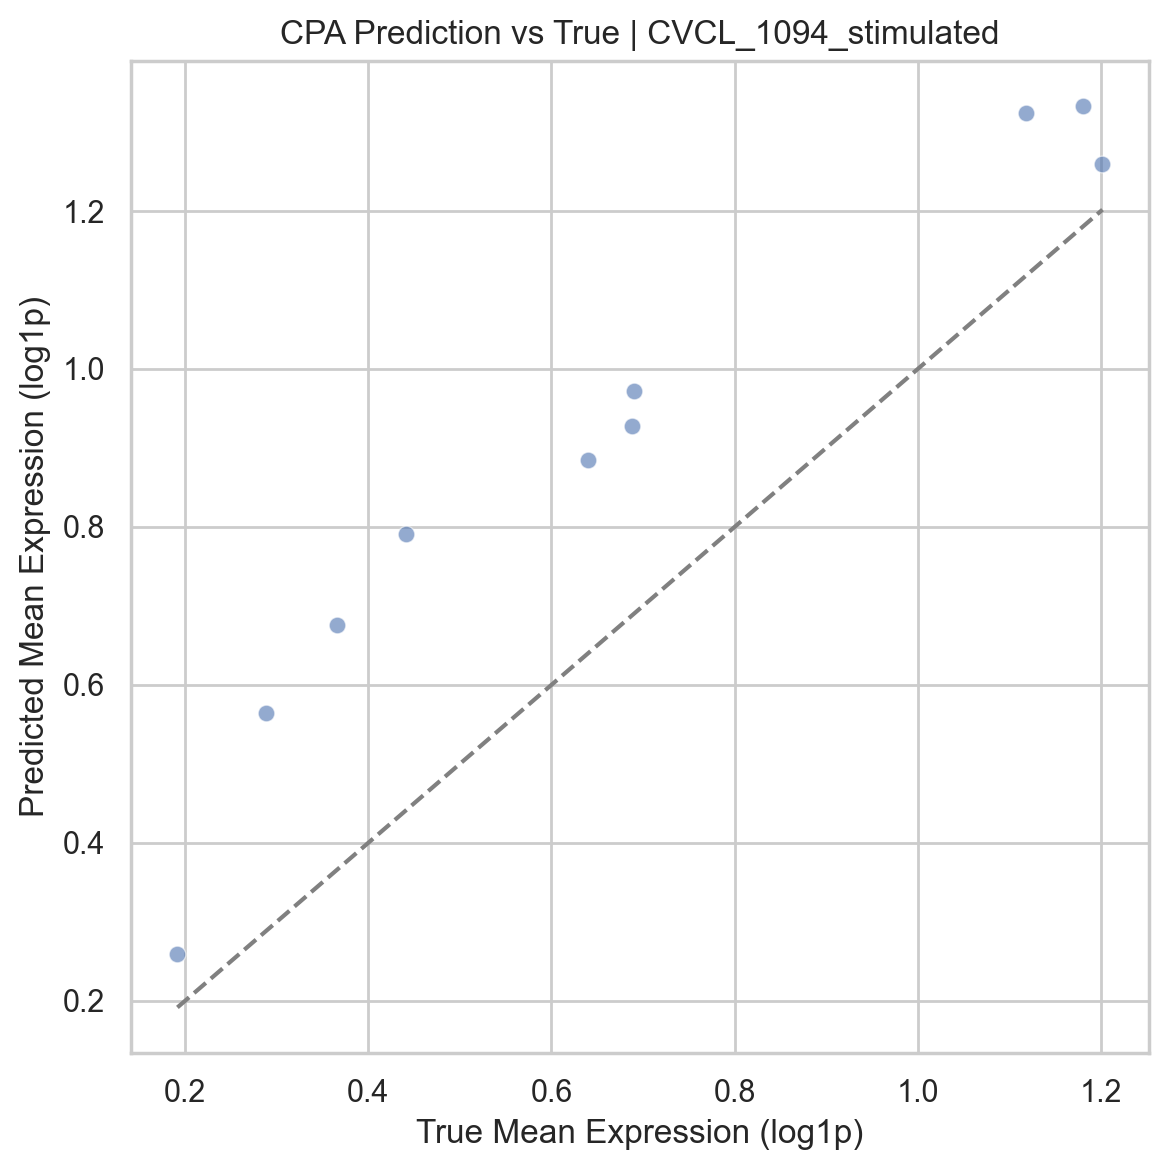

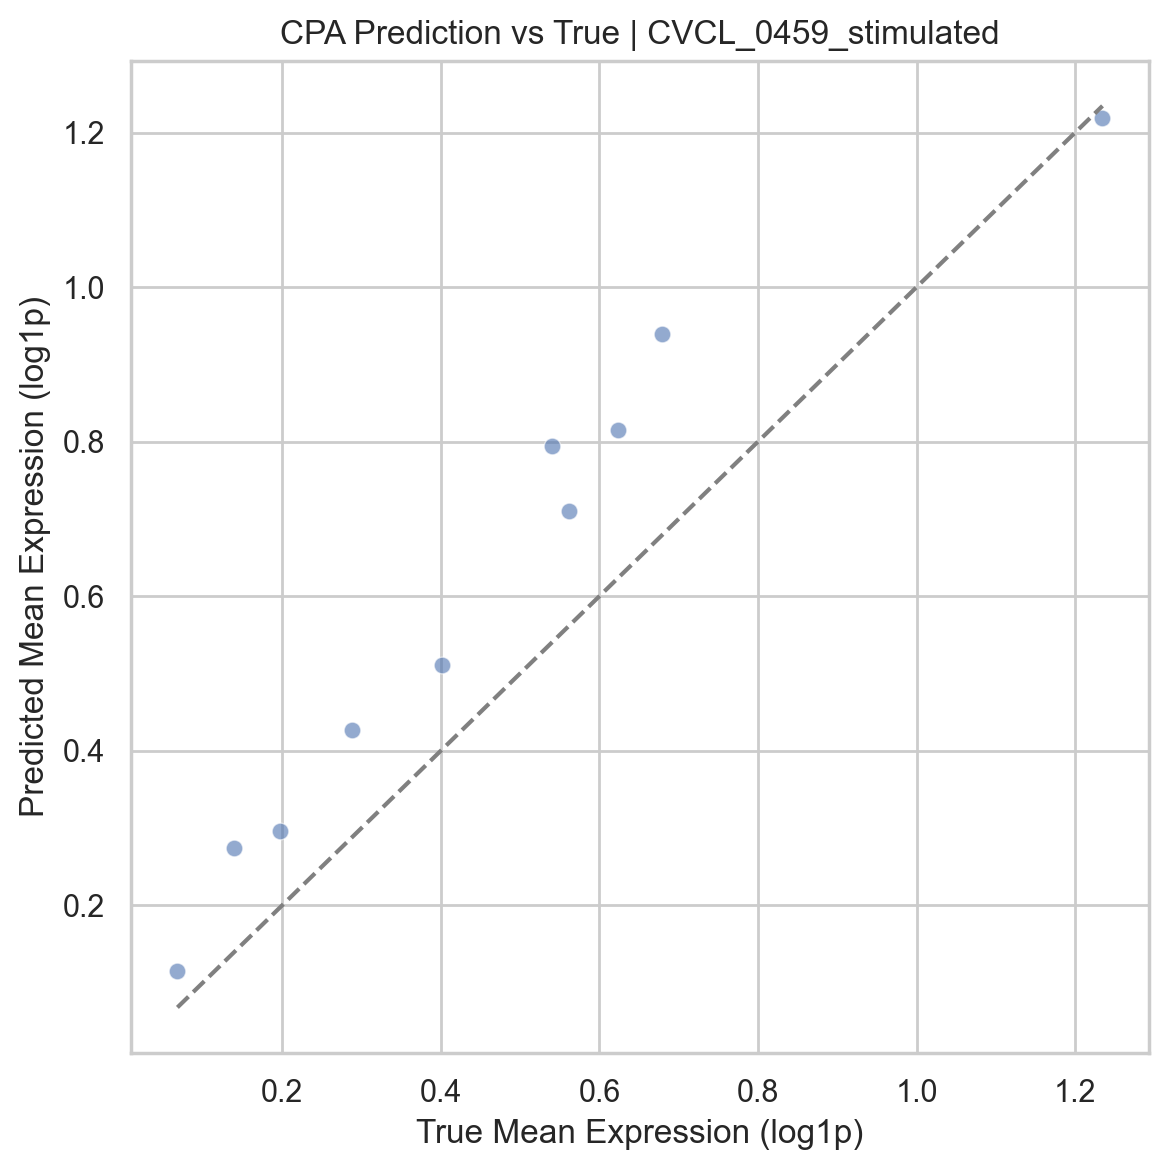

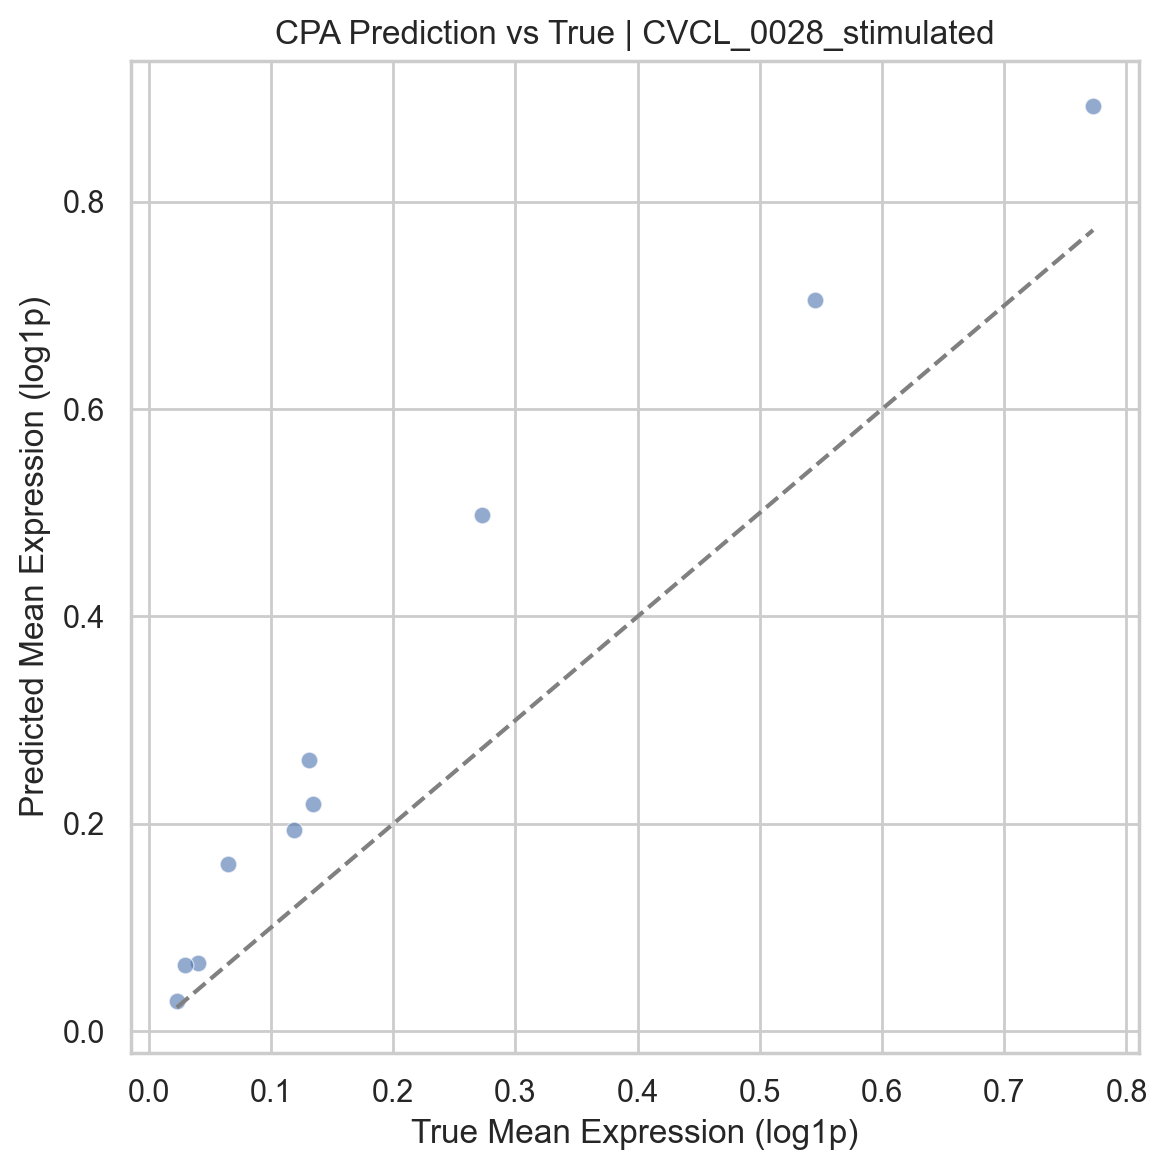

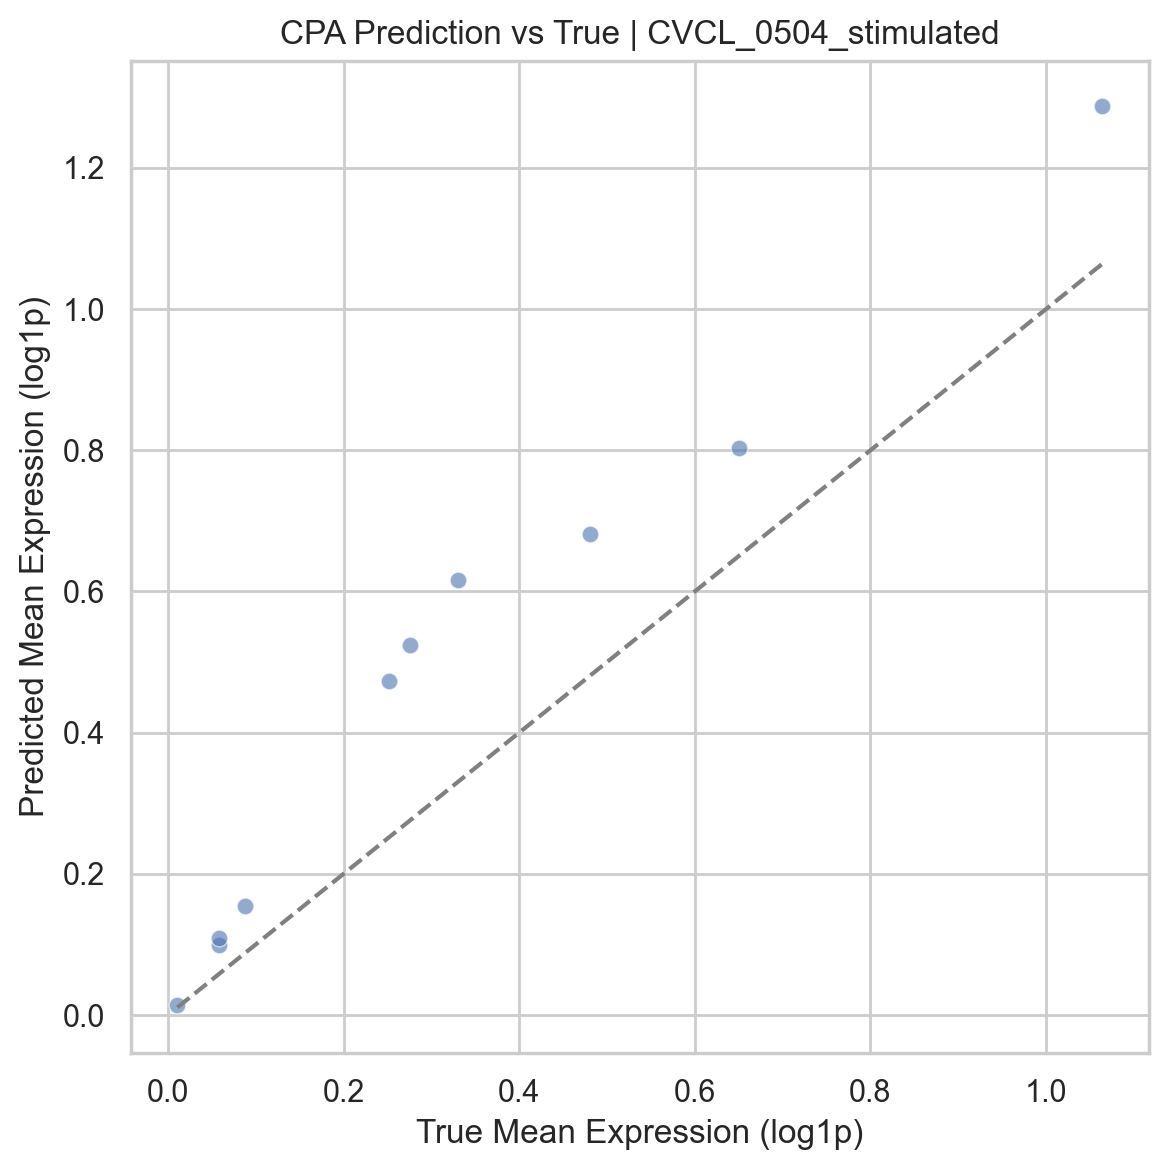

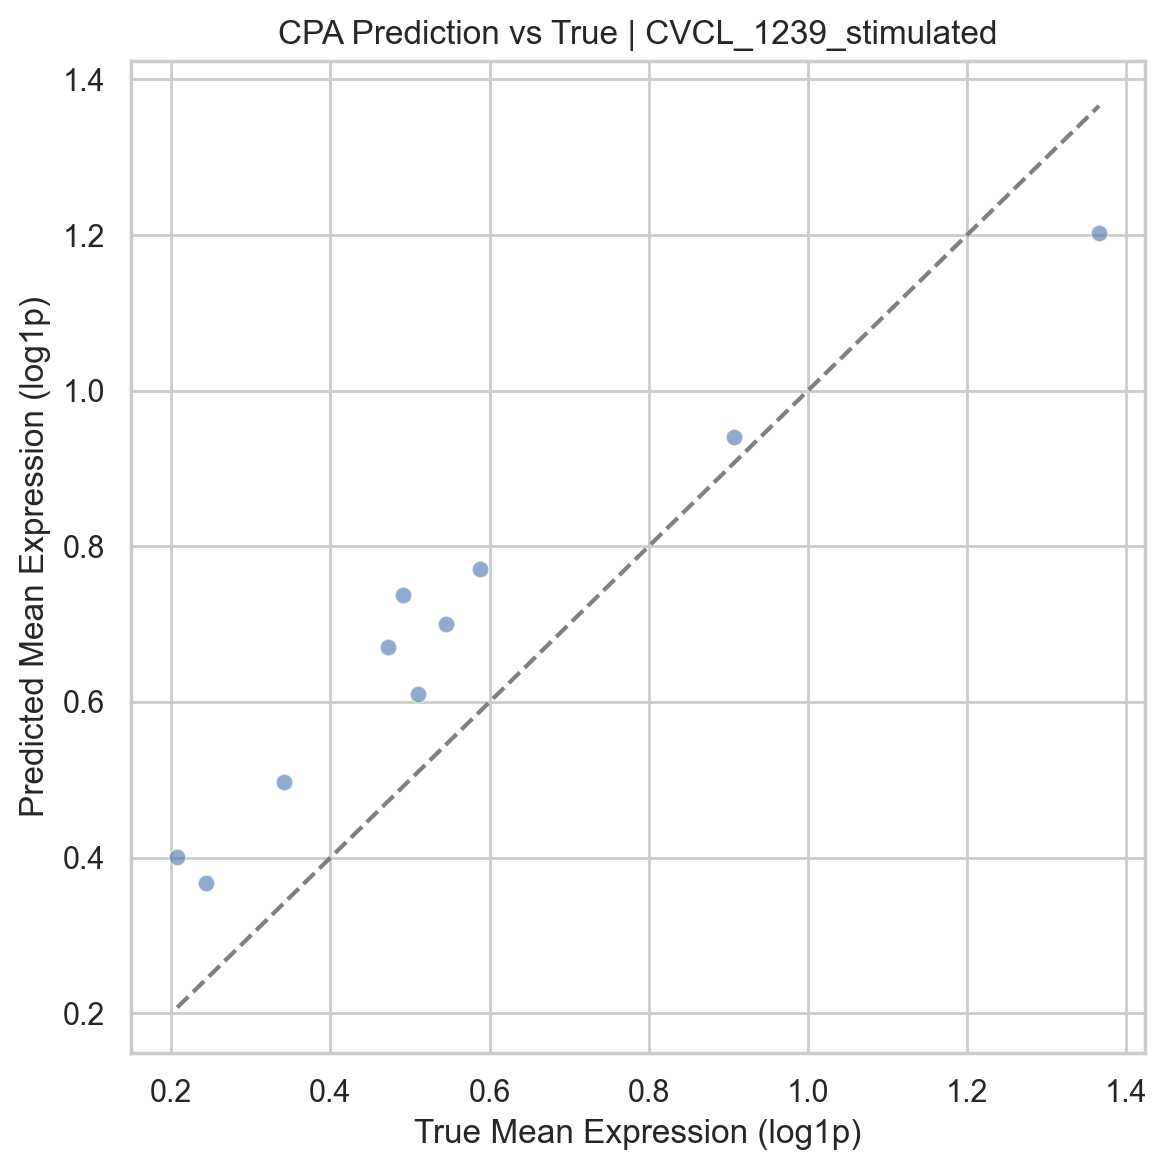

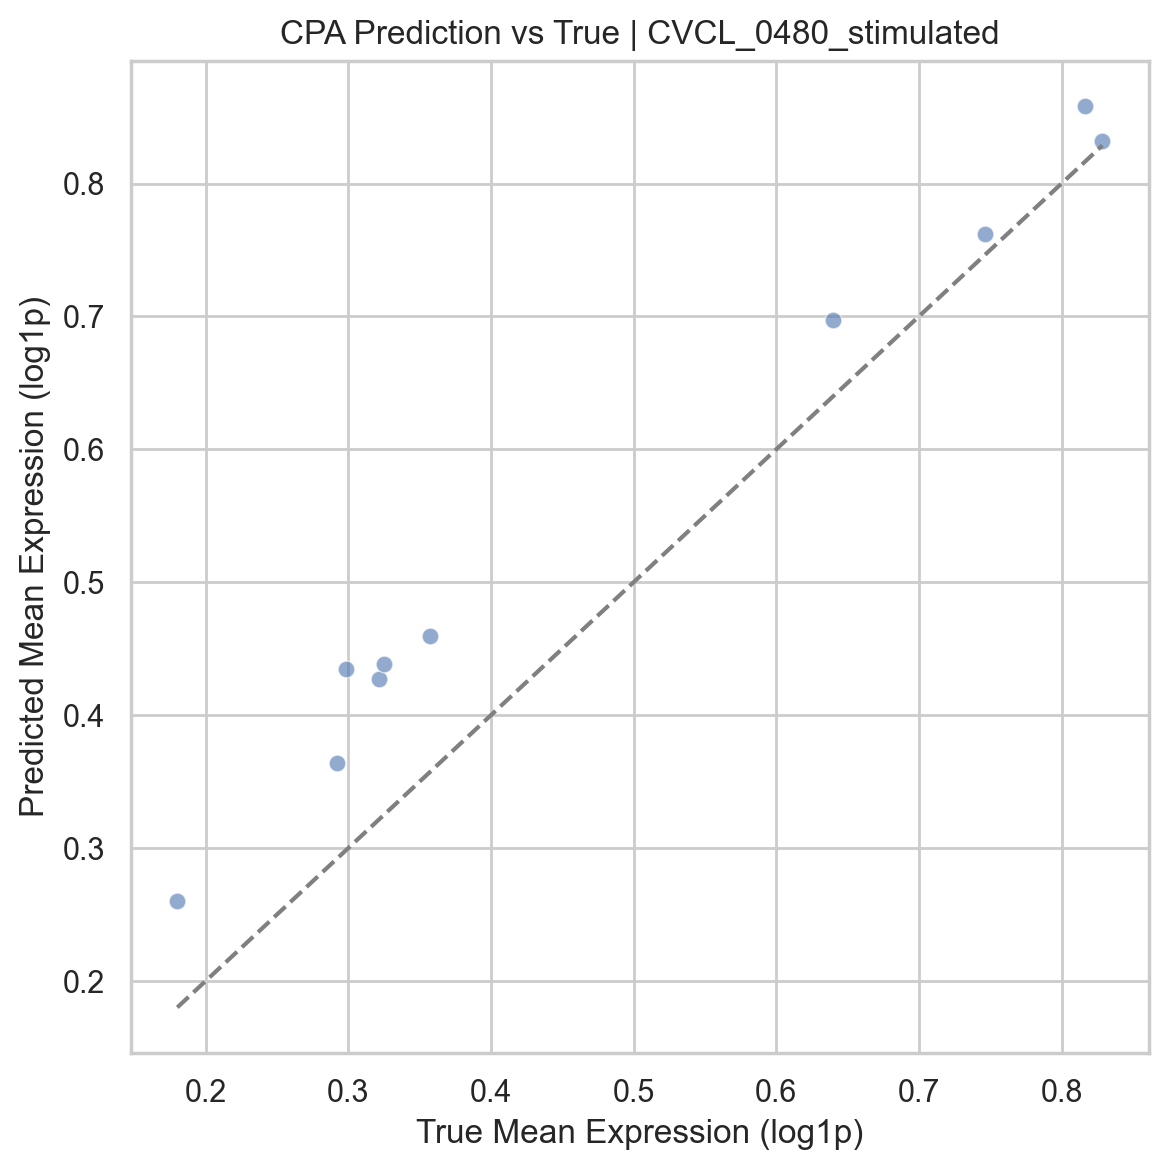

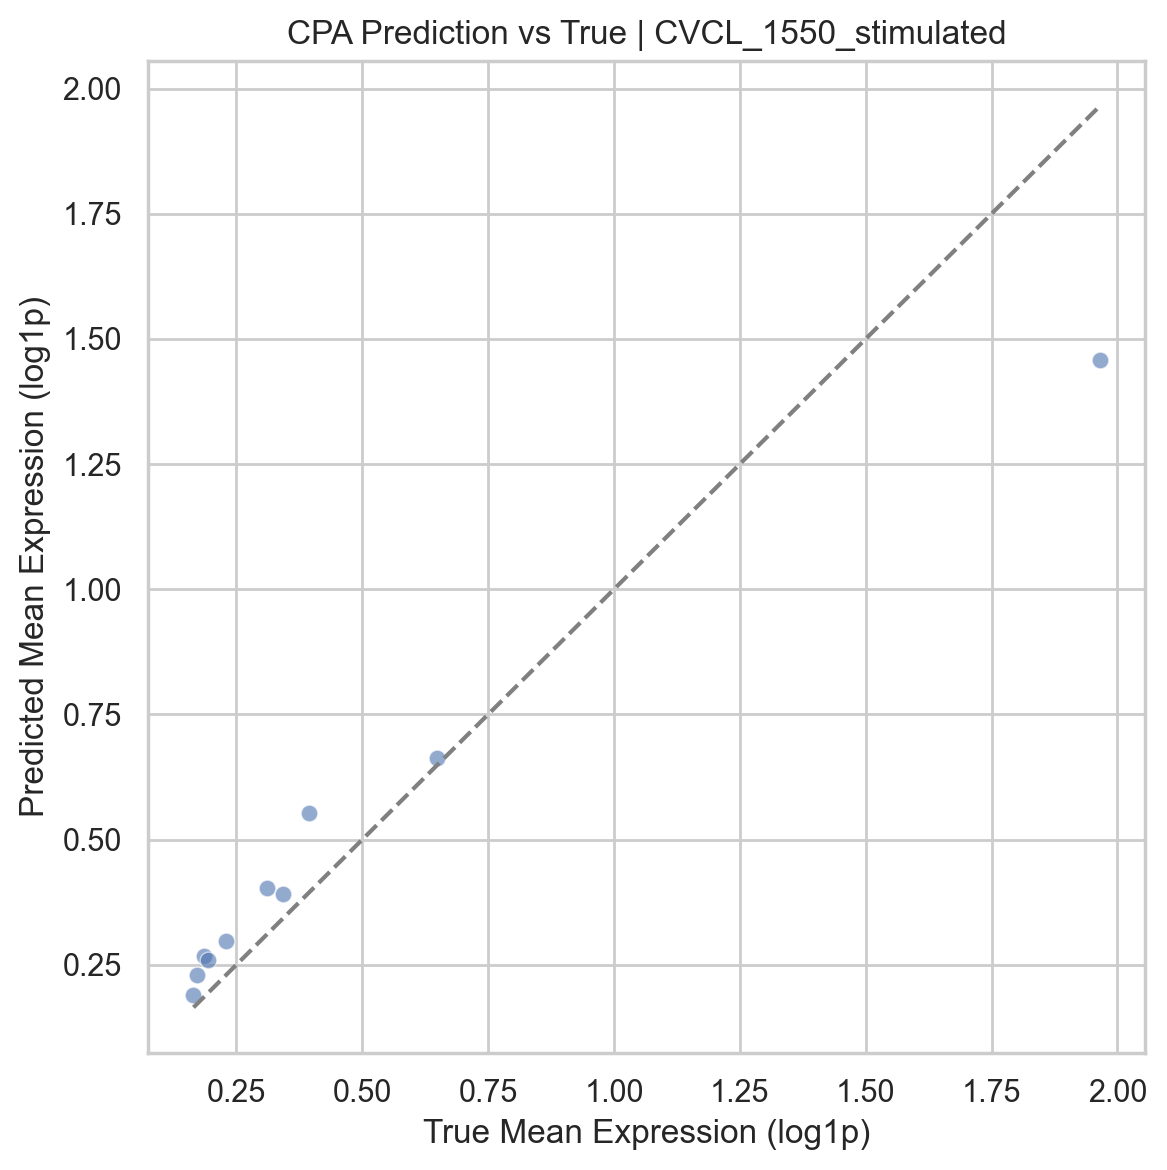

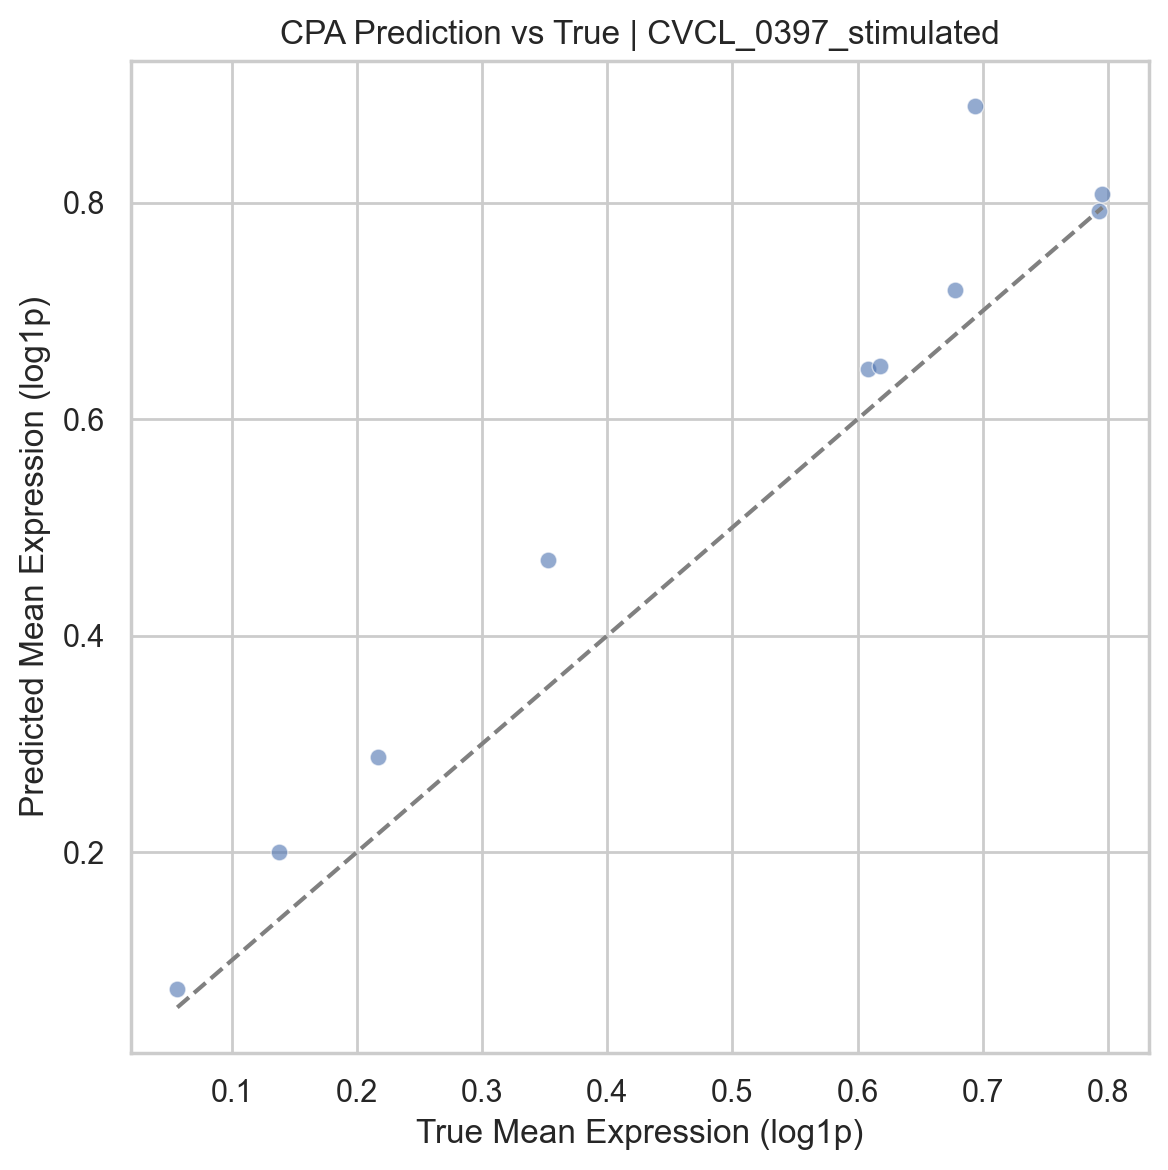

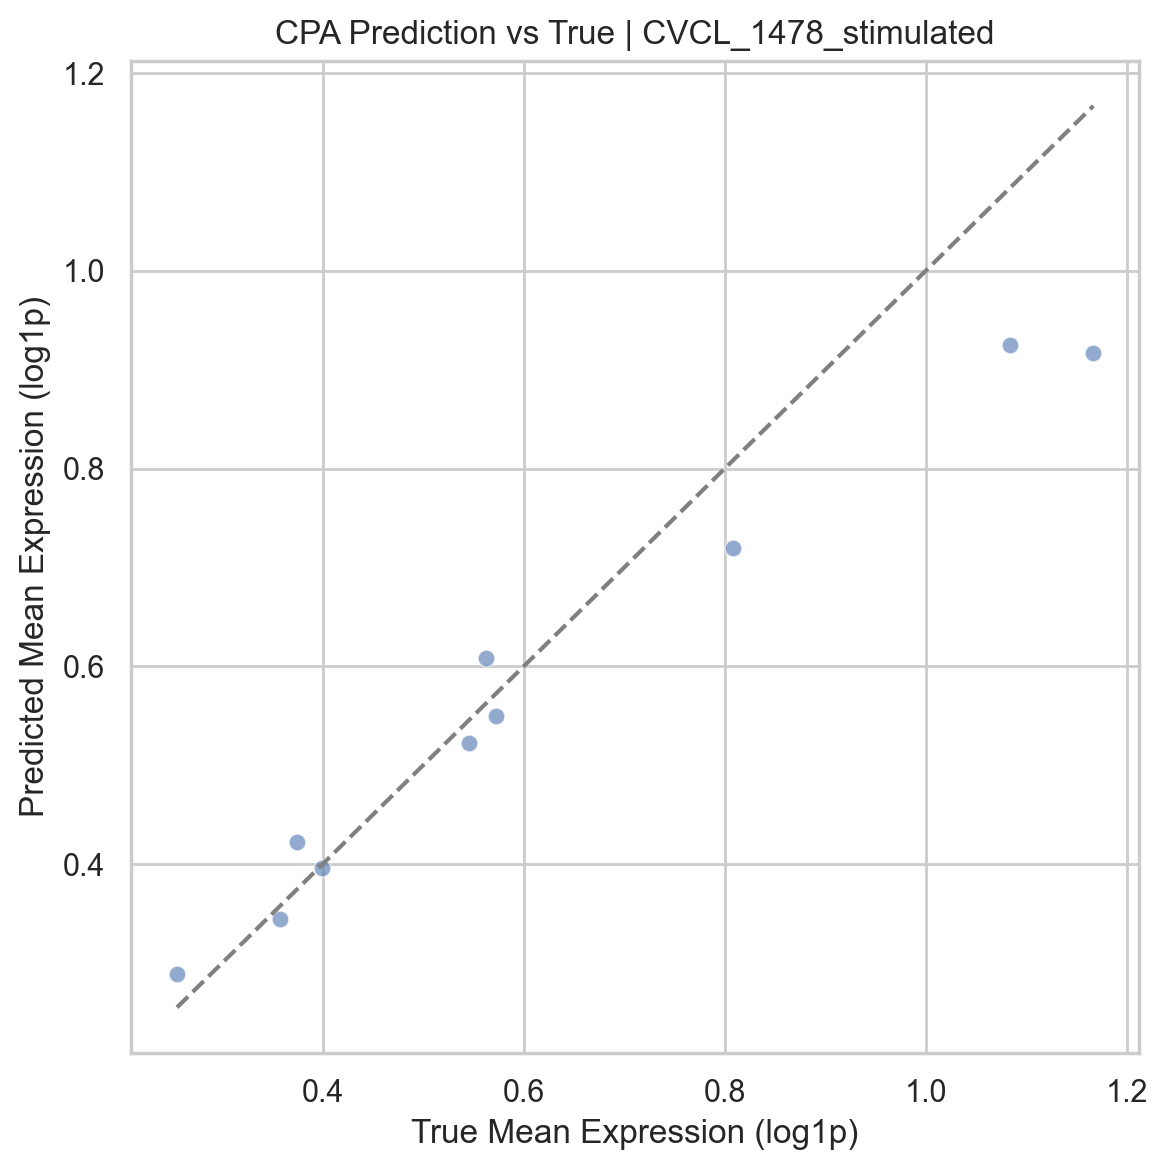

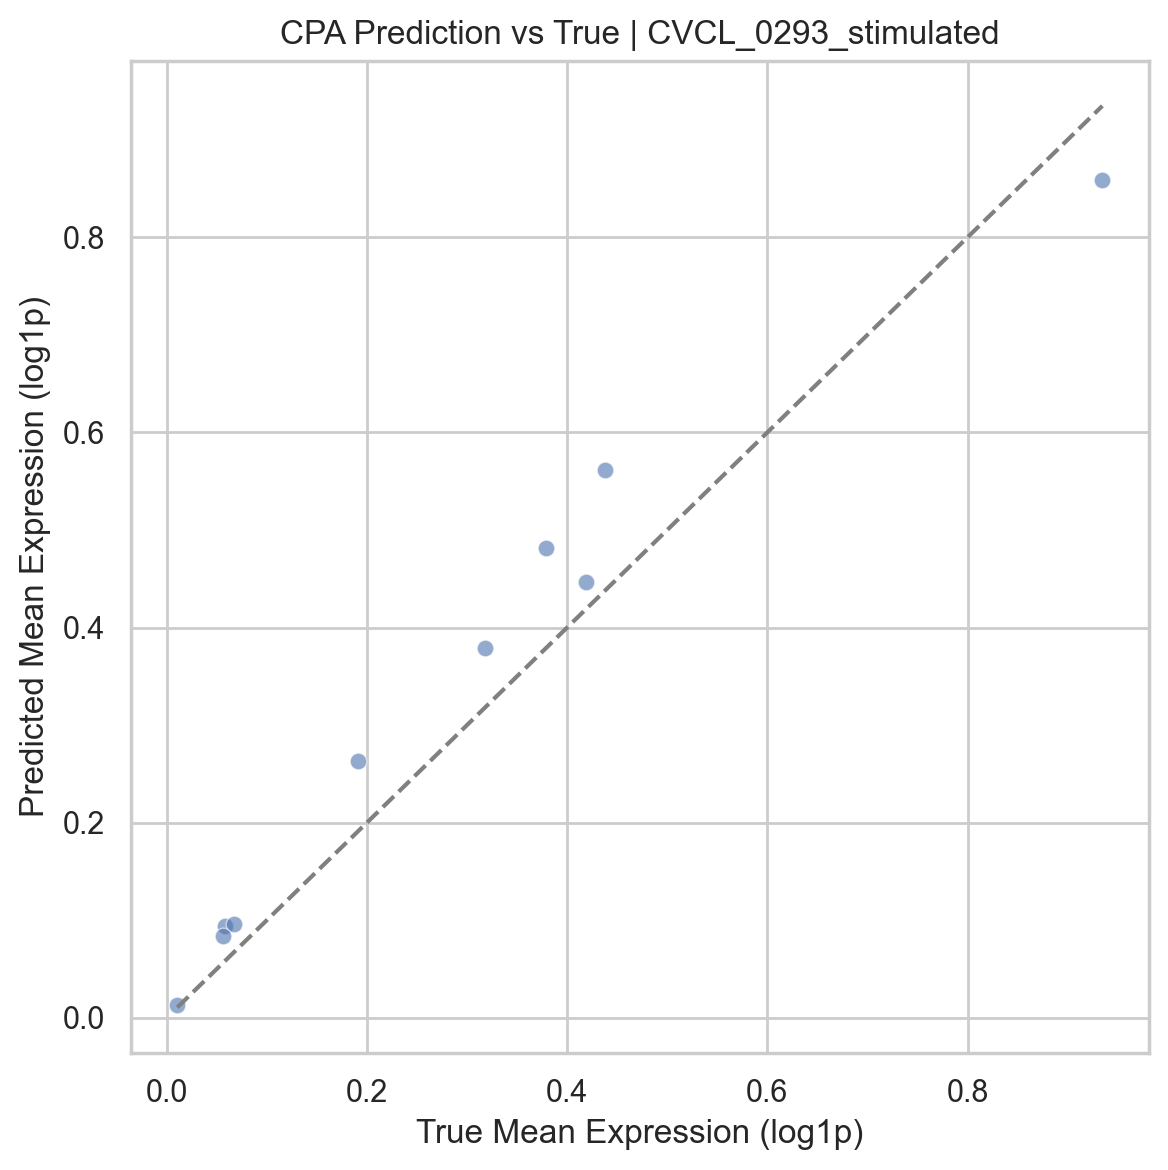

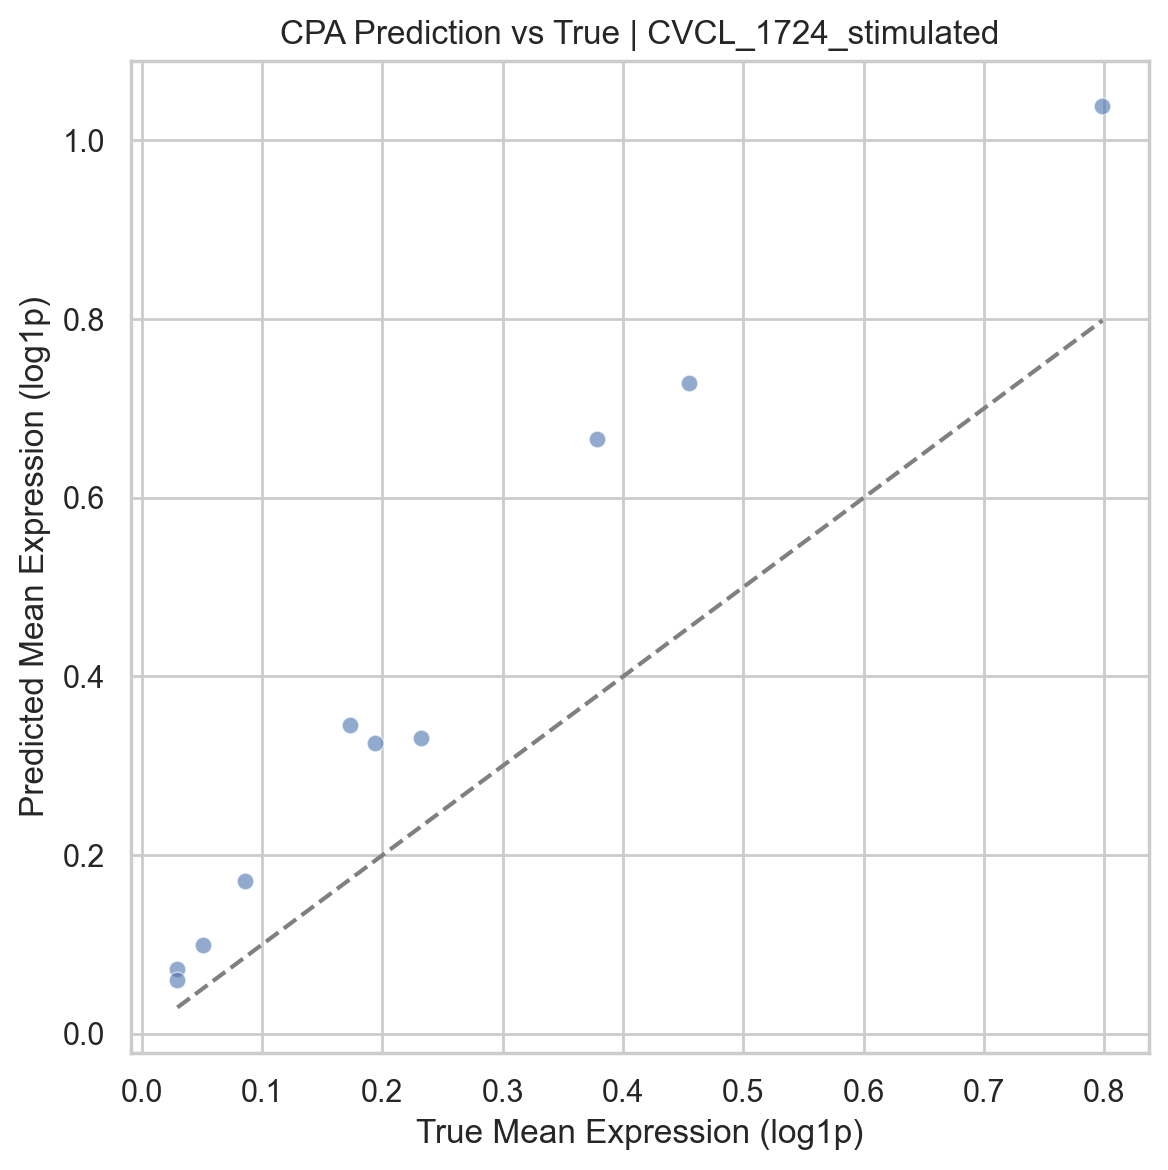

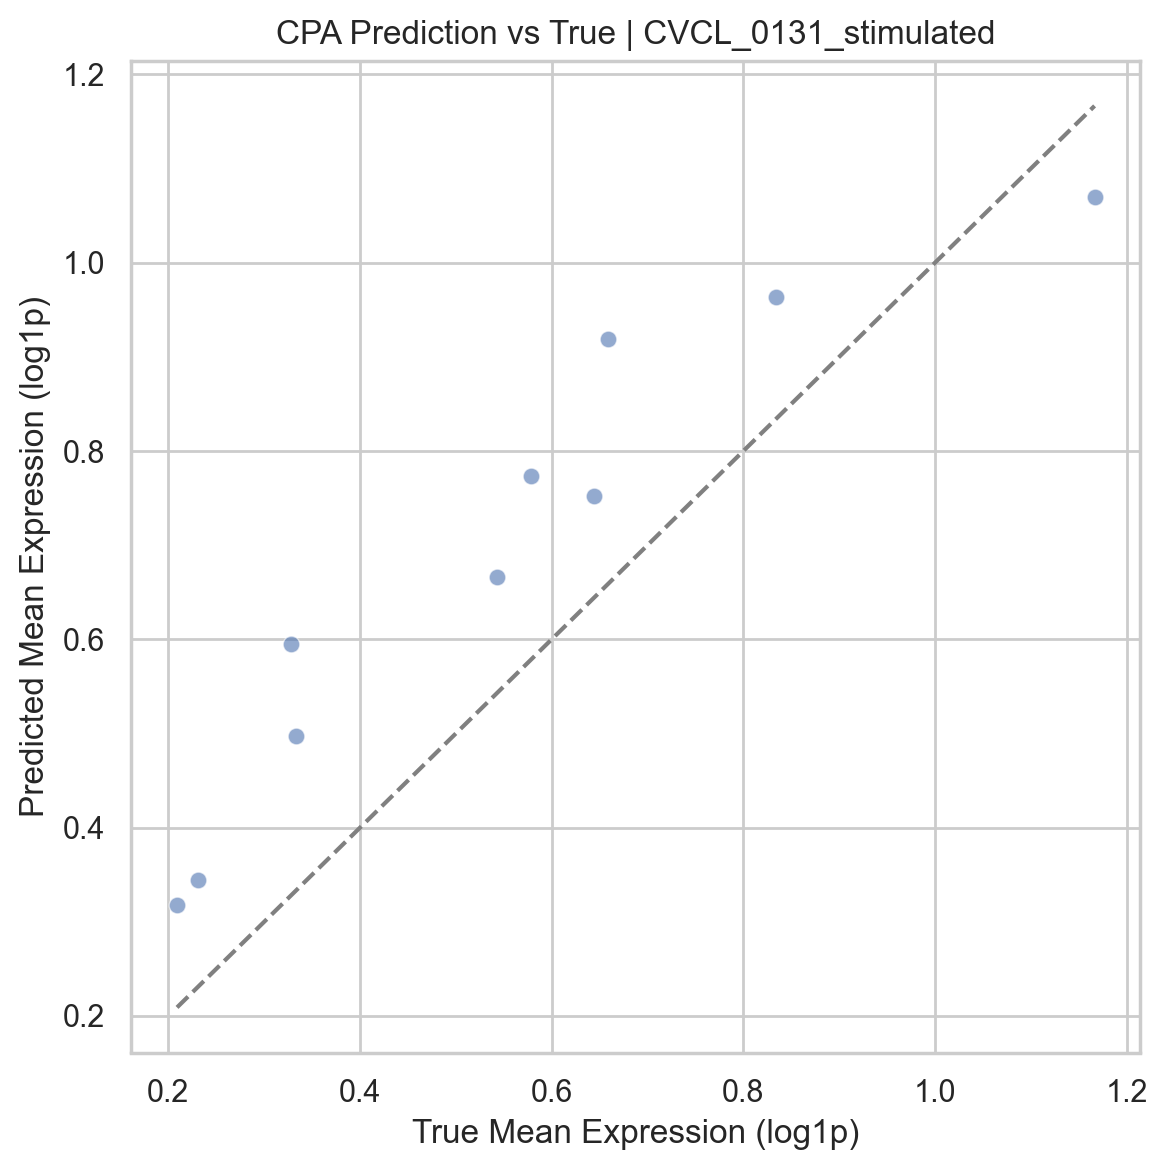

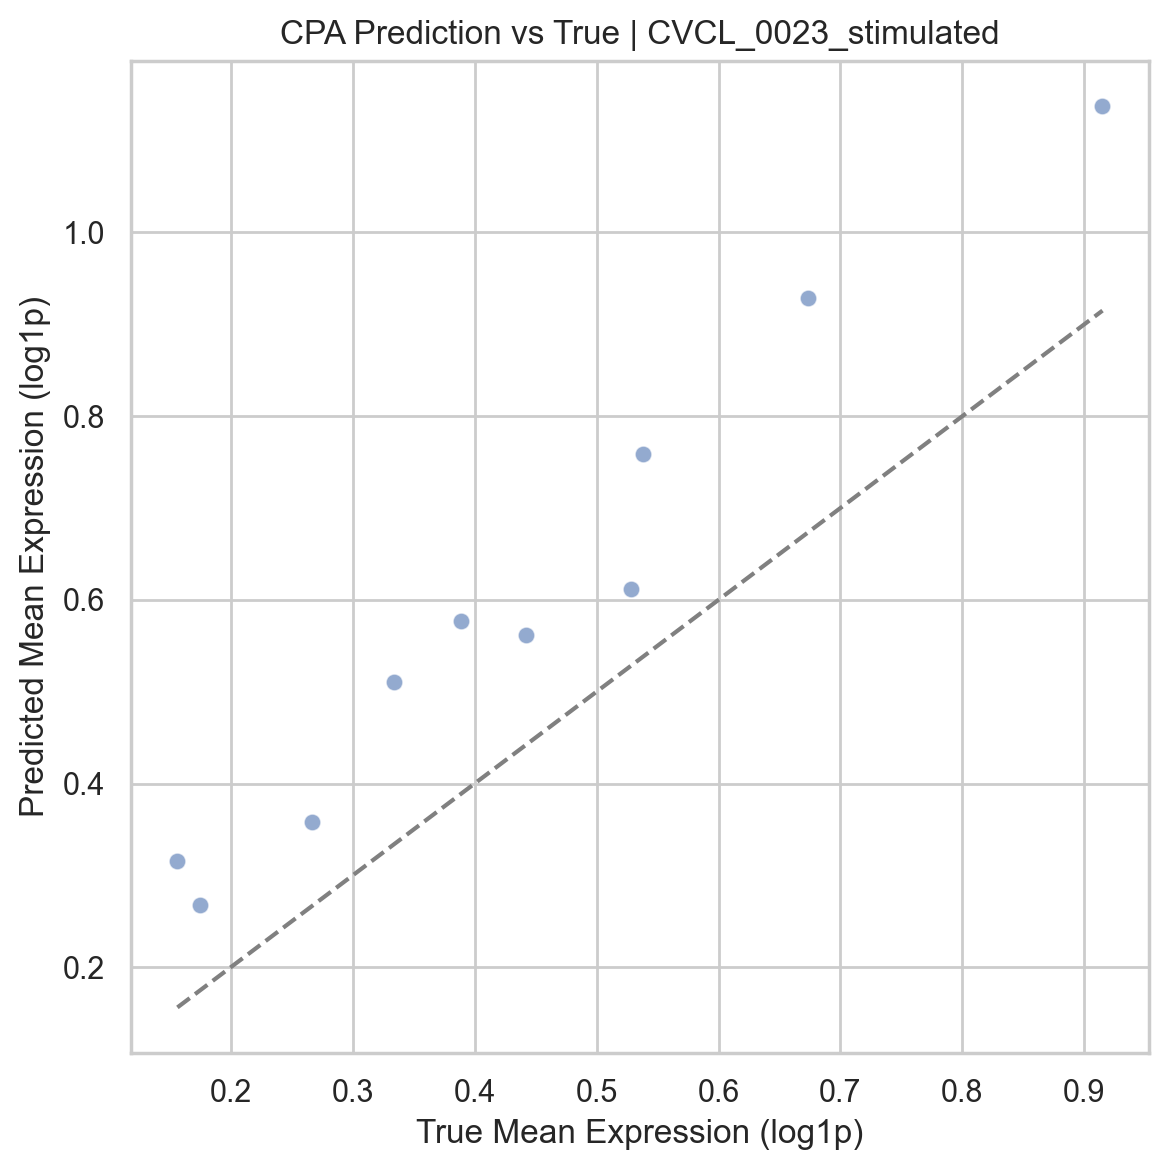

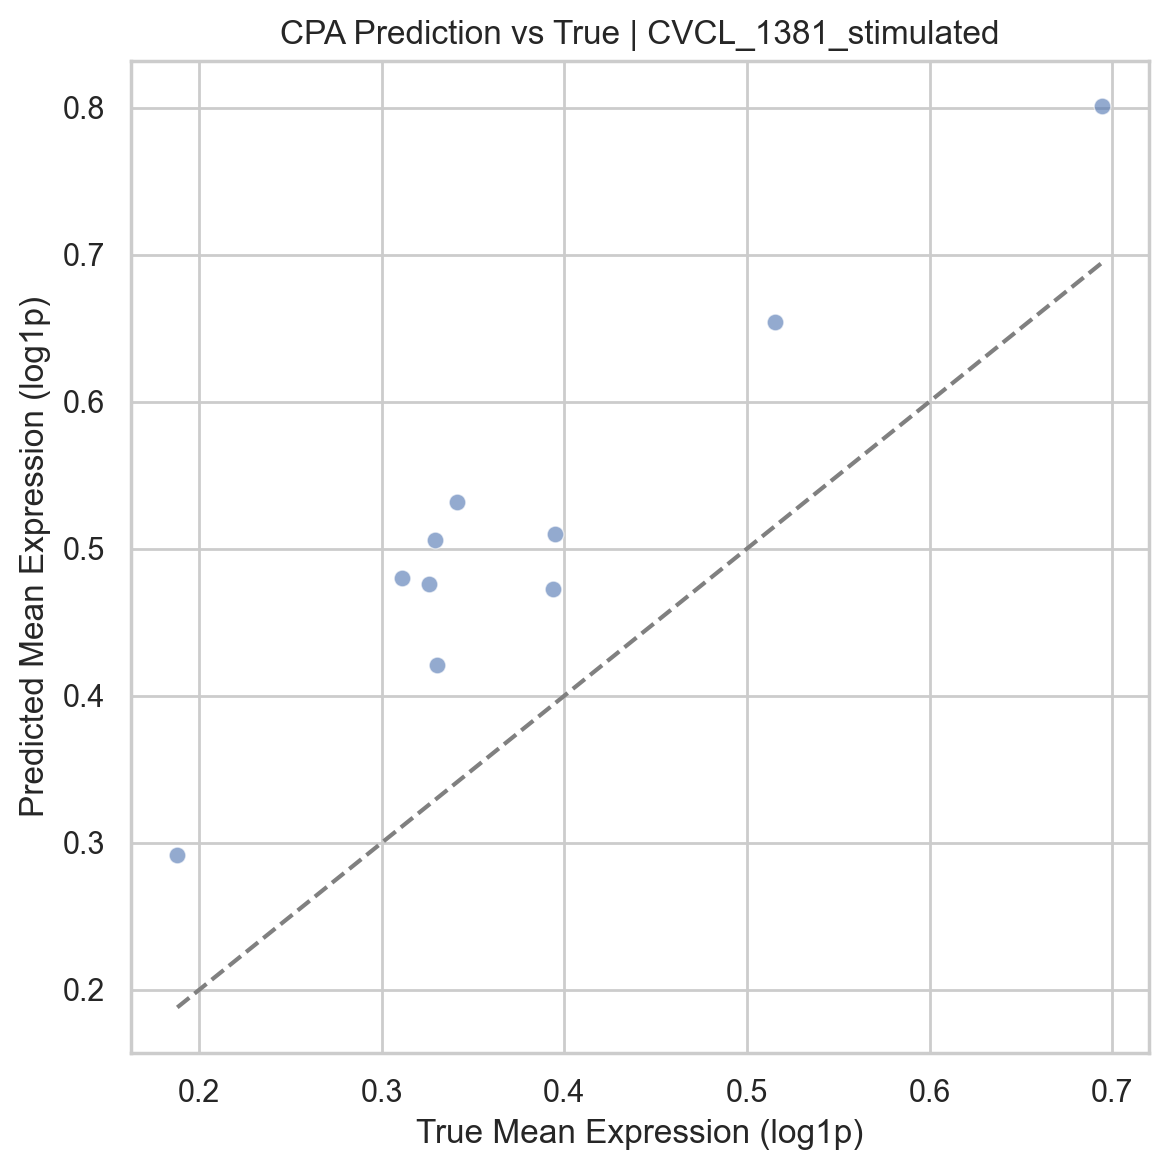

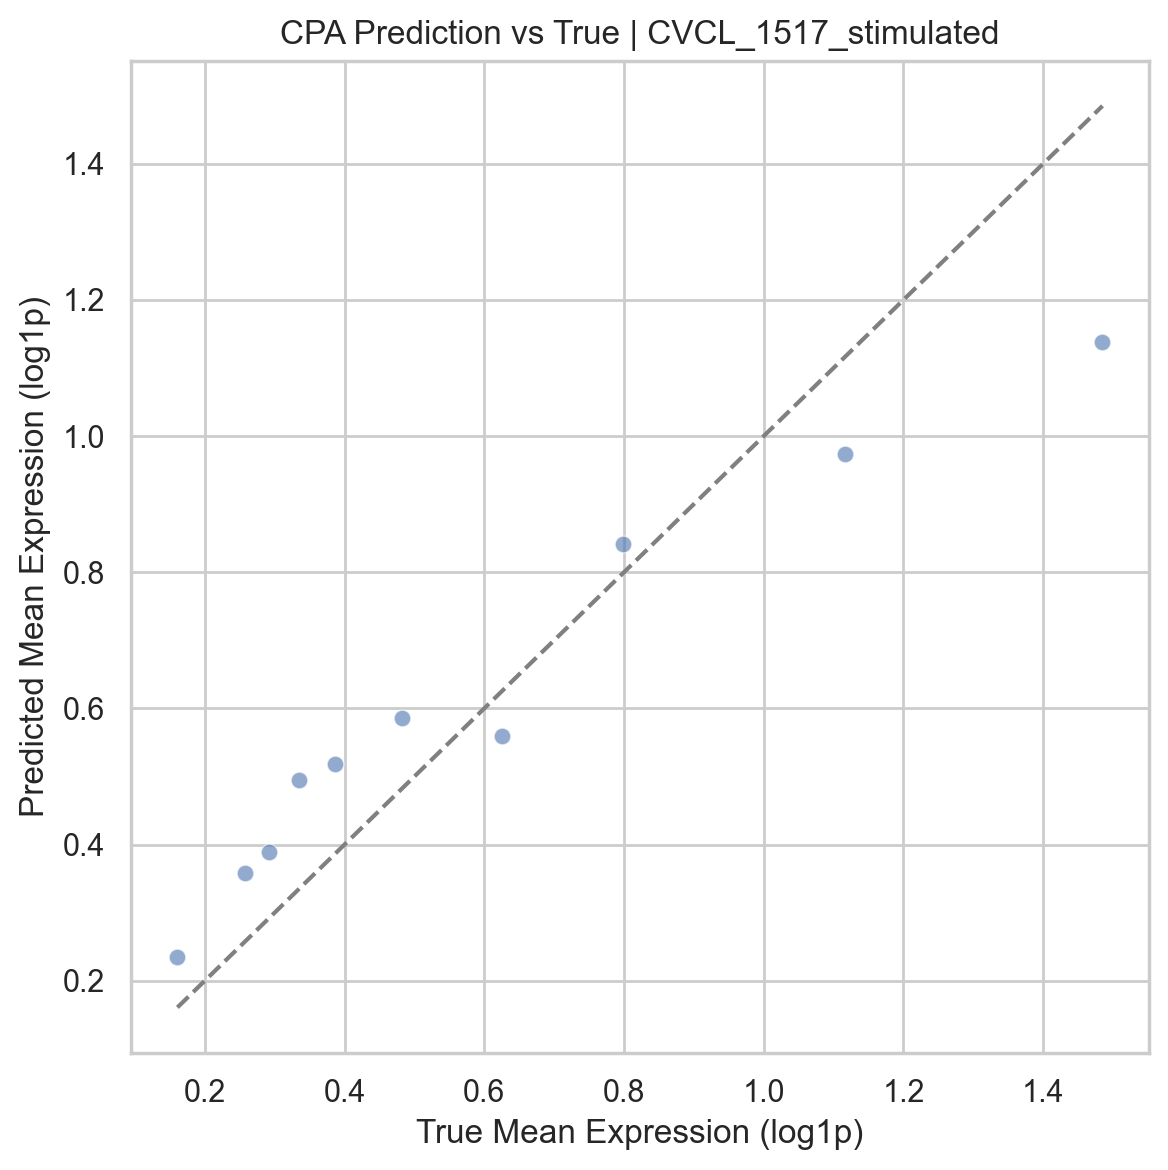

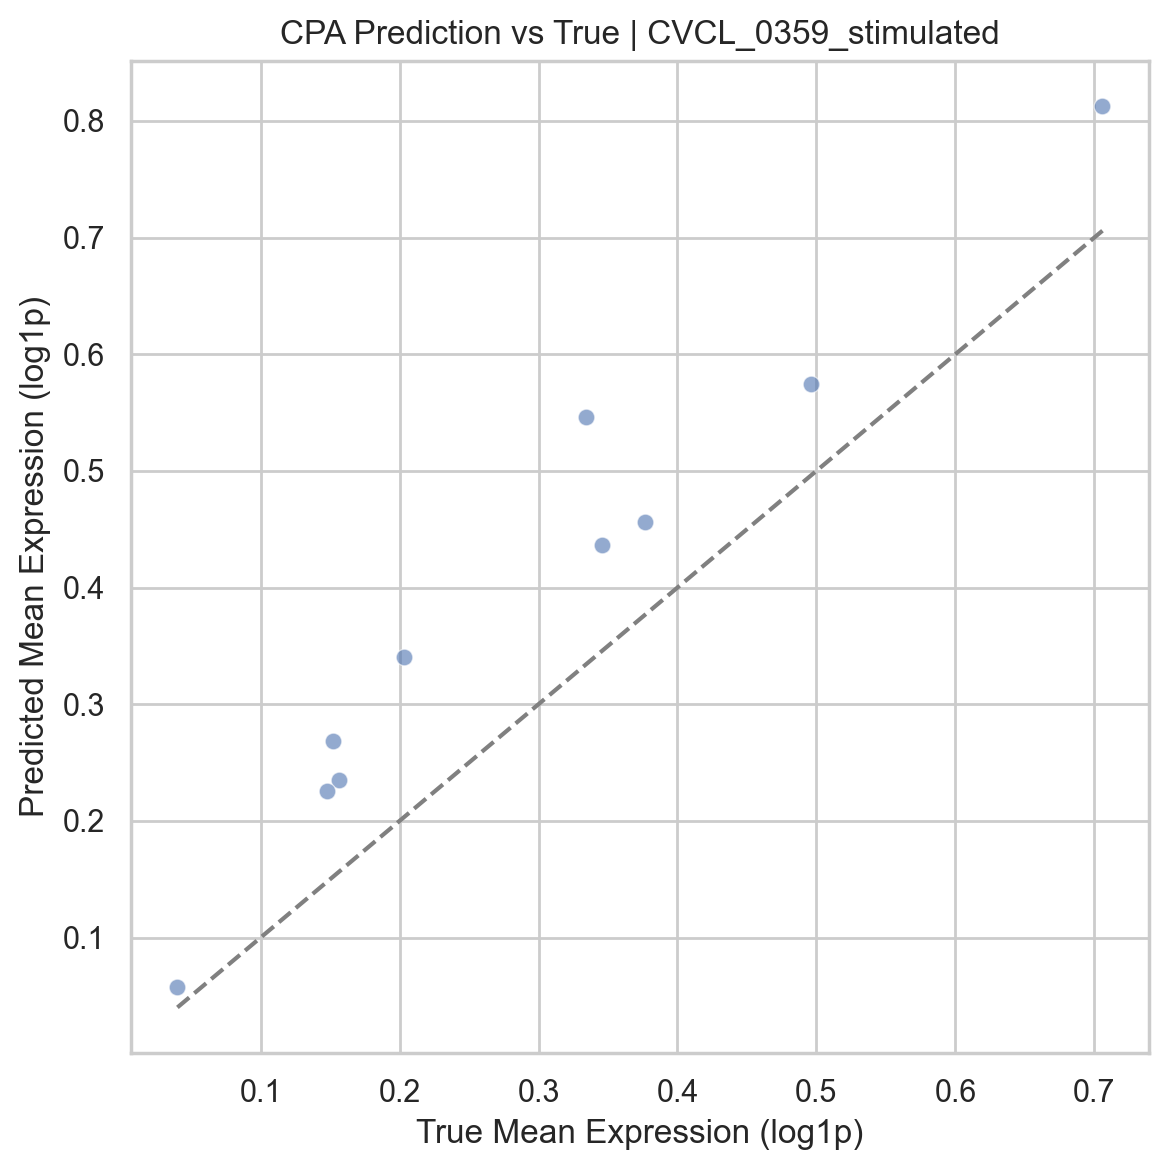

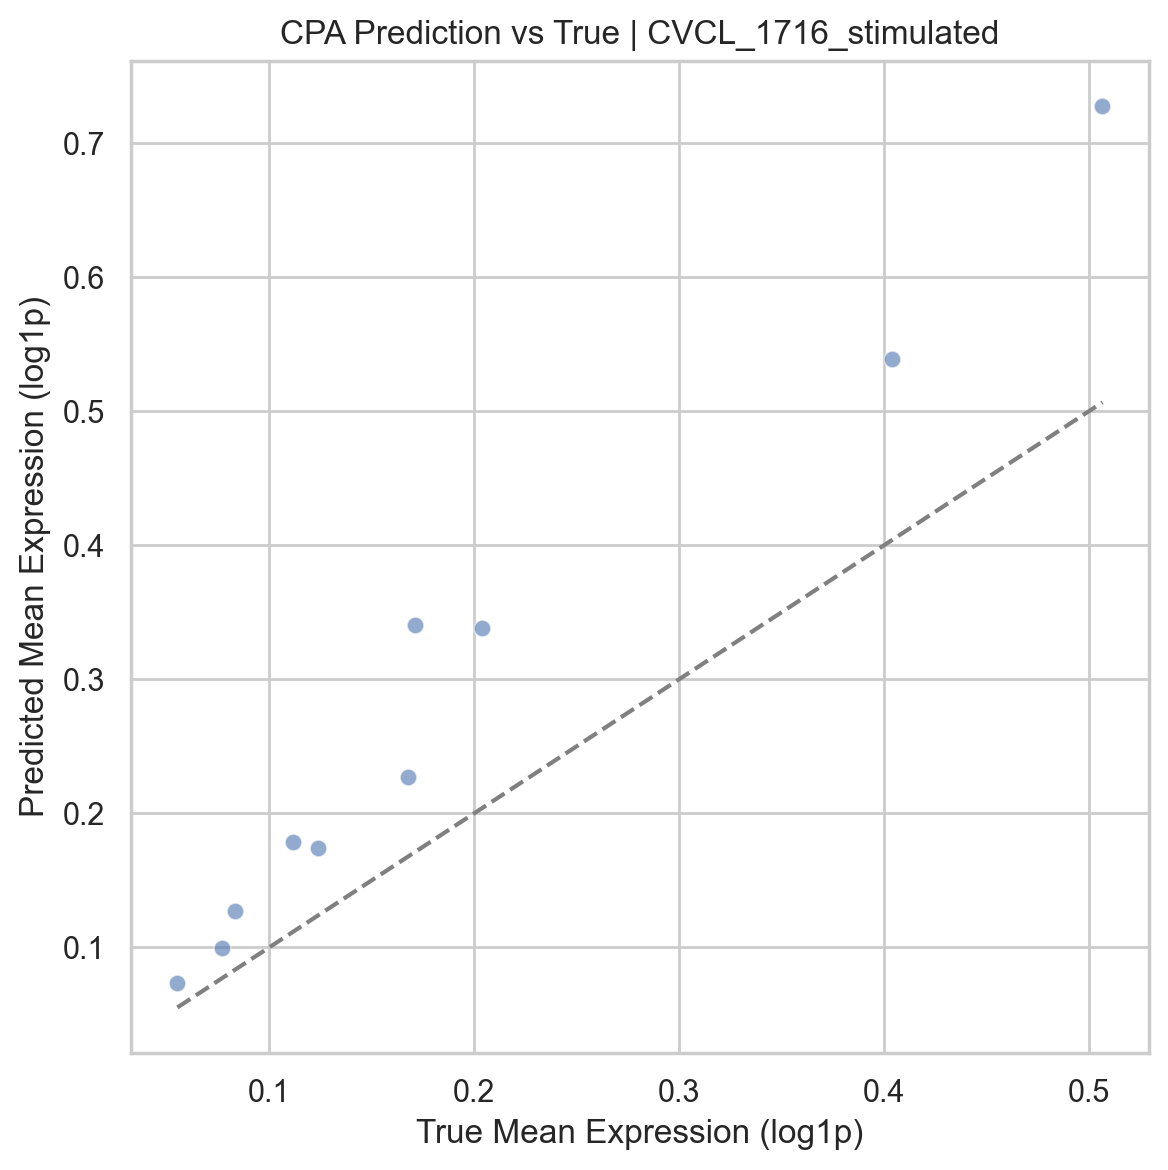

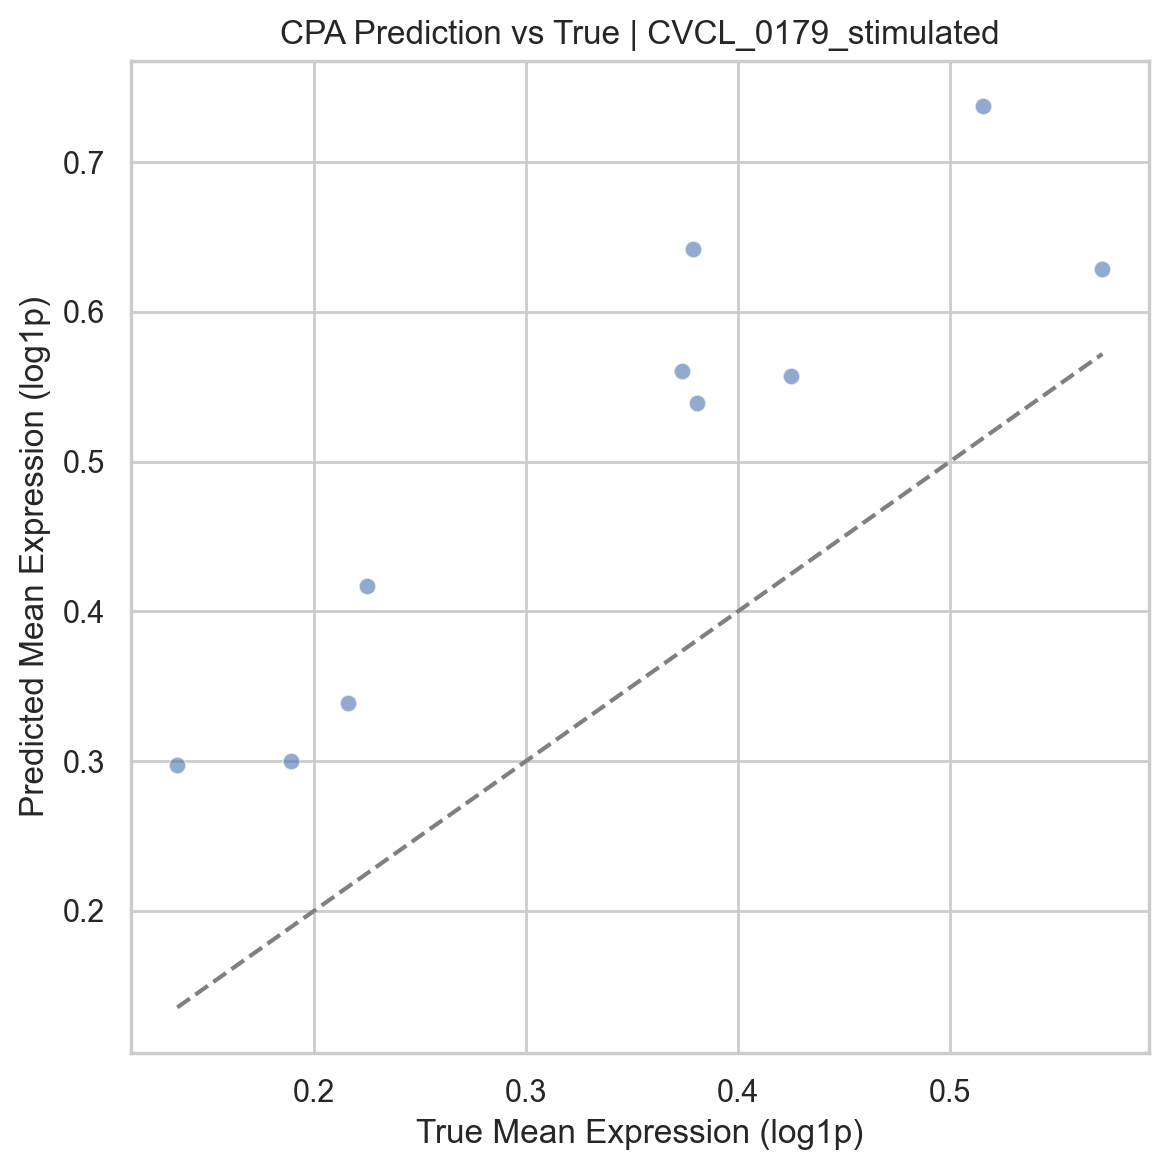

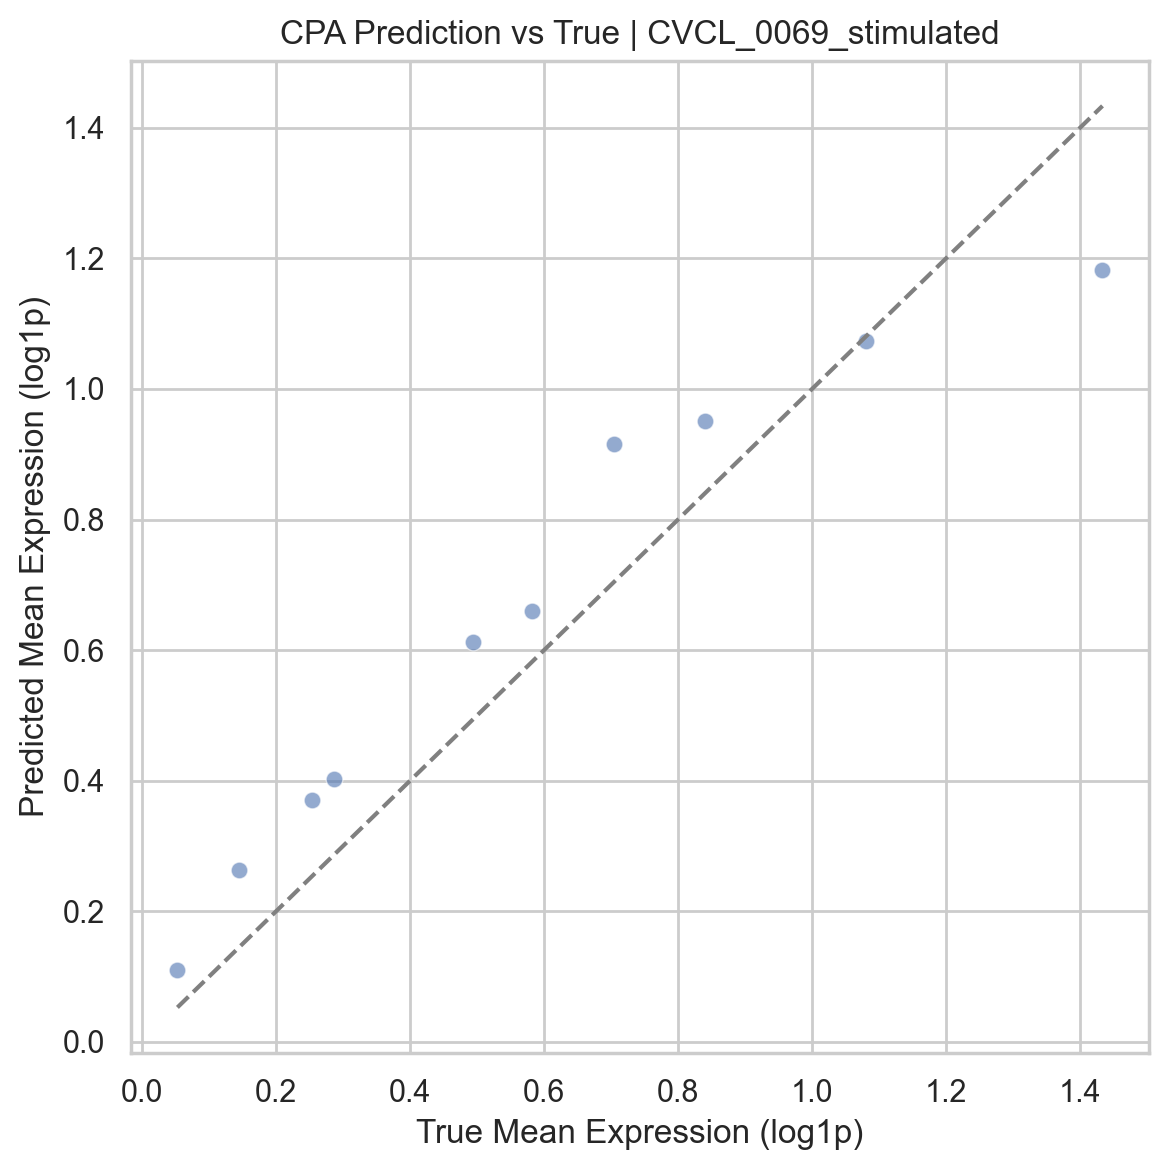

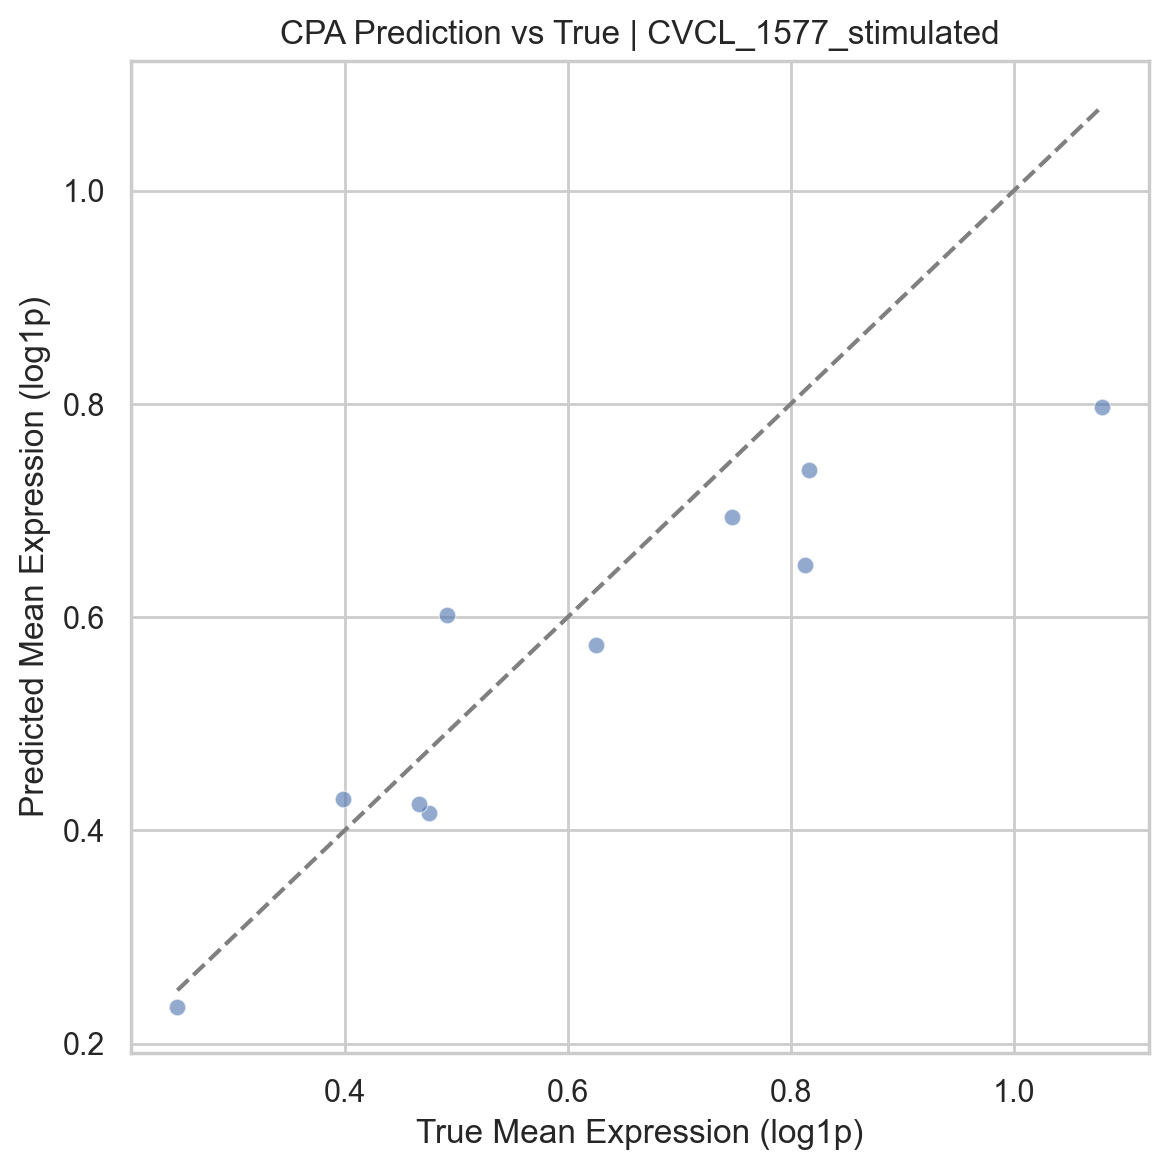

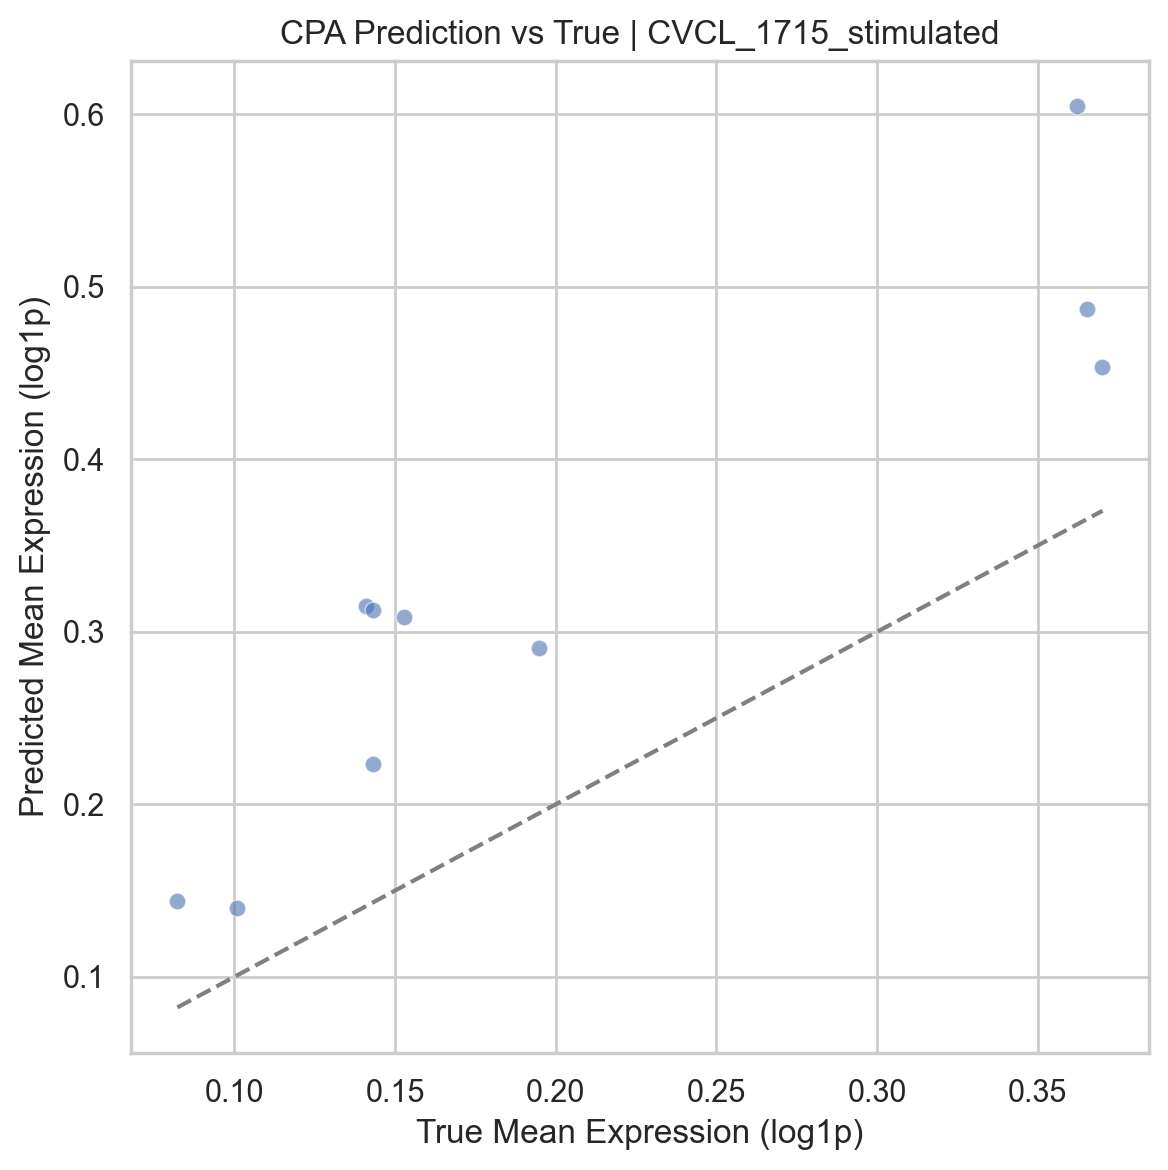

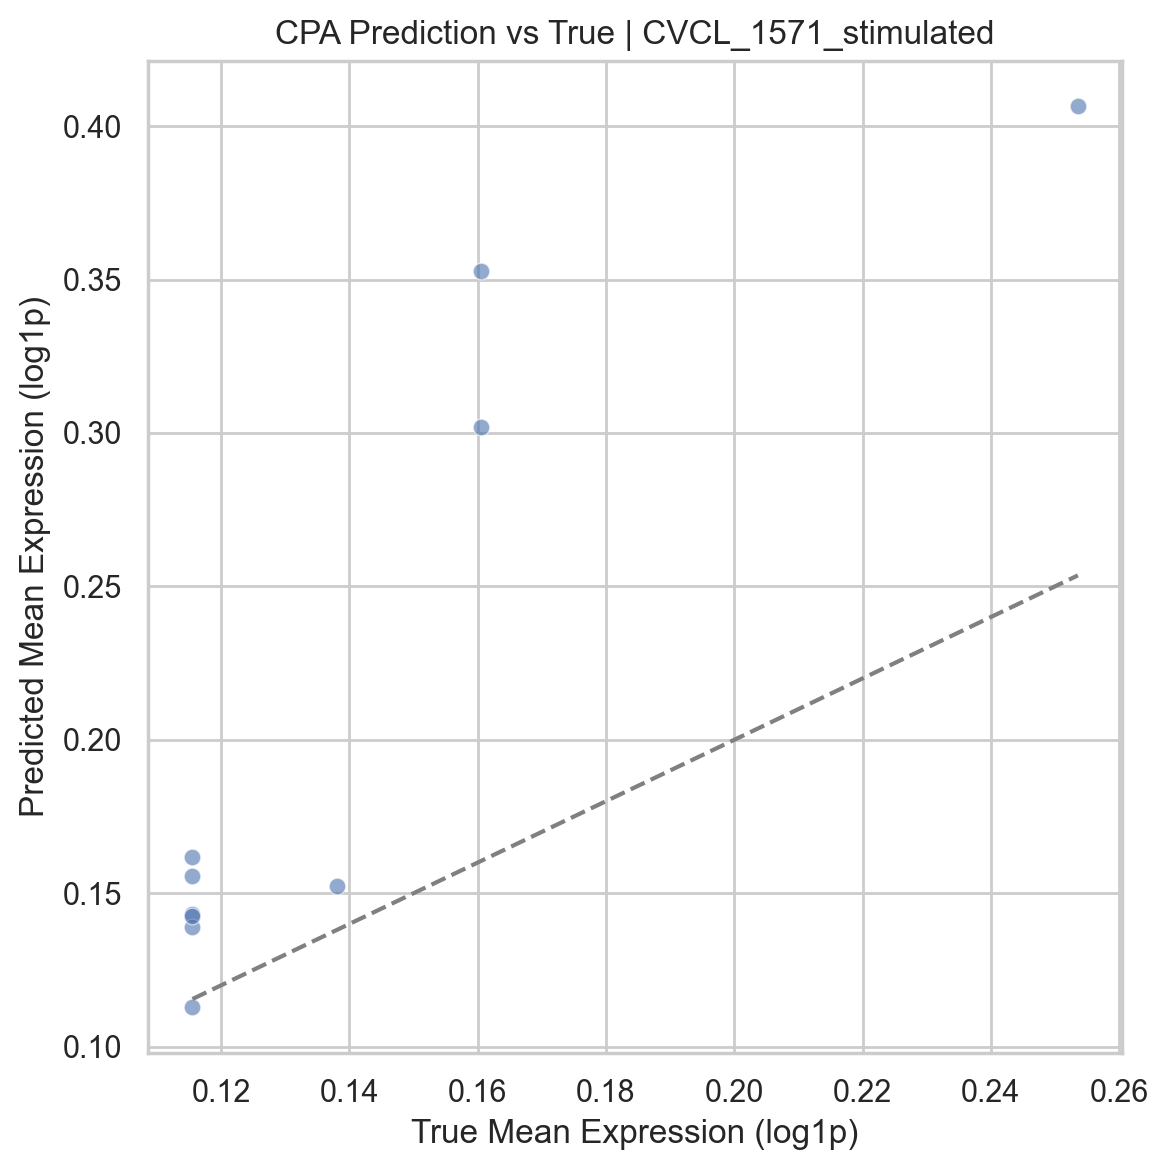

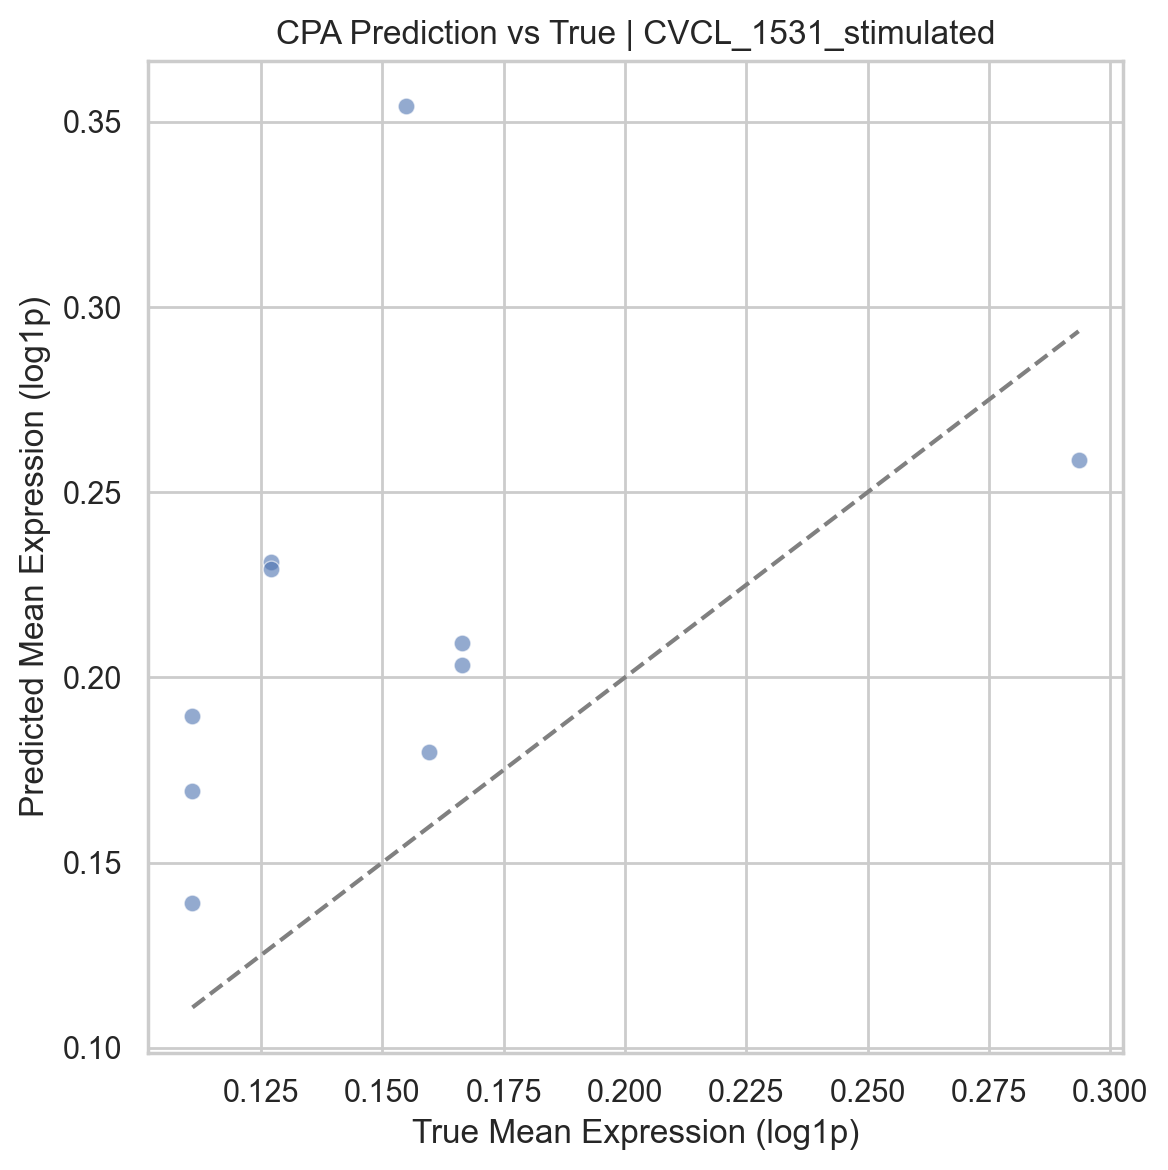

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Loop through all stimulated conditions
for cat in adata.obs['cov_cond'].unique():
    if 'stimulated' not in cat:
        continue

    # Get control condition
    cov, condition = cat.rsplit('_', 1)
    deg_cat = f'{cat}'
    deg_list = adata.uns['rank_genes_groups'][deg_cat]['names']
    degs = np.where(np.isin(adata.var_names, deg_list[:10]))[0]  # Top 10 DEGs

    if len(degs) == 0:
        print(f"No DEGs found for {cat}")
        continue

    # Extract adatas
    cat_adata = adata[adata.obs['cov_cond'] == cat]
    x_true = cat_adata.layers['counts']
    x_pred = cat_adata.obsm['CPA_pred']

    # Log1p transform if needed
    x_true = np.log1p(x_true)
    x_pred = np.log1p(x_pred)

    # Subset to DEGs
    x_true_deg = x_true[:, degs]
    x_pred_deg = x_pred[:, degs]

    # Convert mean to dense arrays
    true_mean = np.asarray(x_true_deg.mean(0)).flatten()
    pred_mean = np.asarray(x_pred_deg.mean(0)).flatten()

    # Plot
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=true_mean, y=pred_mean, alpha=0.6)
    plt.plot([true_mean.min(), true_mean.max()],
             [true_mean.min(), true_mean.max()],
             linestyle='--', color='gray')
    plt.xlabel("True Mean Expression (log1p)")
    plt.ylabel("Predicted Mean Expression (log1p)")
    plt.title(f"CPA Prediction vs True | {cat}")
    plt.tight_layout()
    plt.show()
